In [1]:
# !pip install -q xgboost

In [2]:
# !pip install -q lightgbm

In [39]:
import pandas as pd
import numpy as np
import os
import time
import phik
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(
    style='ticks', 
    context='talk', 
    font_scale=0.8, 
    rc={'figure.figsize': (8,6)}
)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFECV 
from category_encoders import TargetEncoder


from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

In [4]:
# get current working directory
os.getcwd()

'c:\\Users\\kings\\OneDrive - MMU\\Downloads\\new projects\\Credit-Score-Data'

### Load Data

In [5]:
def get_data(file):
    current_directory = os.getcwd()
    file_path = current_directory + "\\Credit Score Data\\"
    return pd.read_csv(file_path + file)

In [6]:
df = get_data('train.csv')
df.head()

ID  Customer_ID  Month           Name   Age          SSN Occupation  \
0  5634         3392      1  Aaron Maashoh  23.0  821000265.0  Scientist   
1  5635         3392      2  Aaron Maashoh  23.0  821000265.0  Scientist   
2  5636         3392      3  Aaron Maashoh  23.0  821000265.0  Scientist   
3  5637         3392      4  Aaron Maashoh  23.0  821000265.0  Scientist   
4  5638         3392      5  Aaron Maashoh  23.0  821000265.0  Scientist   

   Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  Credit_Mix  \
0       19114.12            1824.843333                3.0  ...        Good   
1       19114.12            1824.843333                3.0  ...        Good   
2       19114.12            1824.843333                3.0  ...        Good   
3       19114.12            1824.843333                3.0  ...        Good   
4       19114.12            1824.843333                3.0  ...        Good   

   Outstanding_Debt  Credit_Utilization_Ratio Credit_History_Age  \
0            809.98                 26.822620              265.0   
1            809.98                 31.944960              266.0   
2            809.98                 28.609352              267.0   
3            809.98                 31.377862              268.0   
4            809.98                 24.797347              269.0   

   Payment_of_Min_Amount  Total_EMI_per_month  Amount_invested_monthly  \
0                     No            49.574949                 21.46538   
1                     No            49.574949                 21.46538   
2                     No            49.574949                 21.46538   
3                     No            49.574949                 21.46538   
4                     No            49.574949                 21.46538   

                  Payment_Behaviour Monthly_Balance  Credit_Score  
0   High_spent_Small_value_payments      312.494089          Good  
1    Low_spent_Large_value_payments      284.629162          Good  
2   Low_spent_Medium_value_payments      331.209863          Good  
3    Low_spent_Small_value_payments      223.451310          Good  
4  High_spent_Medium_value_payments      341.489231          Good  

[5 rows x 28 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Customer_ID               100000 non-null  int64  
 2   Month                     100000 non-null  int64  
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  float64
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  float64
 10  Num_Credit_Card           100000 non-null  float64
 11  Interest_Rate             100000 non-null  float64
 12  Num_of_Loan               100000 non-null  float64
 13  Type_of_Loan              100000 non-null  ob

In [8]:
# check the shape of the dataset
df.shape

(100000, 28)

In [9]:
# check for missing values
df.isnull().sum()

ID                          0
Customer_ID                 0
Month                       0
Name                        0
Age                         0
SSN                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
dtype: int64

In [10]:
# set id column as index
df = df.set_index(df['ID']).drop(columns=['ID'])

In [11]:
# check for duplicated entries
df[df.duplicated()]

Empty DataFrame
Columns: [Customer_ID, Month, Name, Age, SSN, Occupation, Annual_Income, Monthly_Inhand_Salary, Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, Num_of_Loan, Type_of_Loan, Delay_from_due_date, Num_of_Delayed_Payment, Changed_Credit_Limit, Num_Credit_Inquiries, Credit_Mix, Outstanding_Debt, Credit_Utilization_Ratio, Credit_History_Age, Payment_of_Min_Amount, Total_EMI_per_month, Amount_invested_monthly, Payment_Behaviour, Monthly_Balance, Credit_Score]
Index: []

[0 rows x 27 columns]

In [12]:
df.head()

Customer_ID  Month           Name   Age          SSN Occupation  \
ID                                                                      
5634         3392      1  Aaron Maashoh  23.0  821000265.0  Scientist   
5635         3392      2  Aaron Maashoh  23.0  821000265.0  Scientist   
5636         3392      3  Aaron Maashoh  23.0  821000265.0  Scientist   
5637         3392      4  Aaron Maashoh  23.0  821000265.0  Scientist   
5638         3392      5  Aaron Maashoh  23.0  821000265.0  Scientist   

      Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
ID                                                              
5634       19114.12            1824.843333                3.0   
5635       19114.12            1824.843333                3.0   
5636       19114.12            1824.843333                3.0   
5637       19114.12            1824.843333                3.0   
5638       19114.12            1824.843333                3.0   

      Num_Credit_Card  ...  Credit_Mix  Outstanding_Debt  \
ID                     ...                                 
5634              4.0  ...        Good            809.98   
5635              4.0  ...        Good            809.98   
5636              4.0  ...        Good            809.98   
5637              4.0  ...        Good            809.98   
5638              4.0  ...        Good            809.98   

     Credit_Utilization_Ratio  Credit_History_Age  Payment_of_Min_Amount  \
ID                                                                         
5634                26.822620               265.0                     No   
5635                31.944960               266.0                     No   
5636                28.609352               267.0                     No   
5637                31.377862               268.0                     No   
5638                24.797347               269.0                     No   

      Total_EMI_per_month  Amount_invested_monthly  \
ID                                                   
5634            49.574949                 21.46538   
5635            49.574949                 21.46538   
5636            49.574949                 21.46538   
5637            49.574949                 21.46538   
5638            49.574949                 21.46538   

                     Payment_Behaviour  Monthly_Balance  Credit_Score  
ID                                                                     
5634   High_spent_Small_value_payments       312.494089          Good  
5635    Low_spent_Large_value_payments       284.629162          Good  
5636   Low_spent_Medium_value_payments       331.209863          Good  
5637    Low_spent_Small_value_payments       223.451310          Good  
5638  High_spent_Medium_value_payments       341.489231          Good  

[5 rows x 27 columns]

In [13]:
df['Month'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

Some columns won't be neccessary in prediciting categories for Credit Scores. Columns like `Name`, `Customer_ID`, `SSN`

In [14]:
# Drop irrelevant columns
df.drop(columns=['Name','Customer_ID','SSN'], inplace=True)

#### Feature Correlation using `Phik library`

In [15]:
seed = 1234
feat_corr = df.sample(frac=0.1, random_state=seed).phik_matrix()

interval columns not set, guessing: ['Month', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']


<Axes: >

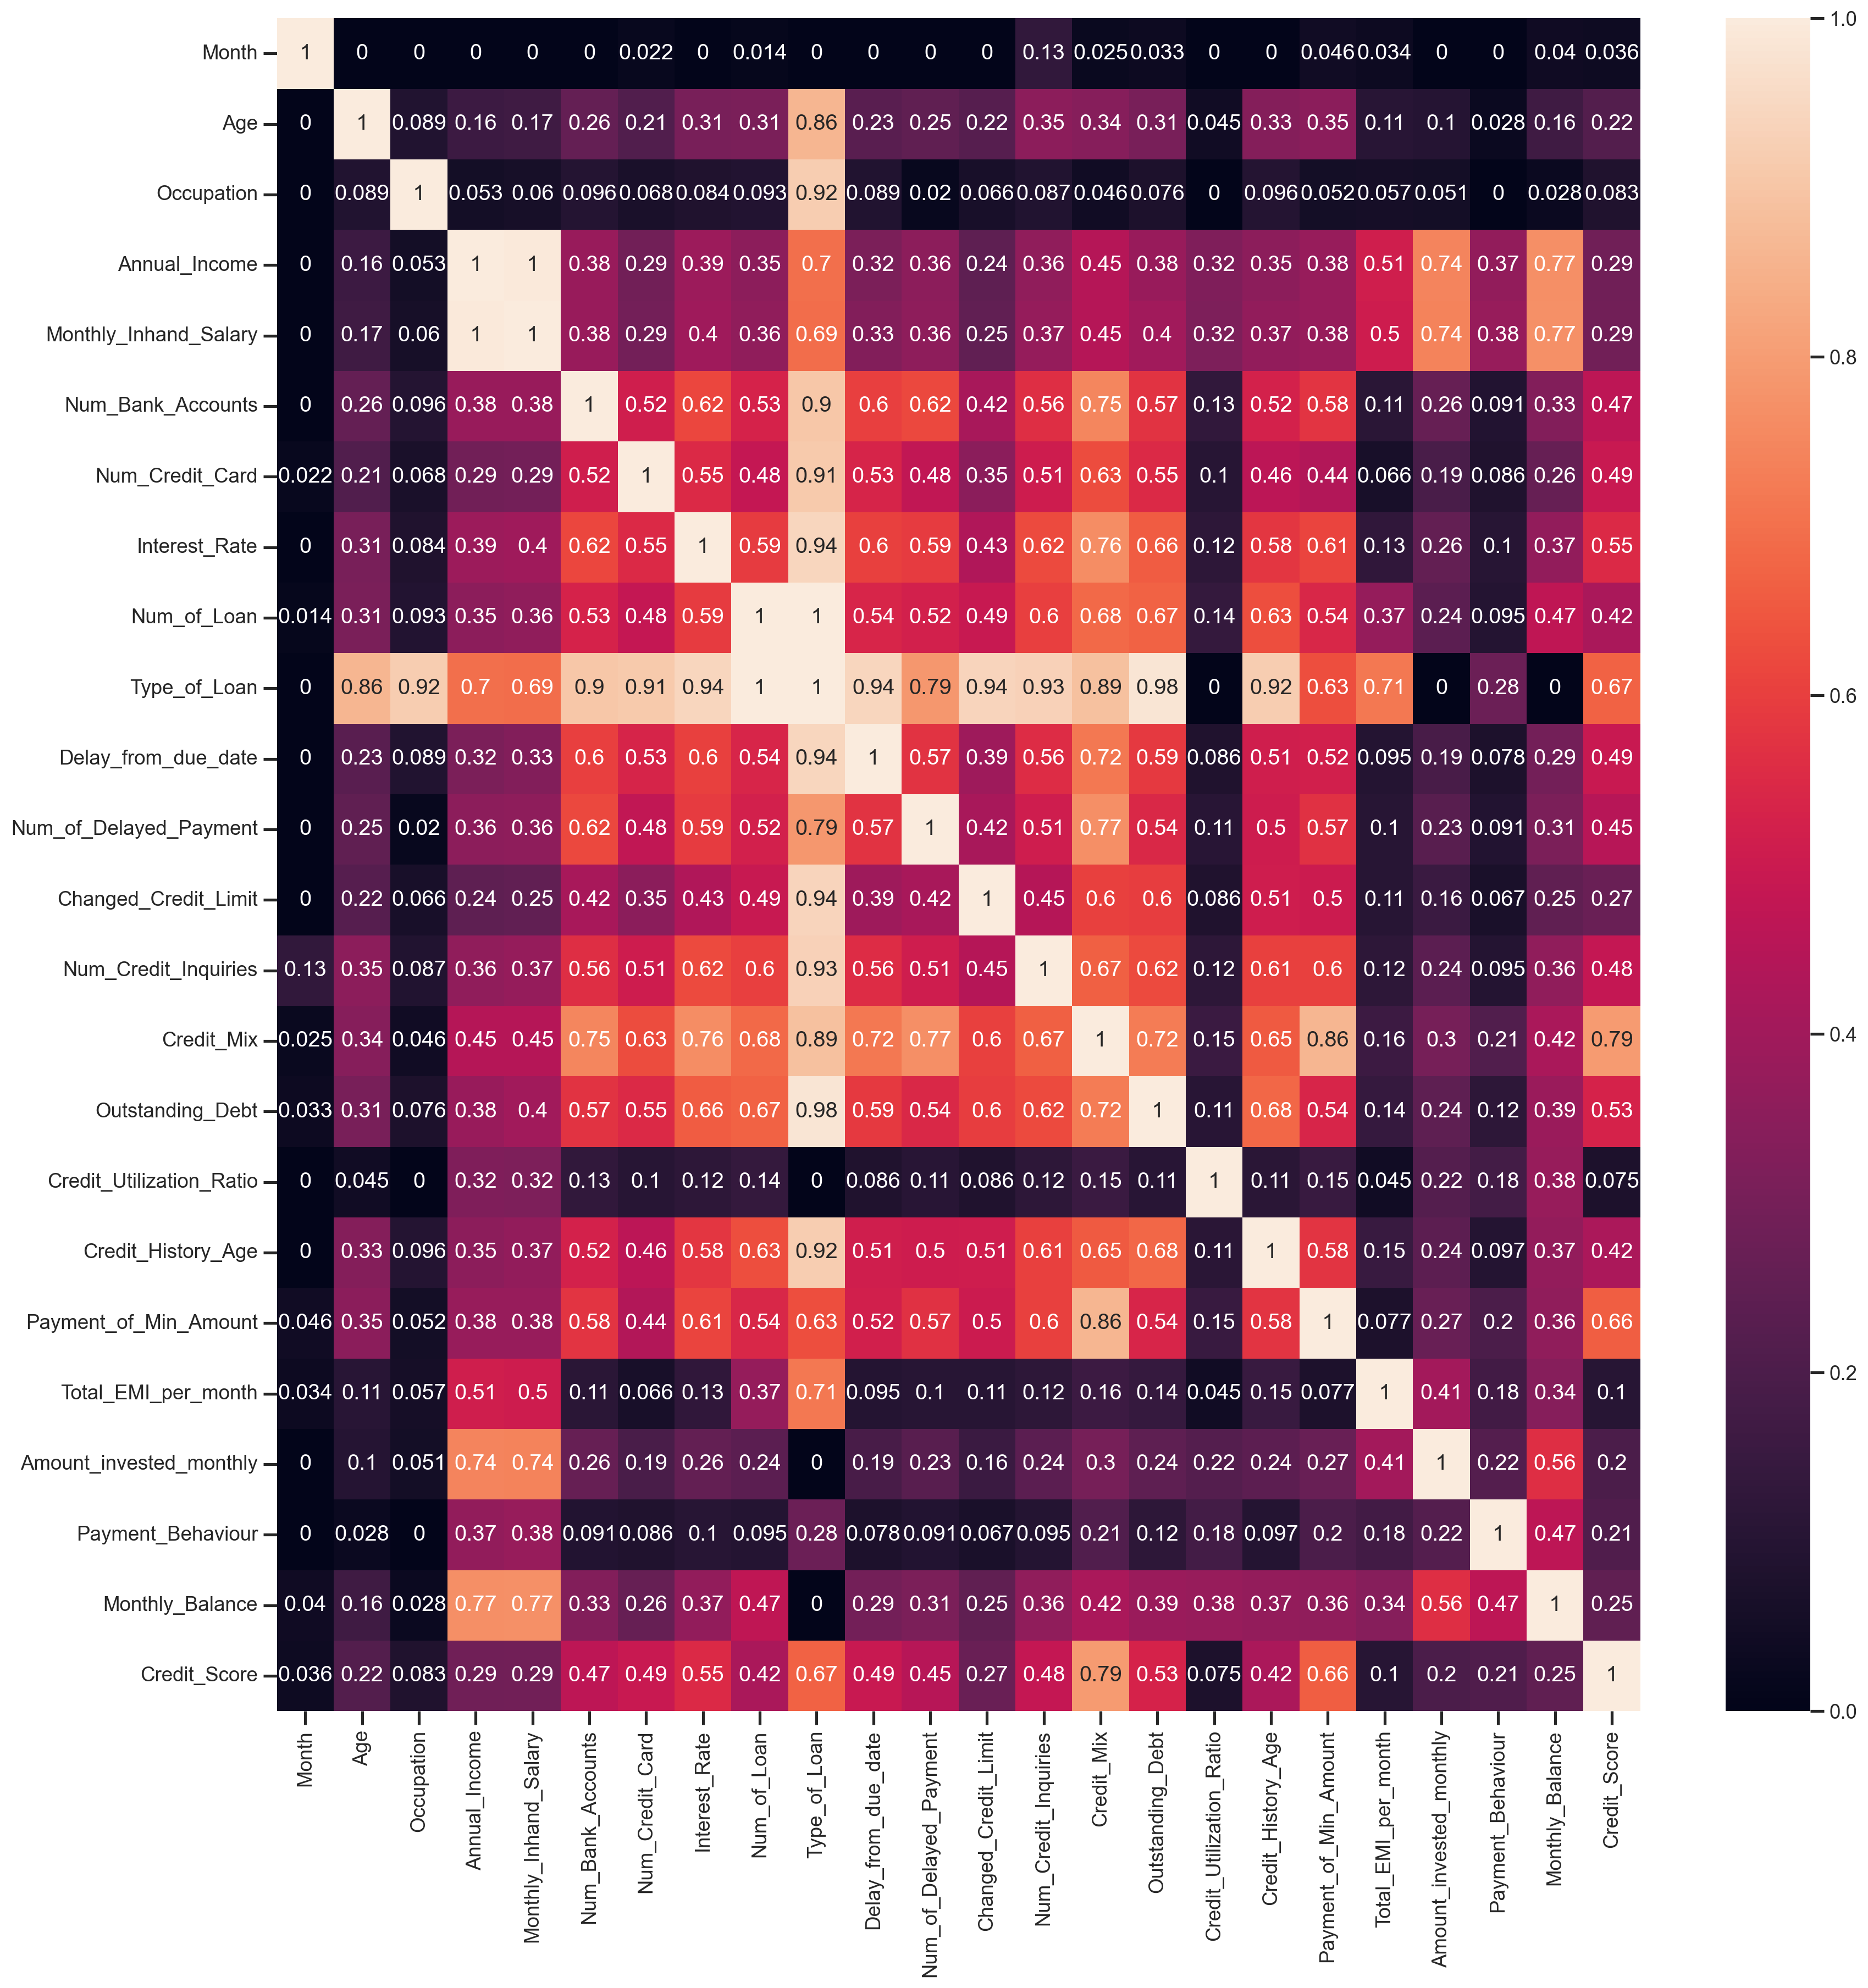

In [16]:
plt.figure(figsize=(20,20))
sns.heatmap(feat_corr, annot=True)

There are several feature selection techniques, however, to gauge the feature importance, the novel correlation coefficient, ϕK's was used so because it is suitable for data sets with mixed variable types, e.g. where some variables are categorical. We can anticipate one variable from another if the two are correlated. As a result, if two features are correlated, the model only actually requires one of them as the other does not provide any new information. Some features have a perfect correlation with each other. Features like `Annual_Income` & `Monthly_Inhand_Salary`, and `Num_of_Loan` & `Type_of_Loan` have a perfect correlation between each other. One of each pairs would be dropped moving forward. The one with the highest correlation with the target will be kept.

In [17]:
df = df.drop(columns=['Monthly_Inhand_Salary', 'Num_of_Loan'])
df.shape

(100000, 22)

Text(0.5, 0, 'phik coefficient')

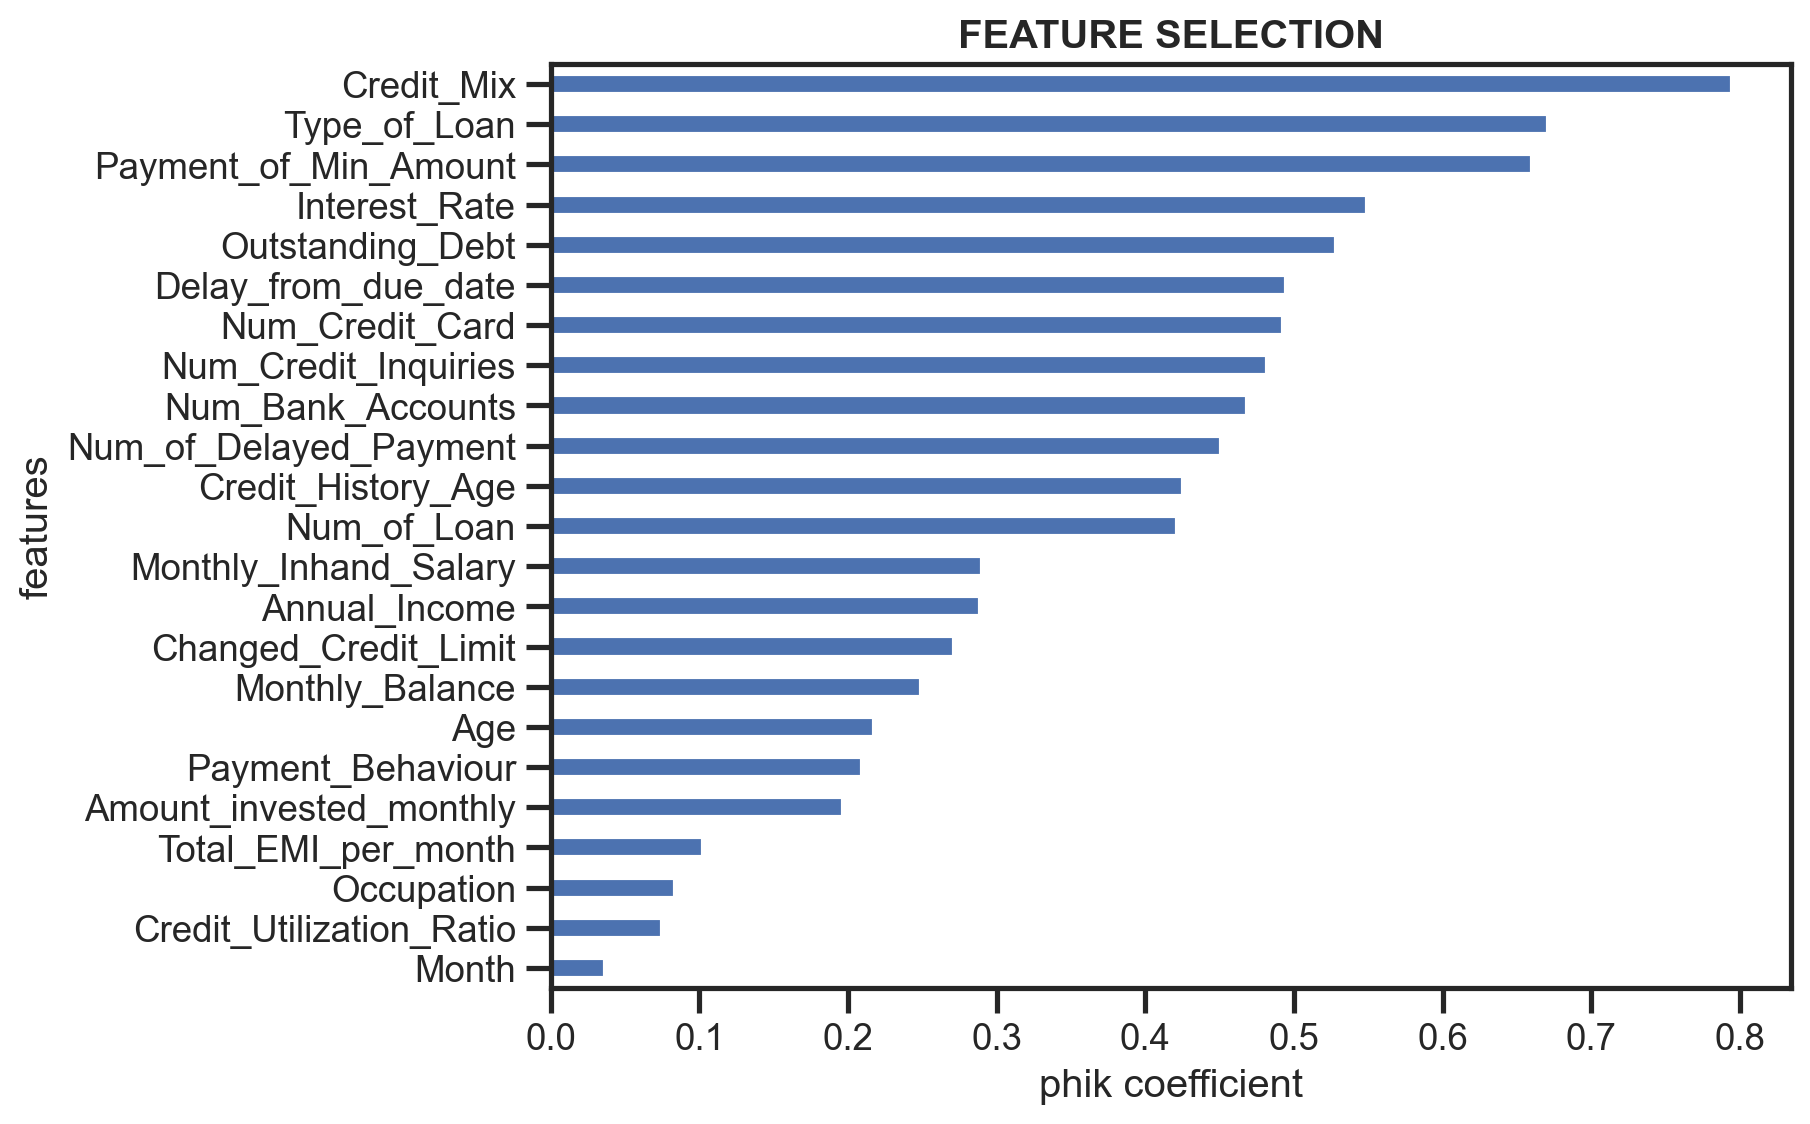

In [18]:
feat_corr['Credit_Score'].drop('Credit_Score').sort_values(ascending=True).plot(kind='barh')
plt.title('feature selection'.upper(),weight='bold')
plt.ylabel('features')
plt.xlabel('phik coefficient')

In [19]:
df['Type_of_Loan'].value_counts()[:15]

No Data                                  11408
Not Specified                             1408
Credit-Builder Loan                       1280
Personal Loan                             1272
Debt Consolidation Loan                   1264
Student Loan                              1240
Payday Loan                               1200
Mortgage Loan                             1176
Auto Loan                                 1152
Home Equity Loan                          1136
Personal Loan, and Student Loan            320
Not Specified, and Payday Loan             272
Mortgage Loan, and Home Equity Loan        264
Student Loan, and Payday Loan              256
Student Loan, and Credit-Builder Loan      248
Name: Type_of_Loan, dtype: int64

In [20]:
df['Credit_Score'].value_counts()

Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64

In [21]:
df['Credit_Score'] = df['Credit_Score'].astype('category').cat.codes

In [22]:
df['Credit_Score'].value_counts()

2    53174
1    28998
0    17828
Name: Credit_Score, dtype: int64

Making use of all 6000+ categories in `Type of Loan` column

In [23]:
# Selecting a sample to work with
df_sample = df.sample(frac=0.1,random_state=seed)
df_sample.shape

(10000, 22)

In [24]:
X, y = df_sample.drop(columns='Credit_Score'),df_sample['Credit_Score']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [25]:
cat_feat = [i for i in X_train.columns if df_sample[i].dtype == 'O']
num_feat = [i for i in X_train.columns if i not in cat_feat]
print(len(cat_feat),' ',cat_feat)
print(' ')
print(len(num_feat),' ',num_feat)

5   ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
 
16   ['Month', 'Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']


In [26]:
def check_num_unique_cats(col_lst):
    for i in range(len(col_lst)):
        result = df_sample[col_lst[i]].nunique()
        print(col_lst[i])
        print(result)
check_num_unique_cats(cat_feat)

Occupation
15
Type_of_Loan
3856
Credit_Mix
3
Payment_of_Min_Amount
3
Payment_Behaviour
6


`Type_of_Loan` has so many catregories, we will use Target encoding for encoding the variables 

In [27]:
encoder = TargetEncoder(cols=['Type_of_Loan']).fit(X_train, y_train) 
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [28]:
X_train.head()

Month   Age  Occupation  Annual_Income  Num_Bank_Accounts  \
ID                                                                  
153729      4  38.0  Accountant       23737.09                4.0   
40462       5  53.0  Journalist      152340.56                5.0   
58220       3  34.0     Manager       30771.54                4.0   
18367       2  31.0      Doctor       33409.33                4.0   
54744       7  15.0  Journalist       31606.46                4.0   

        Num_Credit_Card  Interest_Rate  Type_of_Loan  Delay_from_due_date  \
ID                                                                          
153729              5.0           11.0      1.293526                 17.0   
40462               4.0            8.0      1.163418                 16.0   
58220               6.0           18.0      1.431415                 19.0   
18367               7.0            5.0      1.431415                  5.0   
54744               7.0           19.0      1.300468                 16.0   

        Num_of_Delayed_Payment  ...  Num_Credit_Inquiries  Credit_Mix  \
ID                              ...                                     
153729                    10.0  ...                   6.0    Standard   
40462                     12.0  ...                   6.0        Good   
58220                     18.0  ...                   4.0    Standard   
18367                     12.0  ...                   2.0    Standard   
54744                     13.0  ...                  12.0    Standard   

       Outstanding_Debt  Credit_Utilization_Ratio  Credit_History_Age  \
ID                                                                      
153729            91.78                 33.681897               289.0   
40462            329.18                 37.450186               319.0   
58220            246.06                 29.352263               108.0   
18367            812.01                 38.595333               239.0   
54744           2538.26                 30.791713               153.0   

        Payment_of_Min_Amount Total_EMI_per_month  Amount_invested_monthly  \
ID                                                                           
153729                    Yes           47.141829                27.430839   
40462                      NM          422.793949                92.839829   
58220                     Yes          162.401814                37.821339   
18367                     Yes           46.129409                17.230817   
54744                     Yes           47.288123                46.339706   

                       Payment_Behaviour Monthly_Balance  
ID                                                        
153729    Low_spent_Small_value_payments      352.902572  
40462     Low_spent_Small_value_payments      272.291608  
58220   High_spent_Medium_value_payments      324.706348  
18367   High_spent_Medium_value_payments      350.111943  
54744    High_spent_Small_value_payments      358.758500  

[5 rows x 21 columns]

### Create preprocessing Pipeline

In [29]:
def preprocessor_pipe():
    numeric_features = X_train.select_dtypes(exclude='object').columns.tolist()
    numeric_transformer = Pipeline(
        steps=[
            # its a good practice to do the polynomial/interaction feature generation before scaling.
            ("poly_int", PolynomialFeatures(interaction_only=True, include_bias=False)),
            ("scaler", StandardScaler())
        ]
    ).set_output(transform='pandas')

    categorical_features = X_train.select_dtypes(include='object').columns.tolist()
    categorical_transformer = Pipeline(
        steps=[
            ("ohe", OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False, drop='if_binary')),
        ]
    ).set_output(transform='pandas')

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")

    return preprocessor

In [ ]:
df['Credit_Score'] = df['Credit_Score'].astype('category').cat.codes

In [ ]:
df['Credit_Score'].value_counts()

2    53174
1    28998
0    17828
Name: Credit_Score, dtype: int64

Making use of all 6000+ categories in `Type of Loan` column

In [ ]:
# Selecting a sample to work with
df_sample = df.sample(frac=0.1,random_state=seed)
df_sample.shape

(10000, 22)

In [30]:
preprocessor = preprocessor_pipe() 
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [31]:
X_train_preprocessed.head()

Month       Age  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
ID                                                                              
153729 -0.240562  0.402322      -0.697671          -0.528528        -0.247133   
40462   0.194676  1.784917       2.639281          -0.141490        -0.733617   
58220  -0.675800  0.033630      -0.515144          -0.528528         0.239350   
18367  -1.111038 -0.242889      -0.446700          -0.528528         0.725833   
54744   1.065152 -1.717657      -0.493480          -0.528528         0.725833   

        Interest_Rate  Type_of_Loan  Delay_from_due_date  \
ID                                                         
153729      -0.403790     -0.282049            -0.264451   
40462       -0.748110     -1.629487            -0.332764   
58220        0.399625      1.145964            -0.127824   
18367       -1.092431      1.145964            -1.084211   
54744        0.514398     -0.210155            -0.332764   

        Num_of_Delayed_Payment  Changed_Credit_Limit  ...  \
ID                                                    ...   
153729               -0.518420             -0.315769  ...   
40462                -0.201233             -0.399535  ...   
58220                 0.750330              1.365641  ...   
18367                -0.201233             -0.069040  ...   
54744                -0.042639              0.838678  ...   

        Credit_Mix_Standard  Payment_of_Min_Amount_NM  \
ID                                                      
153729                  1.0                       0.0   
40462                   0.0                       1.0   
58220                   1.0                       0.0   
18367                   1.0                       0.0   
54744                   1.0                       0.0   

        Payment_of_Min_Amount_No  Payment_of_Min_Amount_Yes  \
ID                                                            
153729                       0.0                        1.0   
40462                        0.0                        0.0   
58220                        0.0                        1.0   
18367                        0.0                        1.0   
54744                        0.0                        1.0   

        Payment_Behaviour_High_spent_Large_value_payments  \
ID                                                          
153729                                                0.0   
40462                                                 0.0   
58220                                                 0.0   
18367                                                 0.0   
54744                                                 0.0   

        Payment_Behaviour_High_spent_Medium_value_payments  \
ID                                                           
153729                                                0.0    
40462                                                 0.0    
58220                                                 1.0    
18367                                                 1.0    
54744                                                 0.0    

        Payment_Behaviour_High_spent_Small_value_payments  \
ID                                                          
153729                                                0.0   
40462                                                 0.0   
58220                                                 0.0   
18367                                                 0.0   
54744                                                 1.0   

        Payment_Behaviour_Low_spent_Large_value_payments  \
ID                                                         
153729                                               0.0   
40462                                                0.0   
58220                                                0.0   
18367                                                0.0   
54744                                                0.0   

        Payment_Behaviour_Low_spent_Medi

### Trying out Principal Component Analysis using the pre processed data set

In [32]:
X_pca = PCA()
X_pca.fit(X_train_preprocessed)

PCA()

In [33]:
X_pca.explained_variance_ratio_

array([3.00915954e-01, 1.61580265e-01, 6.30793076e-02, 5.30258502e-02,
       5.10906169e-02, 4.04079334e-02, 3.57306016e-02, 2.97392253e-02,
       2.81607369e-02, 2.63924386e-02, 2.59989130e-02, 2.30717003e-02,
       2.03155279e-02, 1.94656258e-02, 1.74298157e-02, 1.12260618e-02,
       9.56169452e-03, 8.11504583e-03, 5.01235418e-03, 4.04248950e-03,
       3.45385144e-03, 2.70440456e-03, 2.21871728e-03, 2.13682017e-03,
       2.04412341e-03, 1.89664627e-03, 1.86135849e-03, 1.71738614e-03,
       1.67929428e-03, 1.57970970e-03, 1.51328830e-03, 1.39443378e-03,
       1.34862760e-03, 1.29630108e-03, 1.22947747e-03, 1.15225142e-03,
       1.12544259e-03, 1.02449960e-03, 9.75808431e-04, 9.16517081e-04,
       8.86989013e-04, 8.40650177e-04, 7.90831088e-04, 7.82451701e-04,
       7.27364721e-04, 7.14676428e-04, 7.13066819e-04, 6.72371572e-04,
       6.62576168e-04, 6.37731201e-04, 6.37324767e-04, 6.14144384e-04,
       5.84458581e-04, 5.68025948e-04, 5.35159052e-04, 4.90302402e-04,
      

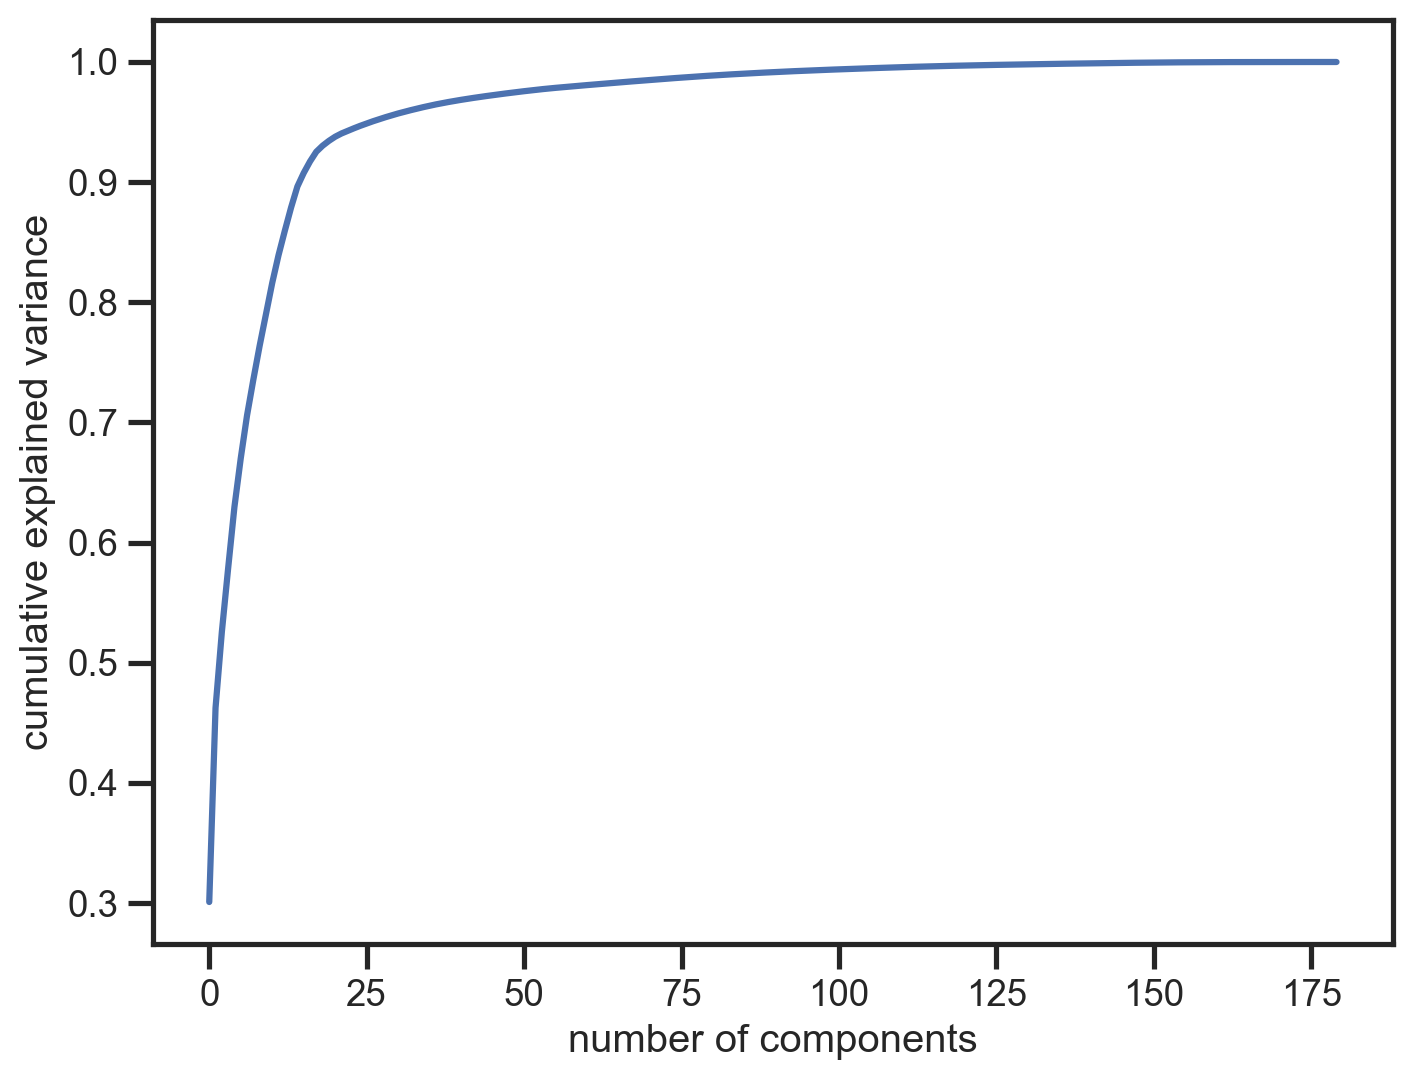

In [34]:
plt.plot(np.cumsum(X_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

 n_components=0.95. This will select the number of components while preserving 95% of the variability in the data.

In [35]:
X_pca = PCA(n_components=0.95,random_state=seed)
X_pca.fit(X_train_preprocessed)
pca_X = X_pca.transform(X_train_preprocessed)
pca_test = X_pca.transform(X_test_preprocessed)

In [36]:
pca_X.shape

(7000, 27)

In [37]:
components = []
for i in range(1,pca_X.shape[1]+1):
    components.append('component'+str(i))    

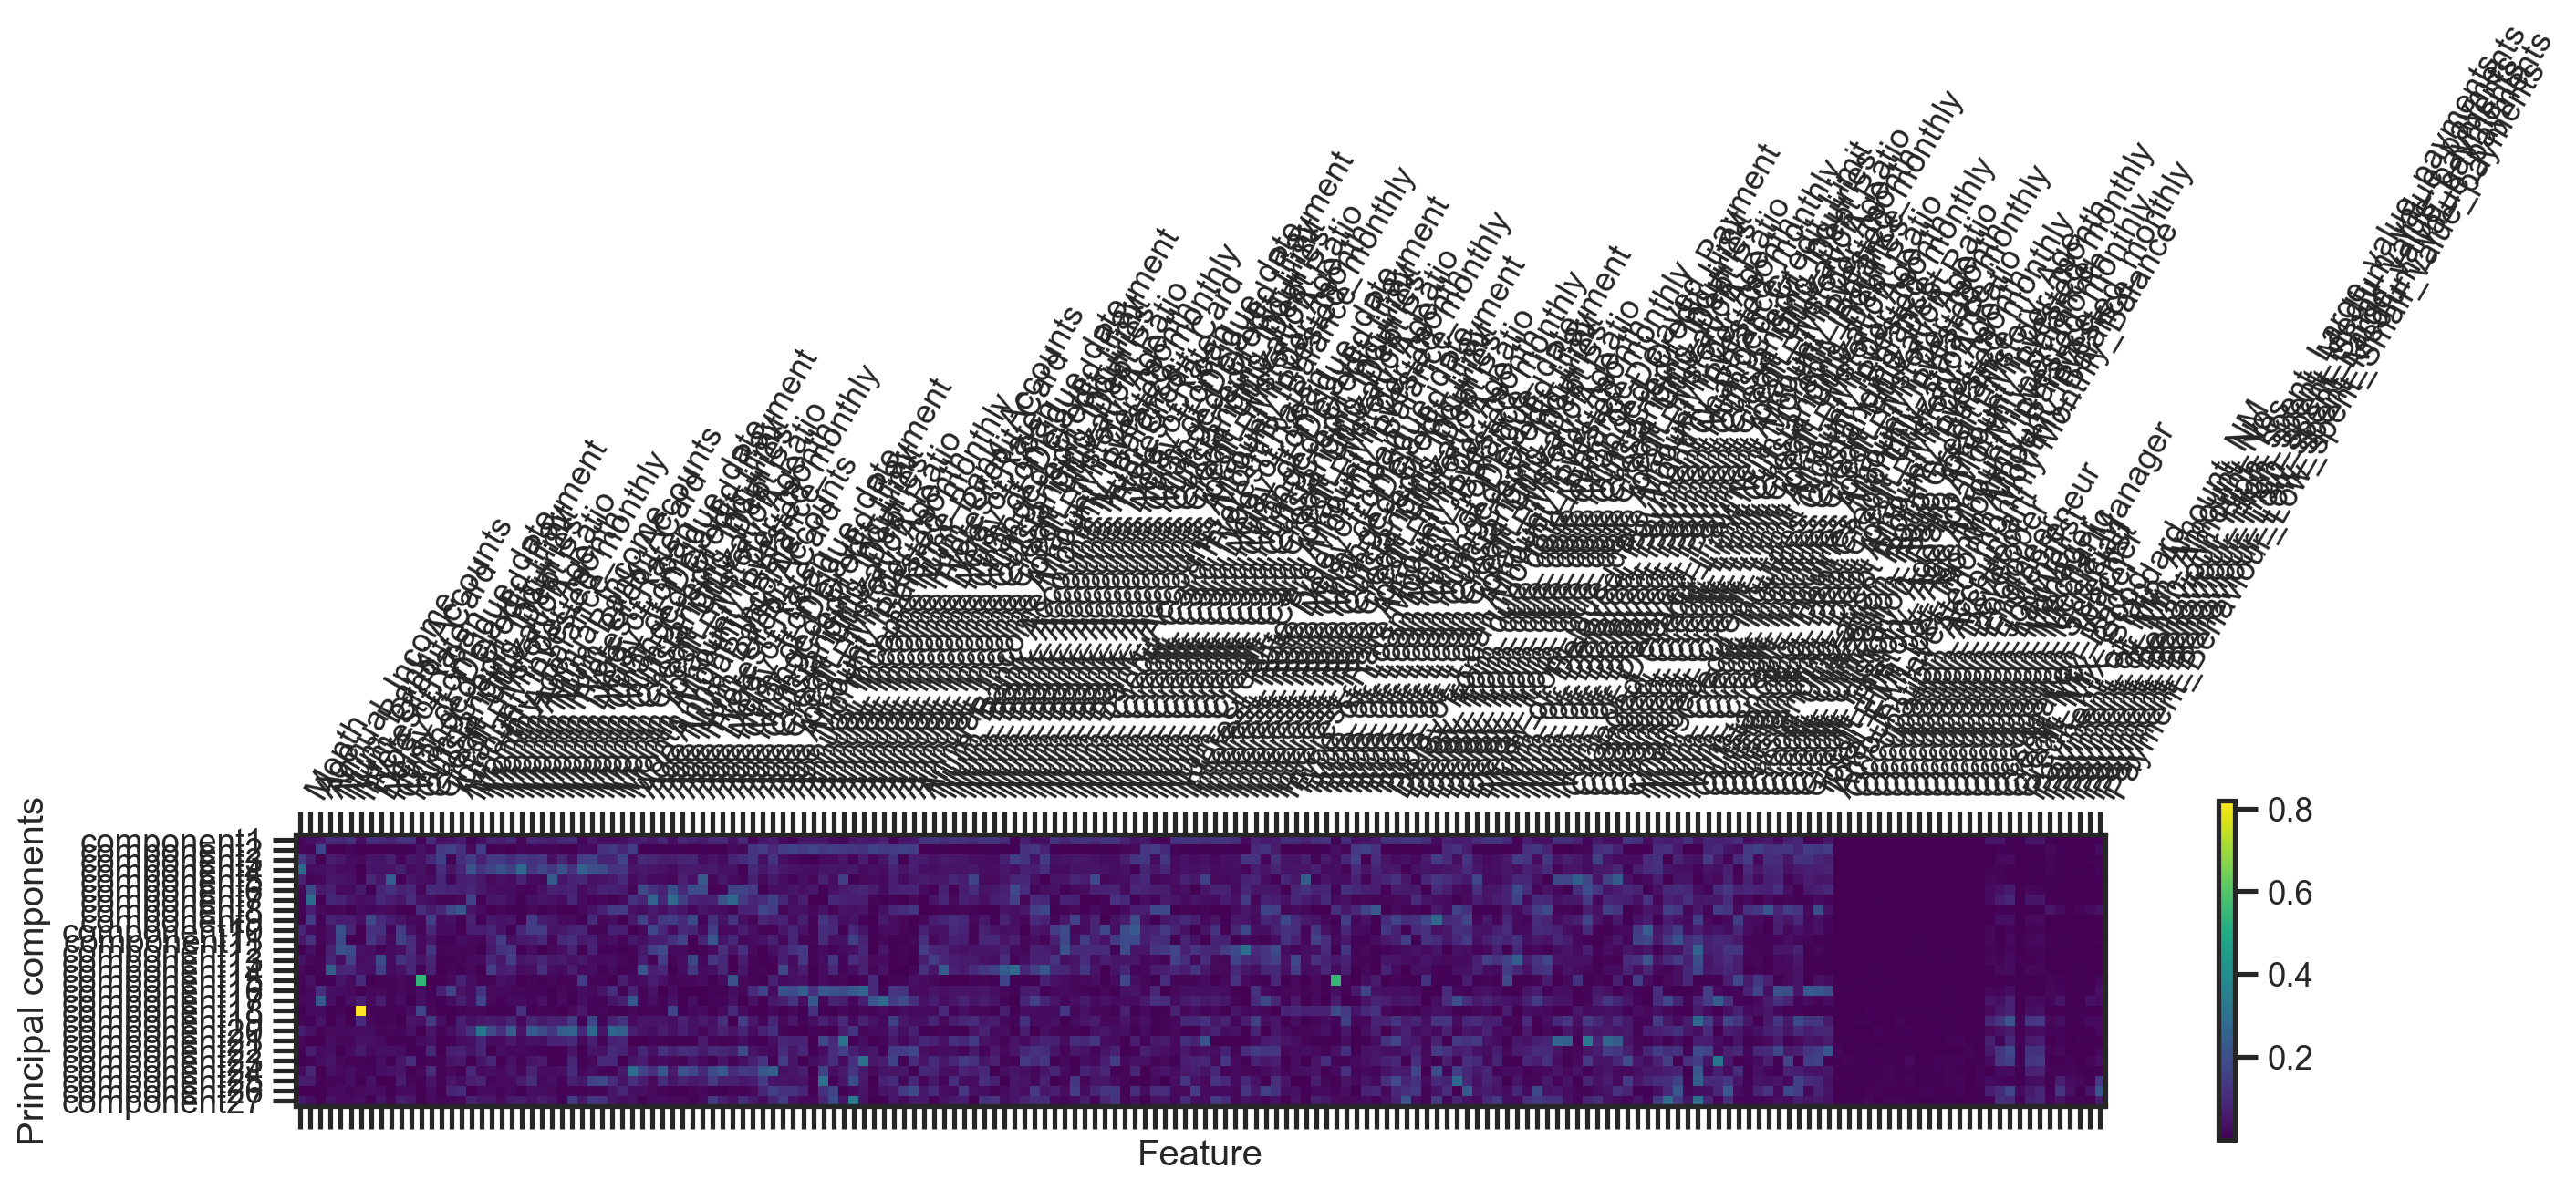

In [38]:
## The Influence of the Features in the Components
plt.matshow(np.abs(X_pca.components_)[:pca_X.shape[1]], cmap='viridis')
plt.yticks(range(pca_X.shape[1]), components)
plt.colorbar()
plt.xticks(range(len(X_train_preprocessed.columns)),
           X_train_preprocessed.columns, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components");

### Model fitting on PCA components

In [40]:
 def model_selection(xtrain,xtest,ytrain,ytest):
    models = {
        'logistic_regression':{
            'model':LogisticRegression()
        },
        'random_forest':{
            'model':RandomForestClassifier(random_state=seed)
        },
       'catboost':{
            'model':CatBoostClassifier(verbose=False,random_state=seed)
        },
        'decisontree':{
            'model': DecisionTreeClassifier(random_state=seed)
        },
        'extratree':{
            'model': ExtraTreesClassifier(random_state=seed)
        },
        'xgb':{
            'model': XGBClassifier(random_state=seed)
        },
        'lgbm':{
            'model': LGBMClassifier(random_state=seed)
        }
    }

    scores = []
    for model_name, config in models.items():
        start = time.time()
        config['model'].fit(xtrain, ytrain)
        y_pred = config['model'].predict(xtest) 
        train_score = config['model'].score(xtrain, ytrain)
        balanced_acc = balanced_accuracy_score(ytest, y_pred)
        acc = accuracy_score(ytest, y_pred)
        precision = precision_score(ytest, y_pred, average='weighted')
        end = time.time()
        elasped_time = end - start
        scores.append({
            'model': model_name,
            'train_score':train_score,
            'balanced_acc':balanced_acc,
            'acc':acc,
            'precision':precision,
            'time_taken':elasped_time})

    return pd.DataFrame(scores,columns=['model','train_score','balanced_acc','acc','precision','time_taken'])

In [41]:
result_pca= model_selection(pca_X, pca_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 27
[LightGBM] [Info] Start training from score -1.682009
[LightGBM] [Info] Start training from score -1.235906
[LightGBM] [Info] Start training from score -0.647355


In [42]:
result_pca.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc       acc  precision  \
4            extratree     1.000000      0.634863  0.675667   0.672620   
2             catboost     0.986143      0.640280  0.665333   0.666127   
5                  xgb     1.000000      0.638213  0.665333   0.666123   
6                 lgbm     0.985714      0.637475  0.665000   0.665151   
1        random_forest     1.000000      0.635911  0.663667   0.663101   
0  logistic_regression     0.751286      0.605300  0.635667   0.635252   
3          decisontree     1.000000      0.562643  0.581667   0.590394   

   time_taken  
4    1.135103  
2   15.753088  
5    1.325538  
6    1.251391  
1    4.407914  
0    0.191248  
3    0.254829

Run the entire dataset (`X_train_preprocessed`) on different models

In [43]:
result_whole = model_selection(X_train_preprocessed, X_test_preprocessed, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34936
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 180
[LightGBM] [Info] Start training from score -1.682009
[LightGBM] [Info] Start training from score -1.235906
[LightGBM] [Info] Start training from score -0.647355


In [44]:
result_whole.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc       acc  precision  \
4            extratree     1.000000      0.710785  0.724000   0.726064   
1        random_forest     1.000000      0.692827  0.709333   0.711034   
6                 lgbm     0.999286      0.679410  0.699000   0.700318   
2             catboost     0.984857      0.675381  0.694667   0.696124   
5                  xgb     1.000000      0.672584  0.693000   0.694100   
0  logistic_regression     0.805857      0.647478  0.665333   0.668538   
3          decisontree     1.000000      0.597303  0.621333   0.624154   

   time_taken  
4    1.956681  
1    9.029809  
6    3.322352  
2   56.633470  
5    5.769956  
0    1.750854  
3    1.044636

### Automated Feature Selection Using Recursive Feature Elimination with Cross-Validation (RFECV)

In [46]:
model = LogisticRegression()
ref_selector = RFECV(model, step=1, cv=10)

In [47]:
ref_selector.fit(X_train_preprocessed, y_train)

RFECV(cv=10, estimator=LogisticRegression())

In [48]:
n_scores = len(ref_selector.cv_results_["mean_test_score"])
n_scores

180

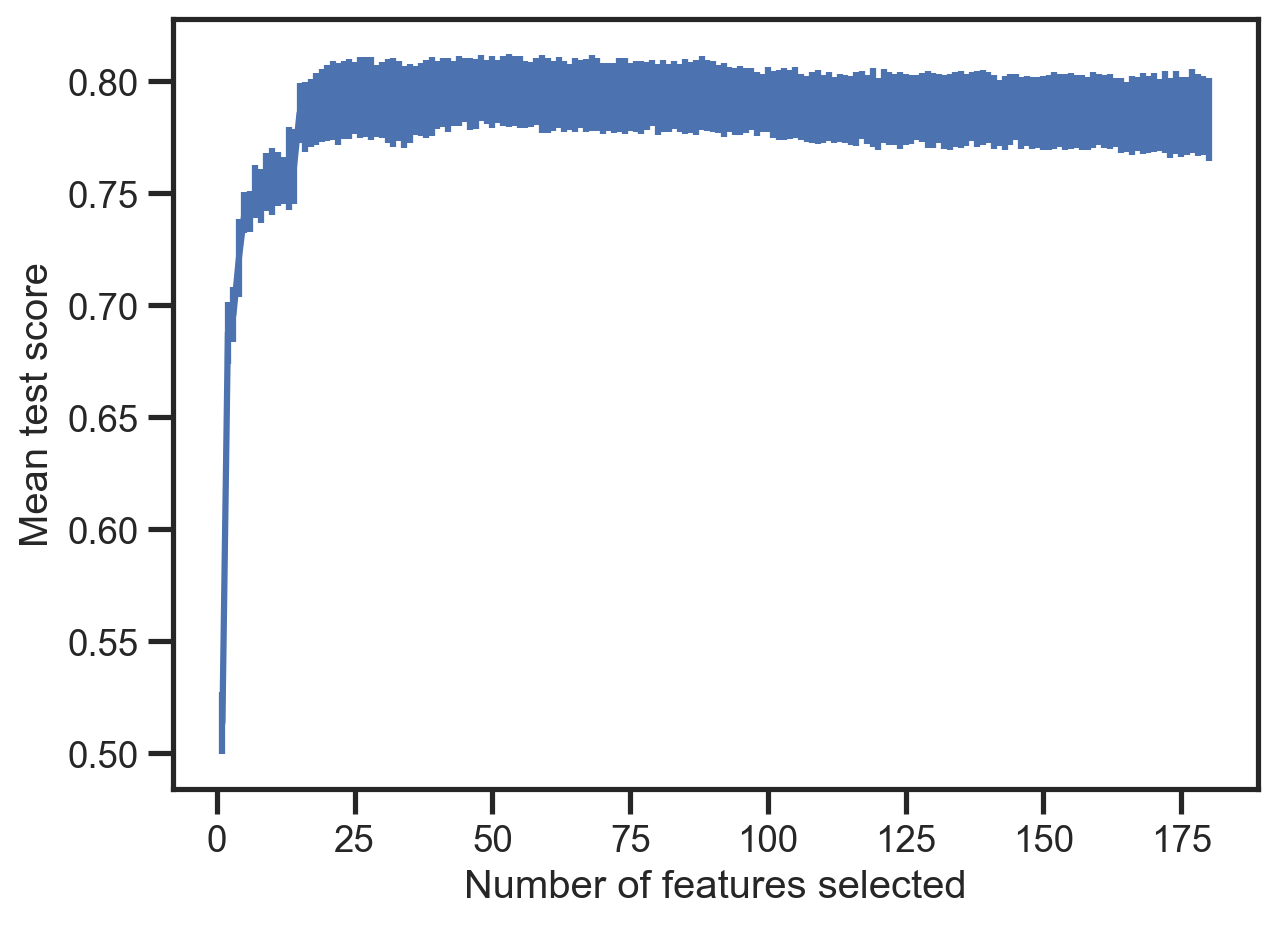

In [49]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    ref_selector.cv_results_["mean_test_score"],
    yerr=ref_selector.cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

In [50]:
pd.DataFrame(ref_selector.cv_results_["mean_test_score"],range(1, n_scores+1)).sort_values(by=0,ascending=False).head()

0
48  0.797000
45  0.796000
53  0.795714
54  0.795571
52  0.795429

In [51]:
# Get the indices of the top performing features
top_features_idx = ref_selector.get_support(indices=True)

# Get the names of the top performing features
top_features_names = X_train_preprocessed.columns[top_features_idx]

# Print the top performing features
print("Top performing features:")
print(len(top_features_names))


Top performing features:
48


### Model fitting and prediction on top selected features by REFCV

In [52]:
result_refcv_full = model_selection(X_train_preprocessed[top_features_names], X_test_preprocessed[top_features_names], y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8633
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 48
[LightGBM] [Info] Start training from score -1.682009
[LightGBM] [Info] Start training from score -1.235906
[LightGBM] [Info] Start training from score -0.647355


In [53]:
result_refcv_full.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc       acc  precision  \
4            extratree     1.000000      0.695770  0.713667   0.715684   
1        random_forest     0.999857      0.694209  0.707000   0.710230   
6                 lgbm     0.990714      0.675628  0.692000   0.695067   
2             catboost     0.978000      0.673967  0.692000   0.694376   
5                  xgb     1.000000      0.671562  0.693333   0.693958   
0  logistic_regression     0.802000      0.642977  0.662000   0.665926   
3          decisontree     1.000000      0.600400  0.620000   0.623801   

   time_taken  
4    2.313935  
1    5.177113  
6    1.489401  
2   32.410274  
5    2.648850  
0    0.463486  
3    0.430336

### Model fitting on top 44 selected features using SelectKbest

In [54]:
selector = SelectKBest(f_classif, k=44).fit(X_train_preprocessed, y_train)
X_sel = selector.transform(X_train_preprocessed)
auto_select = pd.DataFrame(X_sel, columns=selector.get_feature_names_out()).columns

In [55]:
auto_select = auto_select.tolist()

In [56]:
result_selectkbest = model_selection(X_train_preprocessed[auto_select], X_test_preprocessed[auto_select], y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7251
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 44
[LightGBM] [Info] Start training from score -1.682009
[LightGBM] [Info] Start training from score -1.235906
[LightGBM] [Info] Start training from score -0.647355


### Comparing metrics between whole dataset, pca components, slekectKbest and REFCV features

In [57]:
result_pca.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc       acc  precision  \
4            extratree     1.000000      0.634863  0.675667   0.672620   
2             catboost     0.986143      0.640280  0.665333   0.666127   
5                  xgb     1.000000      0.638213  0.665333   0.666123   
6                 lgbm     0.985714      0.637475  0.665000   0.665151   
1        random_forest     1.000000      0.635911  0.663667   0.663101   
0  logistic_regression     0.751286      0.605300  0.635667   0.635252   
3          decisontree     1.000000      0.562643  0.581667   0.590394   

   time_taken  
4    1.135103  
2   15.753088  
5    1.325538  
6    1.251391  
1    4.407914  
0    0.191248  
3    0.254829

In [58]:
result_selectkbest.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc       acc  precision  \
4            extratree     1.000000      0.703620  0.714333   0.717204   
1        random_forest     1.000000      0.692528  0.705000   0.708002   
2             catboost     0.958571      0.672902  0.689333   0.692442   
6                 lgbm     0.979857      0.673745  0.689000   0.692392   
5                  xgb     0.999429      0.656672  0.679667   0.680765   
0  logistic_regression     0.784000      0.647738  0.661333   0.666002   
3          decisontree     1.000000      0.600006  0.616000   0.622137   

   time_taken  
4    1.919251  
1    6.983935  
2   23.384443  
6    2.247223  
5    1.332799  
0    1.055356  
3    0.268717

In [59]:
result_whole.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc       acc  precision  \
4            extratree     1.000000      0.710785  0.724000   0.726064   
1        random_forest     1.000000      0.692827  0.709333   0.711034   
6                 lgbm     0.999286      0.679410  0.699000   0.700318   
2             catboost     0.984857      0.675381  0.694667   0.696124   
5                  xgb     1.000000      0.672584  0.693000   0.694100   
0  logistic_regression     0.805857      0.647478  0.665333   0.668538   
3          decisontree     1.000000      0.597303  0.621333   0.624154   

   time_taken  
4    1.956681  
1    9.029809  
6    3.322352  
2   56.633470  
5    5.769956  
0    1.750854  
3    1.044636

In [60]:
result_refcv_full.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc       acc  precision  \
4            extratree     1.000000      0.695770  0.713667   0.715684   
1        random_forest     0.999857      0.694209  0.707000   0.710230   
6                 lgbm     0.990714      0.675628  0.692000   0.695067   
2             catboost     0.978000      0.673967  0.692000   0.694376   
5                  xgb     1.000000      0.671562  0.693333   0.693958   
0  logistic_regression     0.802000      0.642977  0.662000   0.665926   
3          decisontree     1.000000      0.600400  0.620000   0.623801   

   time_taken  
4    2.313935  
1    5.177113  
6    1.489401  
2   32.410274  
5    2.648850  
0    0.463486  
3    0.430336

Reducing the categories in the `Type of Loan` columns and perform one hot encoding on the categories left.

In [61]:
df['Type_of_Loan'].nunique()

6261

In [62]:
df['Type_of_Loan'].value_counts().head(20)

No Data                                     11408
Not Specified                                1408
Credit-Builder Loan                          1280
Personal Loan                                1272
Debt Consolidation Loan                      1264
Student Loan                                 1240
Payday Loan                                  1200
Mortgage Loan                                1176
Auto Loan                                    1152
Home Equity Loan                             1136
Personal Loan, and Student Loan               320
Not Specified, and Payday Loan                272
Mortgage Loan, and Home Equity Loan           264
Student Loan, and Payday Loan                 256
Student Loan, and Credit-Builder Loan         248
Credit-Builder Loan, and Not Specified        248
Payday Loan, and Debt Consolidation Loan      240
Payday Loan, and Auto Loan                    240
Mortgage Loan, and Not Specified              232
Payday Loan, and Personal Loan                232


In [63]:
df.loc[df['Type_of_Loan']=='No Data', 'Type_of_Loan'] = 'Not Specified'

In [64]:
df['Type_of_Loan'].value_counts().head(20)

Not Specified                               12816
Credit-Builder Loan                          1280
Personal Loan                                1272
Debt Consolidation Loan                      1264
Student Loan                                 1240
Payday Loan                                  1200
Mortgage Loan                                1176
Auto Loan                                    1152
Home Equity Loan                             1136
Personal Loan, and Student Loan               320
Not Specified, and Payday Loan                272
Mortgage Loan, and Home Equity Loan           264
Student Loan, and Payday Loan                 256
Credit-Builder Loan, and Not Specified        248
Student Loan, and Credit-Builder Loan         248
Payday Loan, and Auto Loan                    240
Payday Loan, and Debt Consolidation Loan      240
Payday Loan, and Student Loan                 232
Personal Loan, and Credit-Builder Loan        232
Mortgage Loan, and Not Specified              232


<font size="3">I need to replace the the **and** with **,** so as to get all types of loans into a different column

In [65]:
df['Type_of_Loan'] = df['Type_of_Loan'].apply(lambda x: str(x).replace('and',''))

In [66]:
df['Type_of_Loan'].value_counts()

Not Specified                                                                                                                      12816
Credit-Builder Loan                                                                                                                 1280
Personal Loan                                                                                                                       1272
Debt Consolidation Loan                                                                                                             1264
Student Loan                                                                                                                        1240
                                                                                                                                   ...  
Not Specified, Mortgage Loan, Auto Loan,  Payday Loan                                                                                  8
Payday Loan, Mortgage Loan, Debt Consolid

In [67]:
# loop through the loans list and check if there's the exact string in the columns./
# if yes, create a new column and add the count
df['CreditBuilder'] = df['Type_of_Loan'].apply(lambda x: 1 if "Credit-Builder Loan" in str(x).split(',') else 0)
df['Personal'] = df['Type_of_Loan'].apply(lambda x: 1 if "Personal Loan" in str(x).split(',') else 0)
df['DebtConsolidation'] = df['Type_of_Loan'].apply(lambda x: 1 if "Debt Consolidation Loan" in str(x).split(',') else 0)
df['Student'] = df['Type_of_Loan'].apply(lambda x: 1 if "Student Loan" in str(x).split(',') else 0) 
df['Payday'] = df['Type_of_Loan'].apply(lambda x: 1 if "Payday Loan" in str(x).split(',') else 0)
df['Mortgage'] = df['Type_of_Loan'].apply(lambda x: 1 if "Mortgage Loan" in str(x).split(',') else 0)
df['Auto'] = df['Type_of_Loan'].apply(lambda x: 1 if "Auto Loan" in str(x).split(',') else 0)
df['HomeEquity'] = df['Type_of_Loan'].apply(lambda x: 1 if "Home Equity Loan" in str(x).split(',') else 0)

In [68]:
df.sample(5)

Month   Age  Occupation  Annual_Income  Num_Bank_Accounts  \
ID                                                                  
93860       3  25.0    Engineer       16465.61                3.0   
143576      3  47.0  Journalist       19277.13                0.0   
72570       1  42.0   Scientist       11115.32                7.0   
44663       6  40.0   Architect       72608.32                5.0   
77243       6  35.0      Writer       20295.67               10.0   

        Num_Credit_Card  Interest_Rate  \
ID                                       
93860               3.0            3.0   
143576              1.0           11.0   
72570               3.0            8.0   
44663               6.0            9.0   
77243               6.0           17.0   

                                             Type_of_Loan  \
ID                                                          
93860                       Not Specified,  Personal Loan   
143576                                      Not Specified   
72570   Credit-Builder Loan, Student Loan, Student Loa...   
44663                                         Payday Loan   
77243   Mortgage Loan, Personal Loan, Debt Consolidati...   

        Delay_from_due_date  Num_of_Delayed_Payment  ...  Monthly_Balance  \
ID                                                   ...                    
93860                   8.0                     6.0  ...       321.092800   
143576                  6.0                    11.0  ...       349.376493   
72570                  31.0                    12.0  ...       286.663282   
44663                   0.0                     8.0  ...        88.249670   
77243                  55.0                    14.0  ...       121.930350   

        Credit_Score CreditBuilder  Personal  DebtConsolidation  Student  \
ID                                                                         
93860              0             0         0                  0        0   
143576             2             0         0                  0        0   
72570              2             1         0                  0        0   
44663              1             0         0                  0        0   
77243              1             0         0                  0        0   

       Payday  Mortgage  Auto HomeEquity  
ID                                        
93860       0         0     0          0  
143576      0         0     0          0  
72570       0         0     0          0  
44663       1         0     0          0  
77243       0         1     0          0  

[5 rows x 30 columns]

In [69]:
df_sample = df.sample(frac=0.1, random_state=seed)
df_sample.shape

(10000, 30)

In [70]:
X, y = df_sample.drop(columns=['Credit_Score', 'Type_of_Loan']),df_sample['Credit_Score']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=seed)

In [71]:
X_train.head()

Month   Age     Occupation  Annual_Income  Num_Bank_Accounts  \
ID                                                                     
44424       7  33.0         Doctor      17488.905                5.0   
11593       8  16.0  Media_Manager      68332.080                6.0   
19991       6  16.0  Media_Manager      49417.520                4.0   
149110      5  22.0   Entrepreneur      14665.310                6.0   
28824       7  28.0  Media_Manager      29758.460                5.0   

        Num_Credit_Card  Interest_Rate  Delay_from_due_date  \
ID                                                            
44424               6.0           20.0                 27.0   
11593               5.0           34.0                 29.0   
19991               5.0            9.0                 26.0   
149110              6.0           25.0                 37.0   
28824               6.0            8.0                 28.0   

        Num_of_Delayed_Payment  Changed_Credit_Limit  ...  \
ID                                                    ...   
44424                      9.0                  3.64  ...   
11593                      8.0                 19.29  ...   
19991                     17.0                  4.69  ...   
149110                    18.0                  2.70  ...   
28824                     17.0                  4.79  ...   

                     Payment_Behaviour Monthly_Balance  CreditBuilder  \
ID                                                                      
44424   Low_spent_Small_value_payments      306.325485              0   
11593   Low_spent_Large_value_payments      162.860427              0   
19991   Low_spent_Large_value_payments      222.825045              0   
149110  Low_spent_Large_value_payments      313.823712              0   
28824   Low_spent_Small_value_payments      279.243100              0   

        Personal  DebtConsolidation Student  Payday  Mortgage Auto  HomeEquity  
ID                                                                              
44424          0                  0       1       0         0    0           0  
11593          0                  0       0       0         0    0           1  
19991          0                  0       1       0         0    0           0  
149110         0                  0       0       0         0    0           0  
28824          0                  0       1       0         0    0           0  

[5 rows x 28 columns]

In [72]:
# some numerical features are not continous but descrete.
# We will handle them accordingly
def preprocessor_pipe2():
    numeric_features = ['Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 
                            'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 
                            'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance',]
    numeric_transformer = Pipeline(
        steps=[
            # its a good practice to do the polynomial/interaction feature generation before scaling.
            ("poly_int", PolynomialFeatures(interaction_only=True, include_bias=False)),
            ("scaler", StandardScaler())
        ]
    ).set_output(transform='pandas')

    categorical_features = ['Month','Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
    categorical_transformer = Pipeline(
        steps=[
            ("ohe", OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False, drop='if_binary')),
        ]
    ).set_output(transform='pandas')

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")

    return preprocessor

In [73]:
preprocessor = preprocessor_pipe2() 
X_train_preprocessed2 = preprocessor.fit_transform(X_train)
X_test_preprocessed2 = preprocessor.transform(X_test)

Run the entire dataset (`X_train_preprocessed2`) on different models

In [74]:
X_train_preprocessed2

Age  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
ID                                                                    
44424  -0.050309      -0.861603          -0.141881         0.240832   
11593  -1.622846       0.464223           0.245914        -0.245632   
19991  -1.622846      -0.029008          -0.529676        -0.245632   
149110 -1.067833      -0.935233           0.245914         0.240832   
28824  -0.512820      -0.541653          -0.141881         0.240832   
...          ...            ...                ...              ...   
65732   0.319700       1.821713          -1.693060         0.727295   
10642  -0.050309      -0.331312          -0.141881        -1.705022   
118868 -1.067833       0.273493          -0.529676        -1.218558   
6631    0.227198       2.202139           1.021503        -0.245632   
54139   0.874713       3.228906          -1.305266        -0.732095   

        Interest_Rate  Delay_from_due_date  Num_of_Delayed_Payment  \
ID                                                                   
44424        0.627070             0.415564               -0.677906   
11593        2.234744             0.551948               -0.836860   
19991       -0.636103             0.347371                0.593724   
149110       1.201239             1.097486                0.752678   
28824       -0.750937             0.483756                0.593724   
...               ...                  ...                     ...   
65732       -0.750937            -1.152859               -1.790582   
10642       -1.325107            -1.016474               -0.836860   
118868      -0.865771            -0.402744                1.388493   
6631         0.052900            -0.607320                0.434770   
54139       -0.980605            -0.539128               -0.518952   

        Changed_Credit_Limit  Num_Credit_Inquiries  Outstanding_Debt  ...  \
ID                                                                    ...   
44424              -1.011419              0.825430         -0.217003  ...   
11593               1.368699              0.825430          0.036556  ...   
19991              -0.851731              0.825430         -0.205352  ...   
149110             -1.154378              0.052234          2.829268  ...   
28824              -0.836522             -0.463230         -0.520752  ...   
...                      ...                   ...               ...  ...   
65732              -1.052482             -1.236426         -0.495531  ...   
10642              -1.142212             -0.205498         -1.166468  ...   
118868              0.736028             -0.463230         -0.018022  ...   
6631               -0.060893             -0.720962         -0.649712  ...   
54139              -0.234269             -1.236426         -0.876427  ...   

        Payment_Behaviour_Low_spent_Medium_value_payments  \
ID                                                          
44424                                                 0.0   
11593                                                 0.0   
19991                                                 0.0   
149110                                                0.0   
28824                                                 0.0   
...                                                   ...   
65732                                                 1.0   
10642                                                 0.0   
118868                                                0.0   
6631                                                  0.0   
54139                                                 0.0   

        Payment_Behaviour_Low_spent_Small_value_payments  CreditBuilder  \
ID                                                                        
44424                                                1.0              0   
11593                                                0.0              0   
19991                                                0.0              0   
149110 

In [75]:
result_whole2 = model_selection(X_train_preprocessed2, X_test_preprocessed2, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27901
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 163
[LightGBM] [Info] Start training from score -1.685599
[LightGBM] [Info] Start training from score -1.243869
[LightGBM] [Info] Start training from score -0.641694


In [76]:
result_whole2.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc     acc  precision  \
1        random_forest     1.000000      0.707317  0.7252   0.728407   
4            extratree     1.000000      0.708969  0.7224   0.727127   
2             catboost     0.954667      0.700050  0.7172   0.719920   
5                  xgb     0.999600      0.697041  0.7164   0.718538   
6                 lgbm     0.964267      0.689418  0.7108   0.711903   
0  logistic_regression     0.694667      0.653079  0.6728   0.676124   
3          decisontree     1.000000      0.603916  0.6284   0.629145   

   time_taken  
1   10.740505  
4    2.308550  
2   53.355710  
5    5.260513  
6    2.661178  
0    1.395325  
3    1.158492

### Automated Feature Selection Using Recursive Feature Elimination with Cross-Validation (RFECV)

In [77]:
model = LogisticRegression()
ref_selector2 = RFECV(model, step=1, cv=10)

In [78]:
ref_selector2.fit(X_train_preprocessed2, y_train)

RFECV(cv=10, estimator=LogisticRegression())

In [79]:
n_scores = len(ref_selector2.cv_results_["mean_test_score"])
n_scores

163

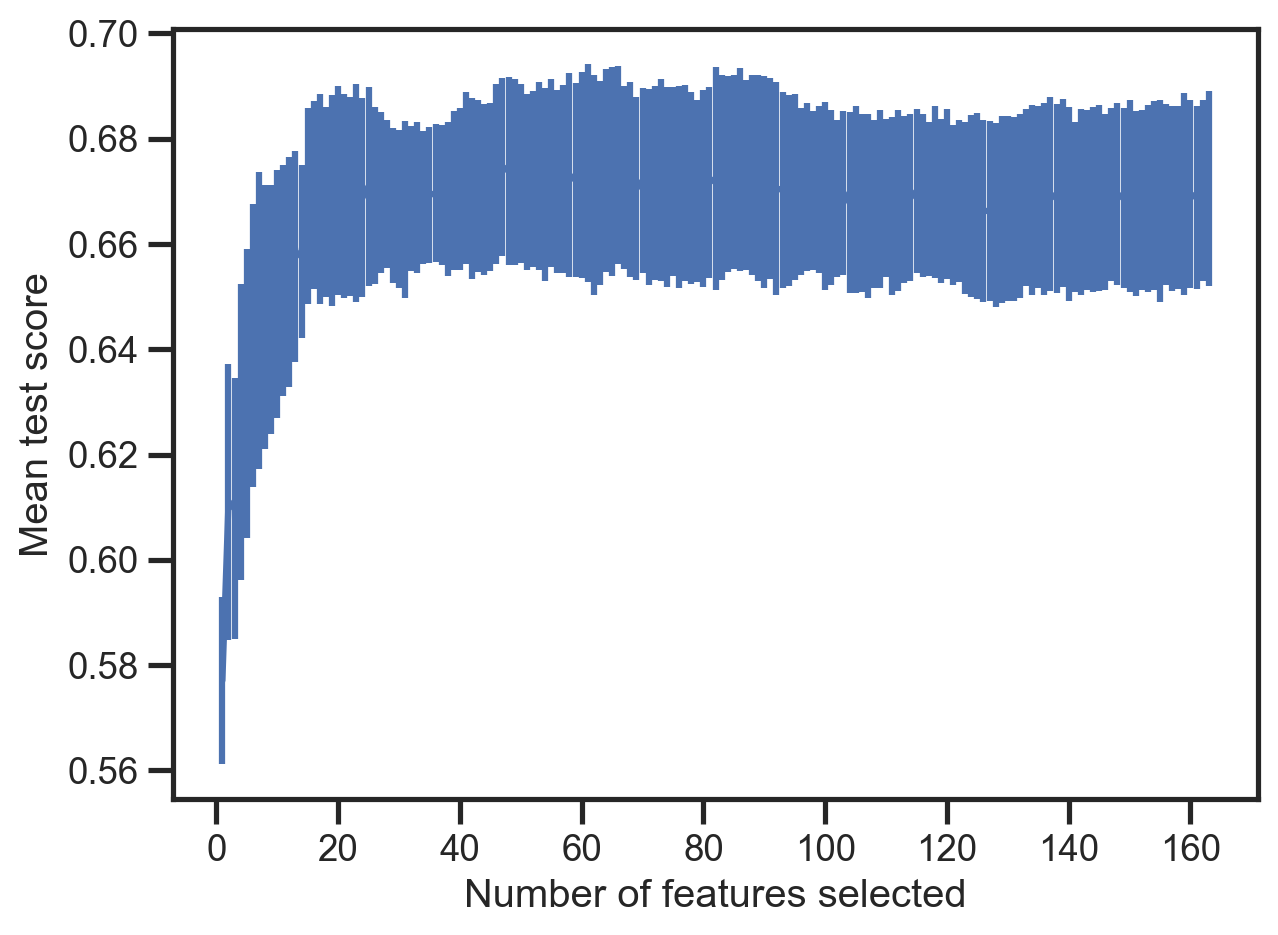

In [80]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    ref_selector2.cv_results_["mean_test_score"],
    yerr=ref_selector2.cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

In [81]:
pd.DataFrame(ref_selector2.cv_results_["mean_test_score"],range(1, n_scores+1)).sort_values(by=0,ascending=False).head()

0
66  0.674933
47  0.674667
86  0.674133
48  0.673867
64  0.673867

In [82]:
# Get the indices of the top performing features
top_features_idx = ref_selector2.get_support(indices=True)

# Get the names of the top performing features
top_features_names = X_train_preprocessed2.columns[top_features_idx]

# Print the top performing features
print("Top performing features:")
print(len(top_features_names))


Top performing features:
66


### Model fitting and prediction on top selected features by REFCV

In [83]:
result_refcv_full2 = model_selection(X_train_preprocessed2[top_features_names], X_test_preprocessed2[top_features_names], y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11669
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 66
[LightGBM] [Info] Start training from score -1.685599
[LightGBM] [Info] Start training from score -1.243869
[LightGBM] [Info] Start training from score -0.641694


In [84]:
result_refcv_full2.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc     acc  precision  \
4            extratree     1.000000      0.718330  0.7276   0.731654   
1        random_forest     1.000000      0.706943  0.7216   0.725390   
6                 lgbm     0.942267      0.696073  0.7156   0.718365   
2             catboost     0.941467      0.688573  0.7120   0.713664   
5                  xgb     0.997200      0.683636  0.7100   0.710425   
0  logistic_regression     0.688133      0.661705  0.6768   0.681193   
3          decisontree     1.000000      0.602006  0.6292   0.630136   

   time_taken  
4    1.921778  
1    6.414979  
6    2.652643  
2   41.709327  
5    4.436243  
0    0.542977  
3    0.613380

### Model fitting on top 66 selected features using SelectKbest

In [88]:
selector = SelectKBest(f_classif, k=66).fit(X_train_preprocessed2, y_train)
X_sel = selector.transform(X_train_preprocessed2)
auto_select = pd.DataFrame(X_sel, columns=selector.get_feature_names_out()).columns

In [89]:
auto_select = auto_select.tolist()

In [90]:
result_selectkbest2 = model_selection(X_train_preprocessed2[auto_select], X_test_preprocessed2[auto_select], y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13020
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 66
[LightGBM] [Info] Start training from score -1.685599
[LightGBM] [Info] Start training from score -1.243869
[LightGBM] [Info] Start training from score -0.641694


In [100]:
final_features = [i for i in top_features_names if i in auto_select]
final_features

['Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Delay_from_due_date',
 'Outstanding_Debt',
 'Credit_History_Age',
 'Age Annual_Income',
 'Age Num_Bank_Accounts',
 'Age Delay_from_due_date',
 'Annual_Income Credit_History_Age',
 'Num_Bank_Accounts Interest_Rate',
 'Num_Bank_Accounts Delay_from_due_date',
 'Num_Bank_Accounts Num_of_Delayed_Payment',
 'Num_Bank_Accounts Num_Credit_Inquiries',
 'Num_Bank_Accounts Outstanding_Debt',
 'Num_Bank_Accounts Credit_Utilization_Ratio',
 'Num_Credit_Card Interest_Rate',
 'Num_Credit_Card Delay_from_due_date',
 'Num_Credit_Card Num_of_Delayed_Payment',
 'Num_Credit_Card Num_Credit_Inquiries',
 'Num_Credit_Card Outstanding_Debt',
 'Interest_Rate Delay_from_due_date',
 'Interest_Rate Num_of_Delayed_Payment',
 'Interest_Rate Num_Credit_Inquiries',
 'Interest_Rate Outstanding_Debt',
 'Interest_Rate Credit_Utilization_Ratio',
 'Delay_from_due_date Num_of_Delayed_Payment',
 'Delay_from_due_date Num_Credit_Inquiries',
 'Delay_from_due_date Ou

In [101]:
result_selectkbest2.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc     acc  precision  \
4            extratree     1.000000      0.713706  0.7276   0.731507   
1        random_forest     1.000000      0.708067  0.7208   0.724984   
5                  xgb     0.996000      0.702819  0.7220   0.723158   
2             catboost     0.934533      0.687743  0.7100   0.711867   
6                 lgbm     0.942933      0.686013  0.7092   0.711109   
0  logistic_regression     0.681333      0.666996  0.6776   0.684153   
3          decisontree     1.000000      0.606301  0.6304   0.632085   

   time_taken  
4    2.478861  
1    7.663075  
5    3.824430  
2   31.932498  
6    1.213128  
0    0.376422  
3    0.735401

In [102]:
result_final_features = model_selection(X_train_preprocessed2[final_features], X_test_preprocessed2[final_features], y_train, y_test)
result_final_features.sort_values(by='precision',ascending=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7826
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 42
[LightGBM] [Info] Start training from score -1.685599
[LightGBM] [Info] Start training from score -1.243869
[LightGBM] [Info] Start training from score -0.641694


model  train_score  balanced_acc     acc  precision  \
4            extratree     1.000000      0.718233  0.7320   0.734581   
1        random_forest     1.000000      0.708970  0.7248   0.727876   
5                  xgb     0.993467      0.689215  0.7152   0.715860   
6                 lgbm     0.926133      0.686572  0.7112   0.712748   
2             catboost     0.925067      0.688259  0.7100   0.711037   
0  logistic_regression     0.681467      0.673914  0.6820   0.689497   
3          decisontree     1.000000      0.607916  0.6296   0.631044   

   time_taken  
4    1.258273  
1    4.847294  
5    1.229512  
6    0.780838  
2   16.116024  
0    0.310007  
3    0.356910

Precision Improved by about **2%** after reducing the categories in the `Type of Loan` column.

Let's check and handle outliers

# Check and Handle Outliers

In [103]:
def plot_boxplot(col):
    """
    Returns a boxplot of a single feature
        col: The column of interest
    """
    plt.figure(figsize=(8, 5))
    feature = df[col]
    sns.boxplot(data=df, x=feature)
    plt.title(col)    
    plt.show()

In [104]:
def plot_boxplots(cols):
    """
    Returns a box plots of all features in the cols list:
        col: The column of interest
    """
    for col in cols:
        plt.figure(figsize=(8, 5))
        feature = df[col]
        sns.boxplot(data=df, x=feature)
        plt.title(col)    
        plt.show()

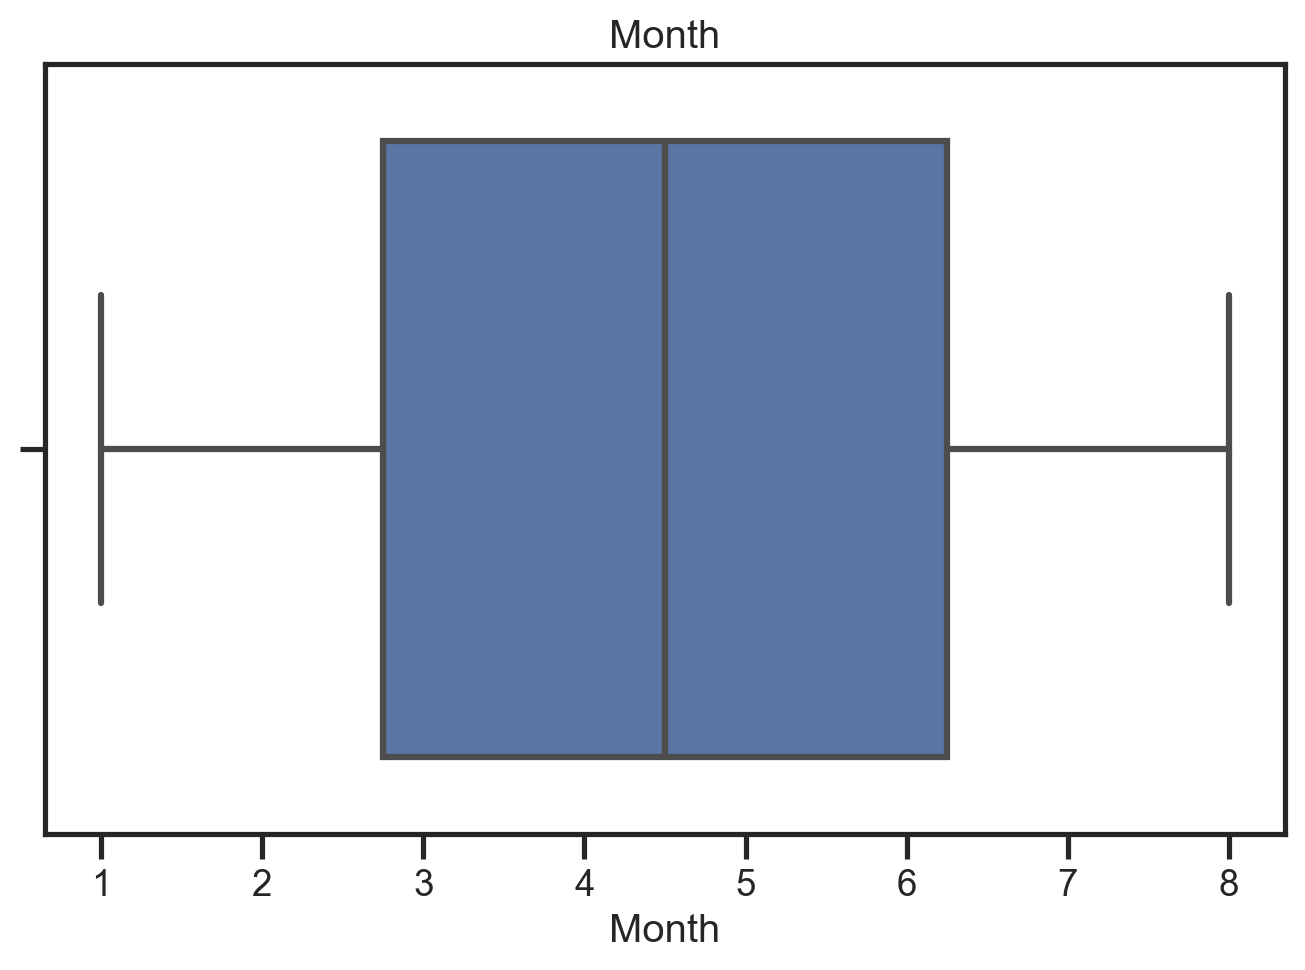

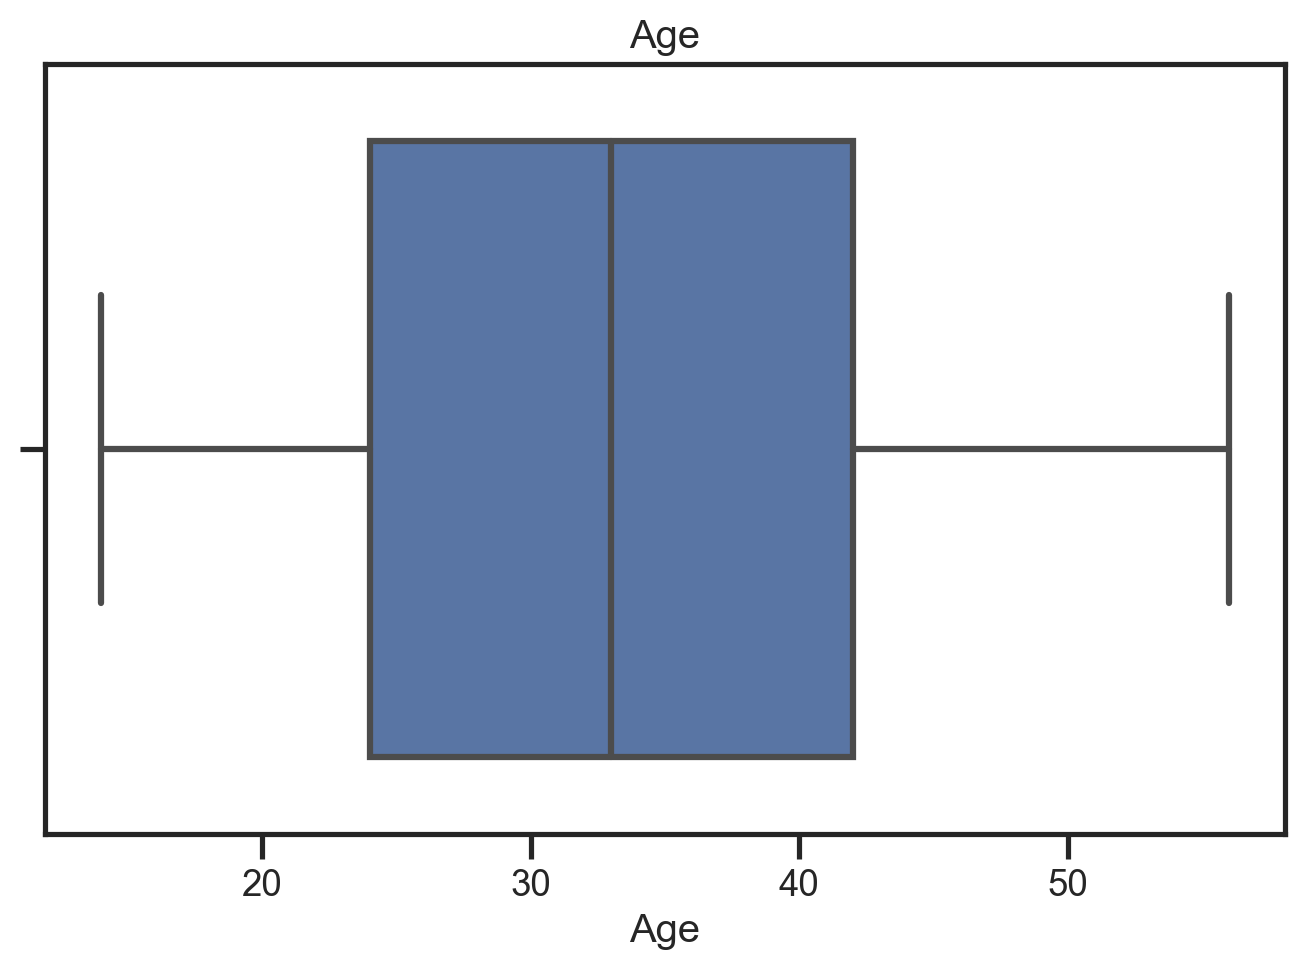

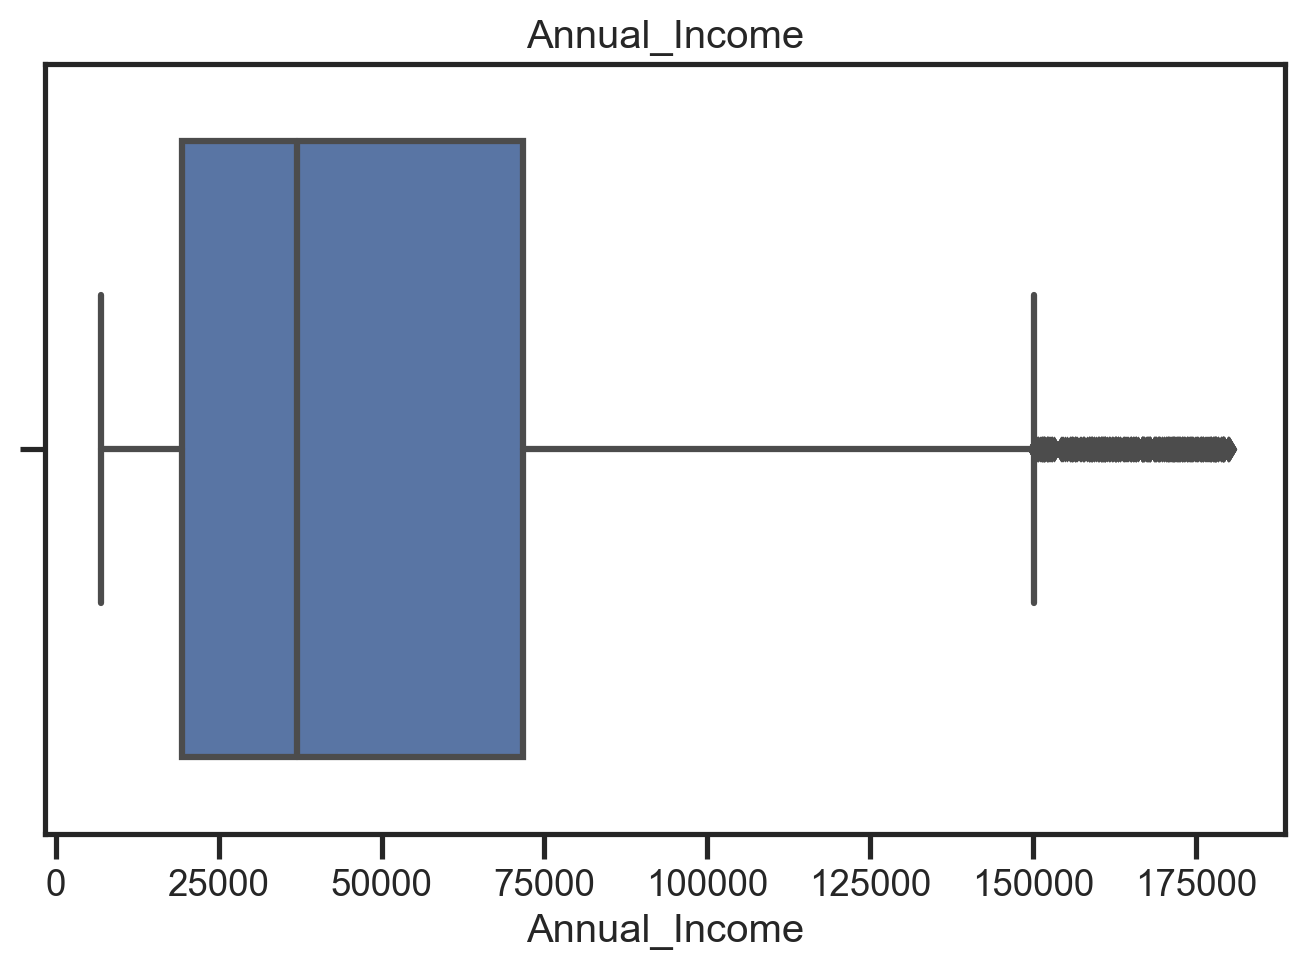

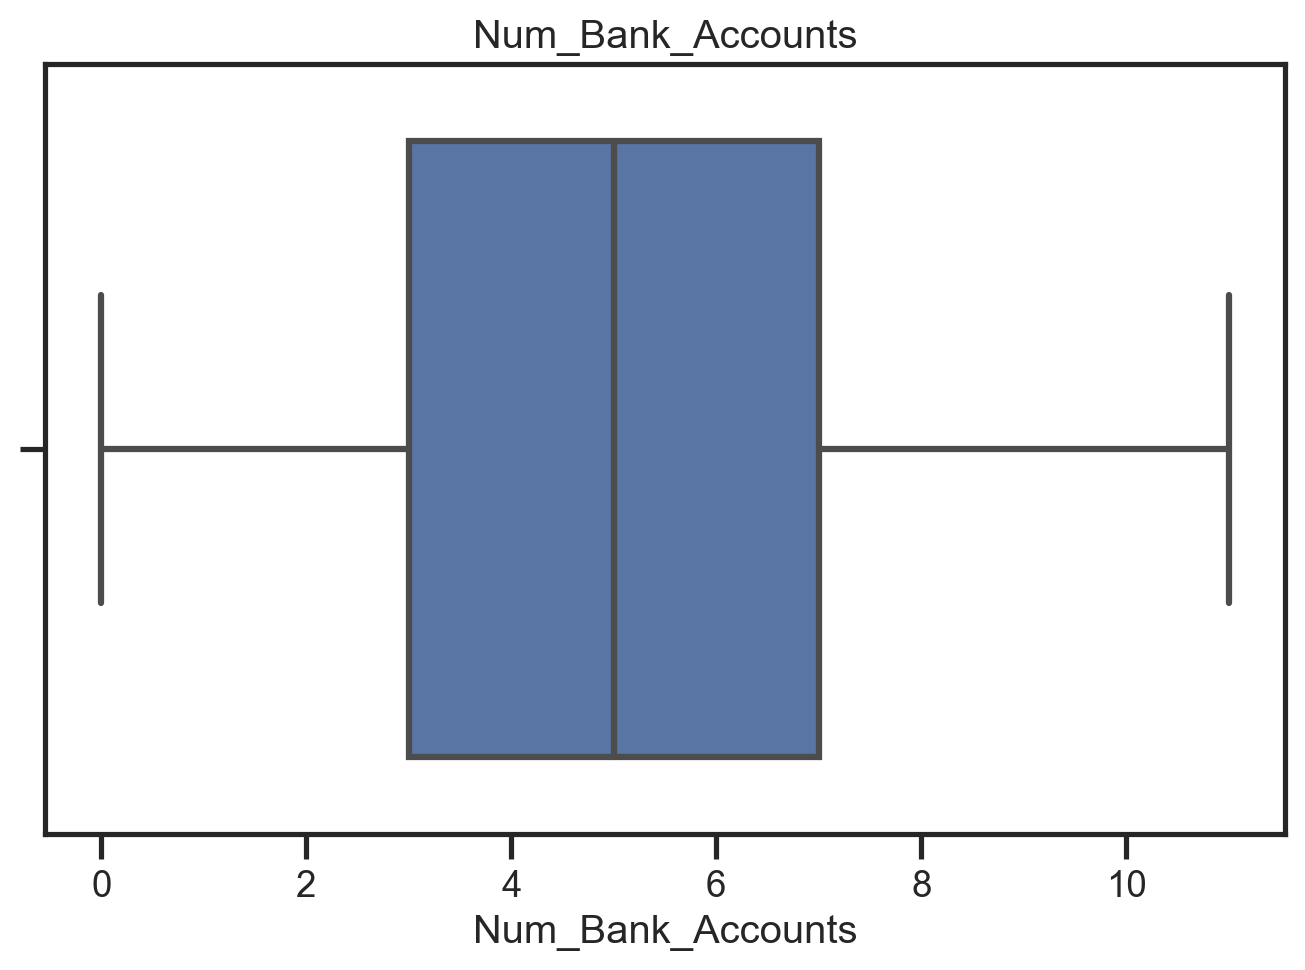

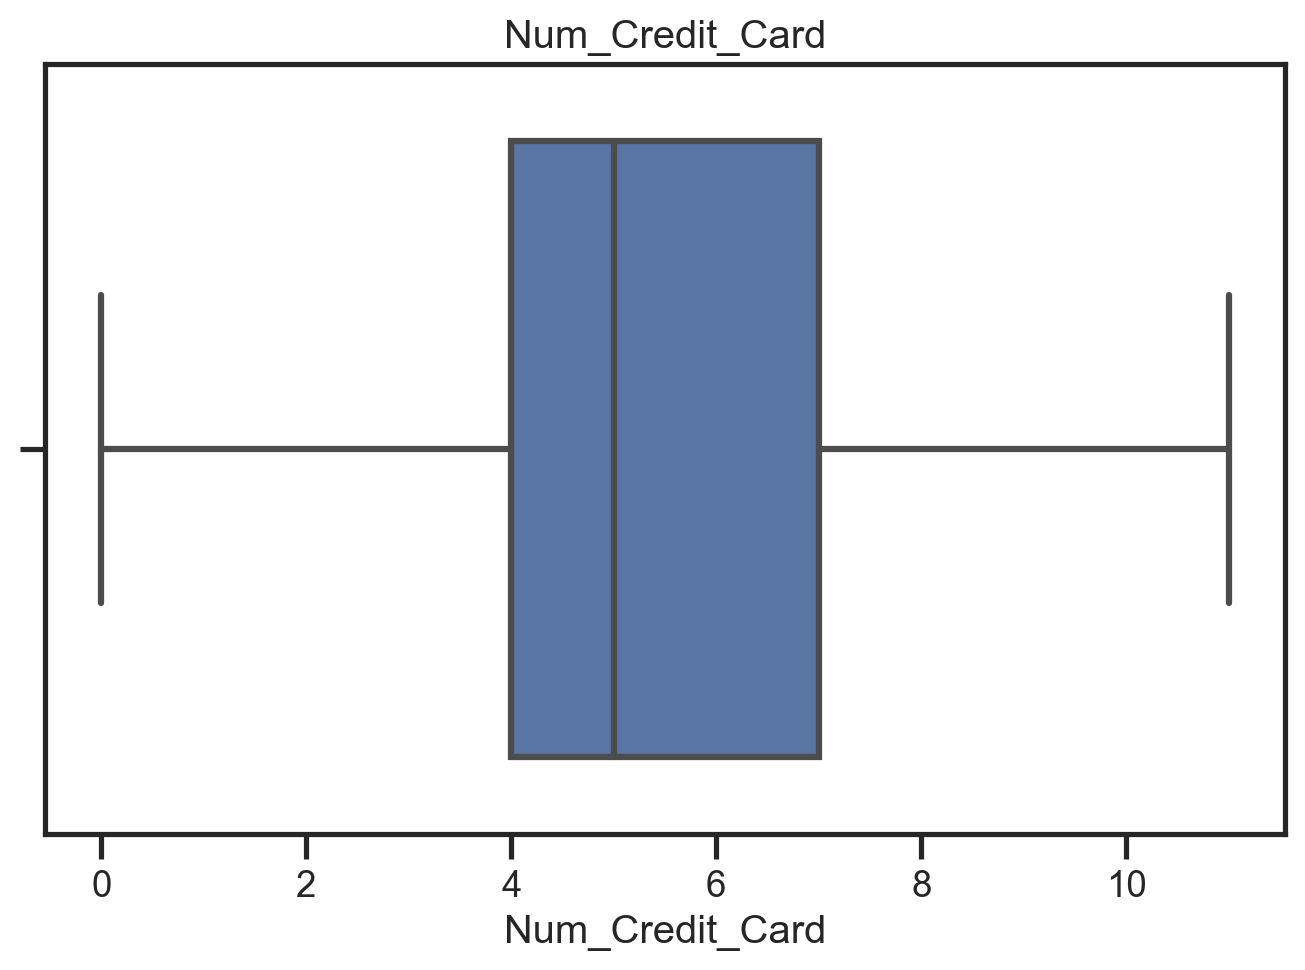

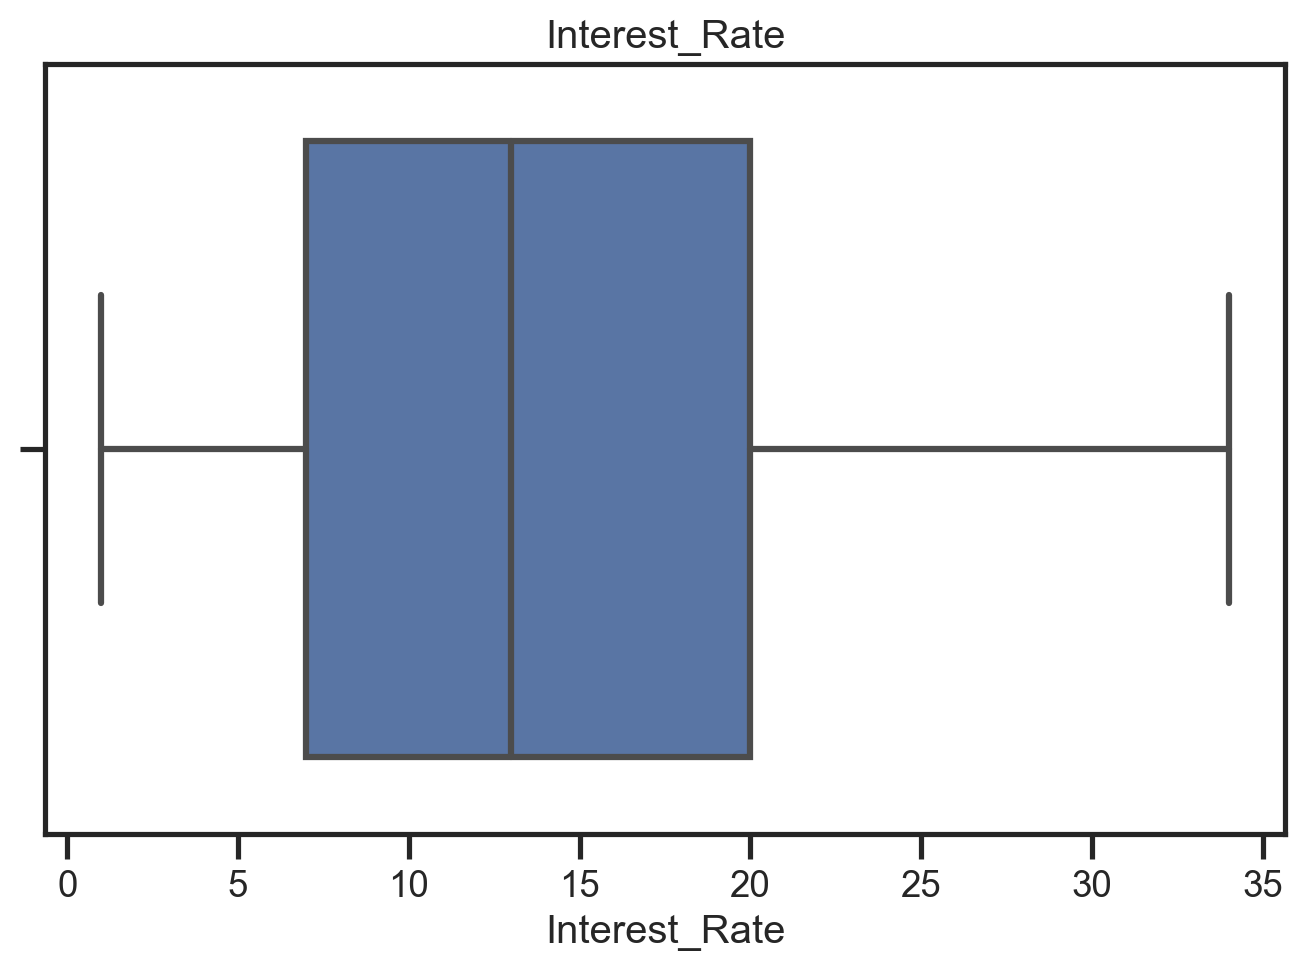

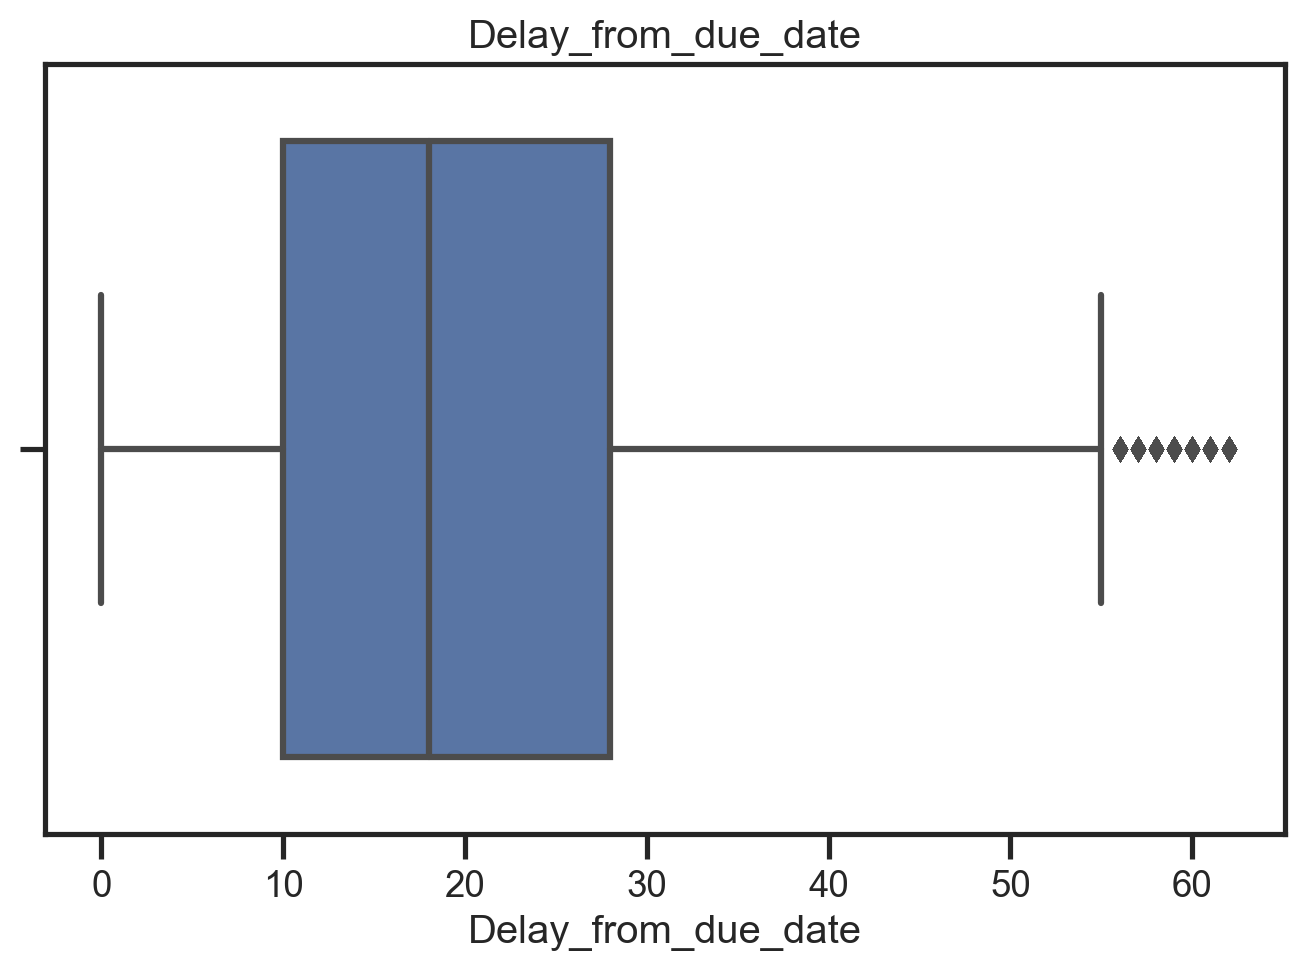

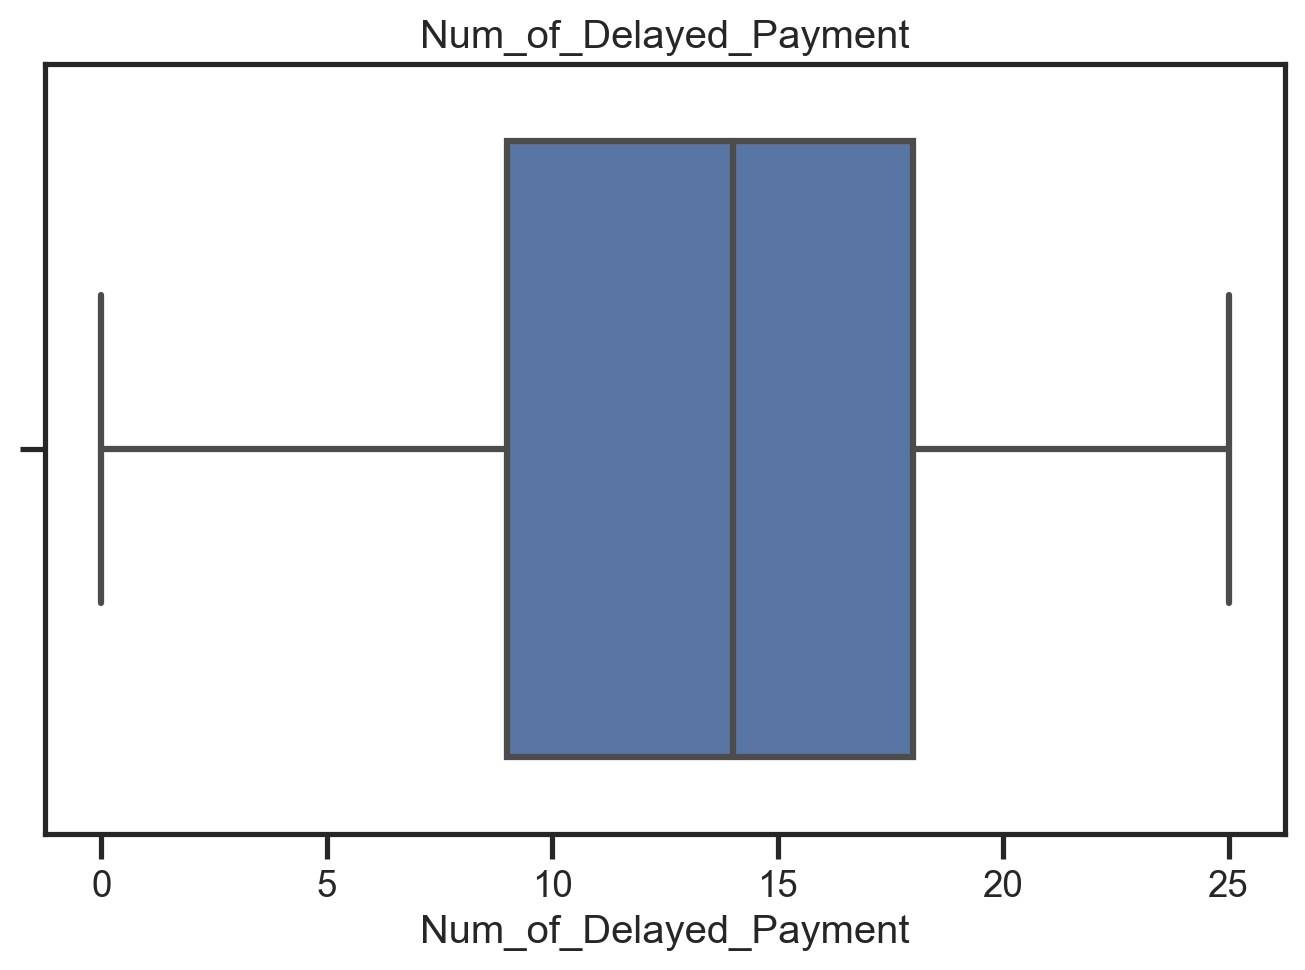

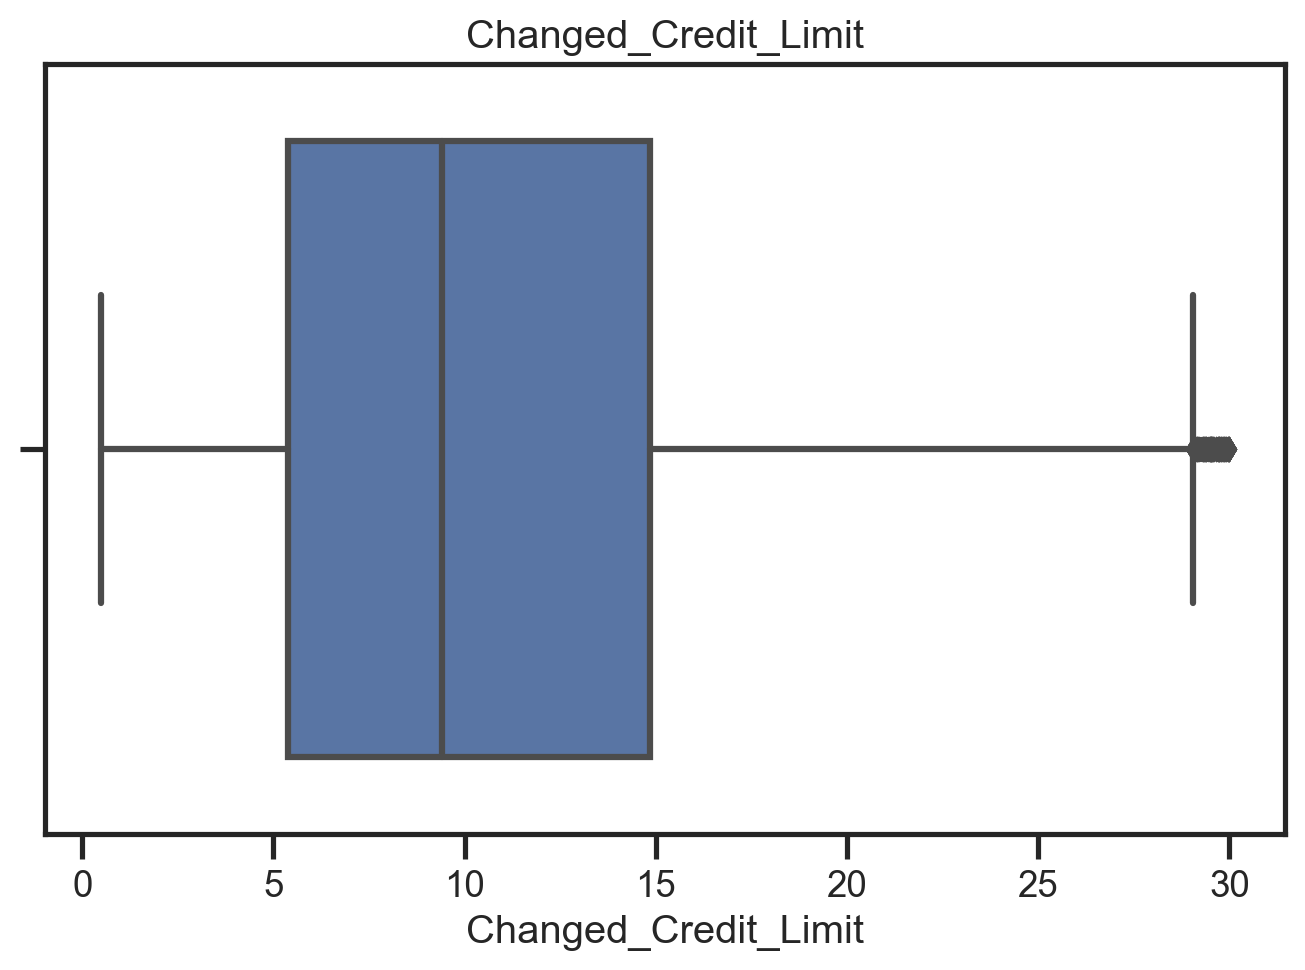

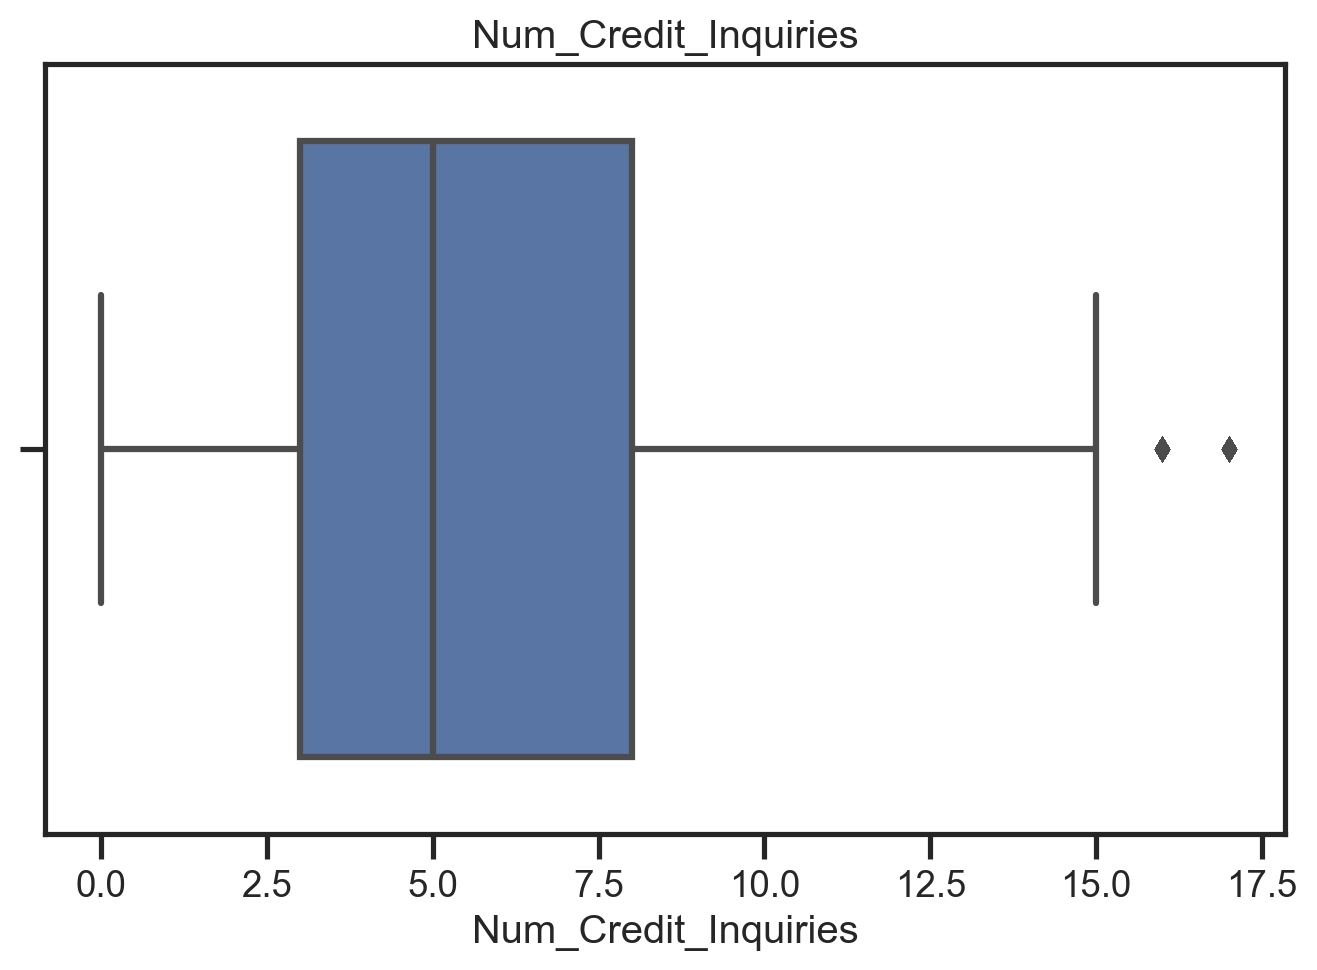

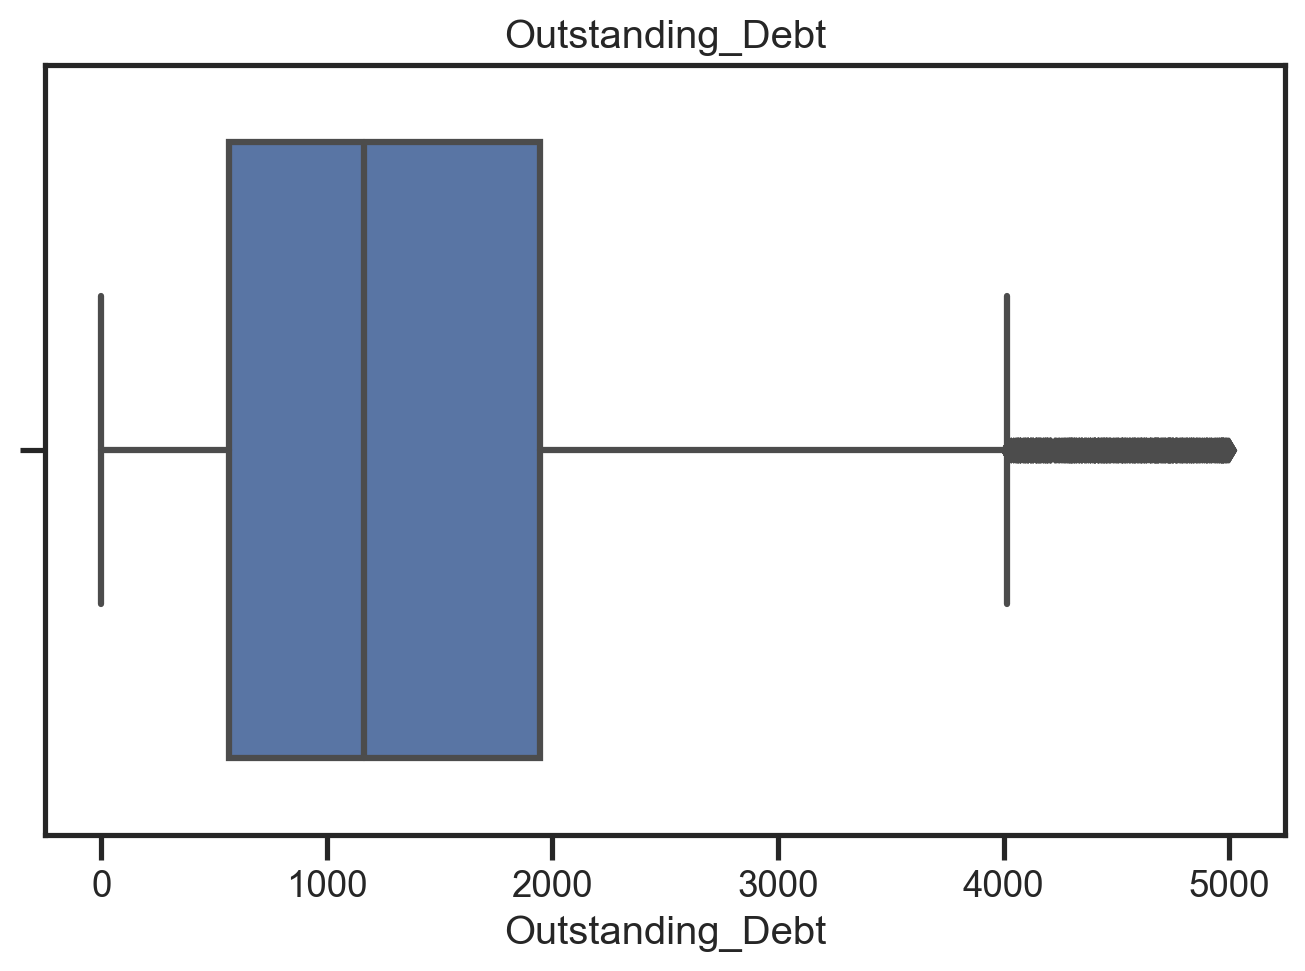

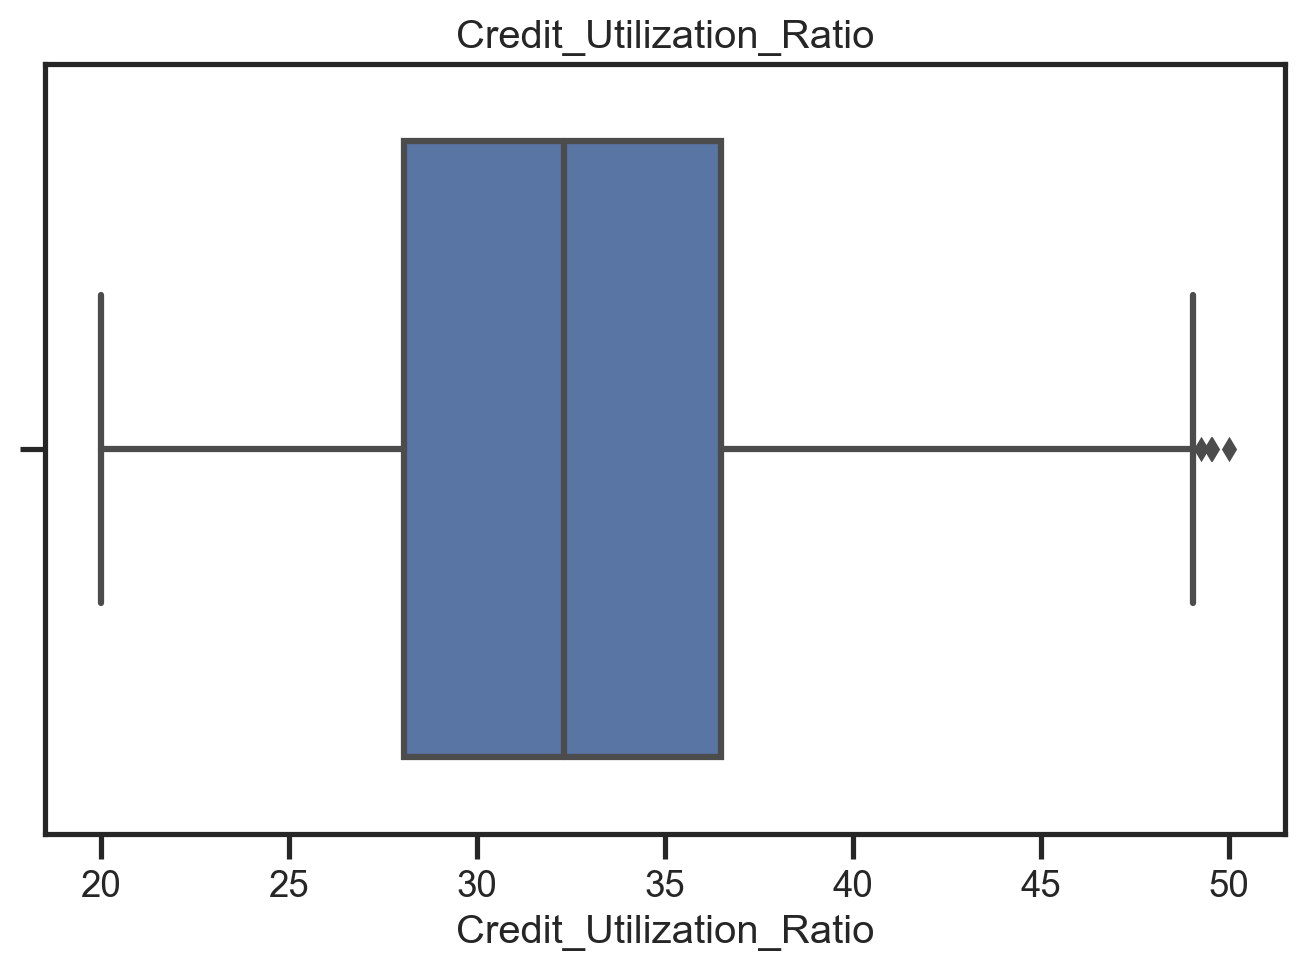

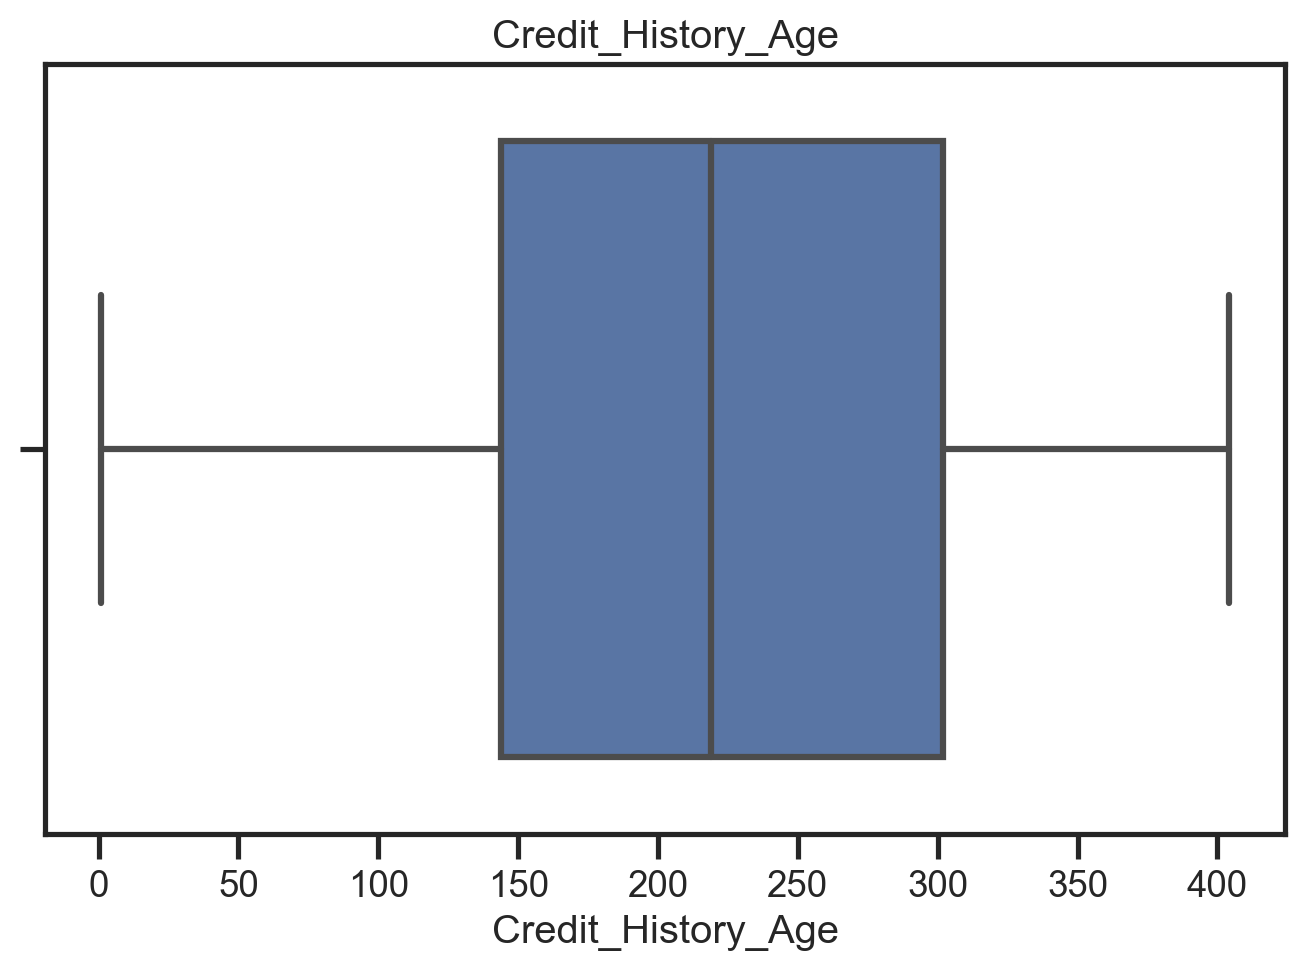

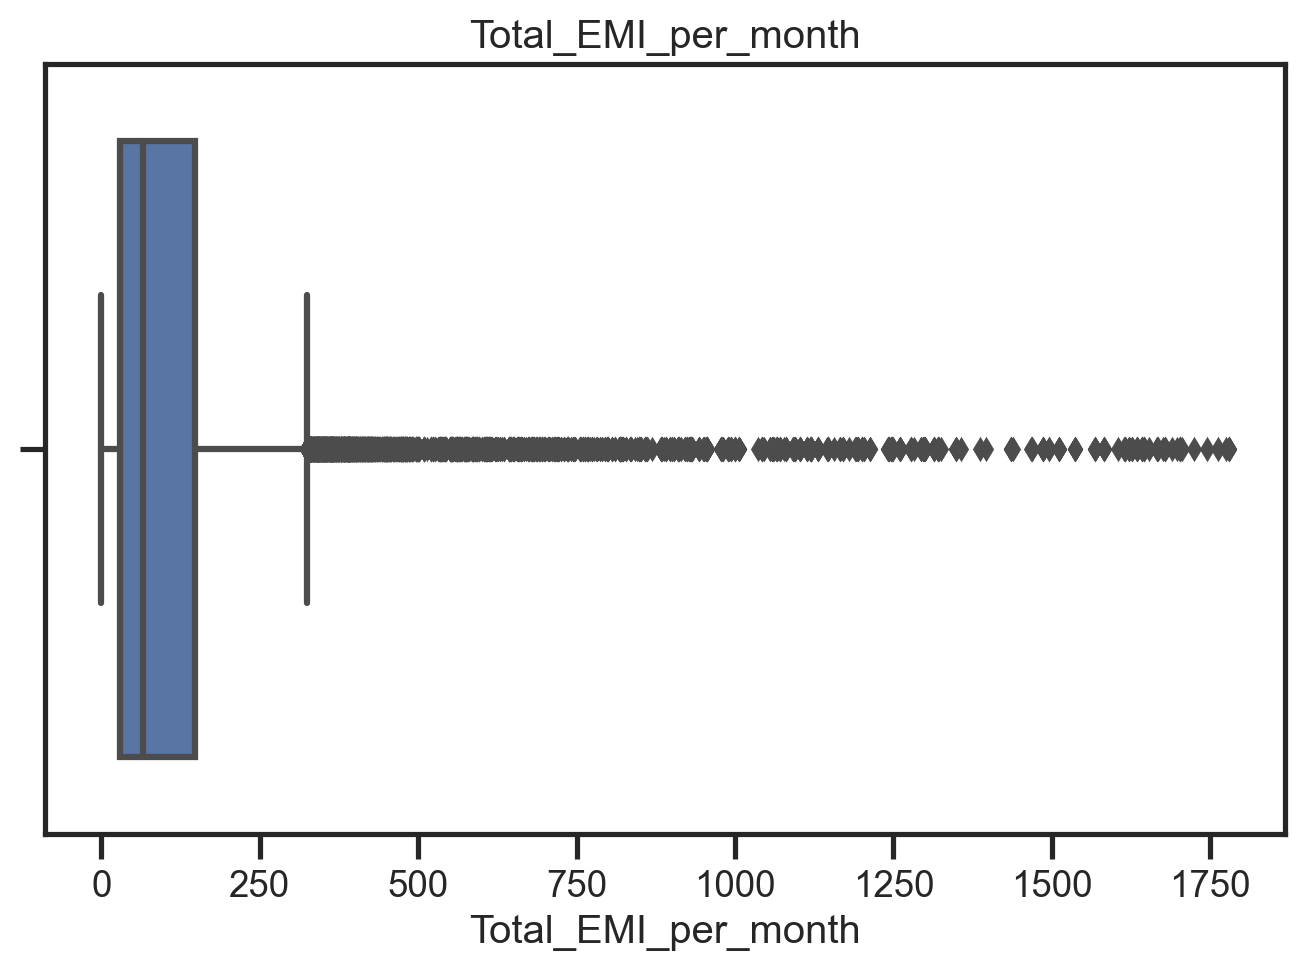

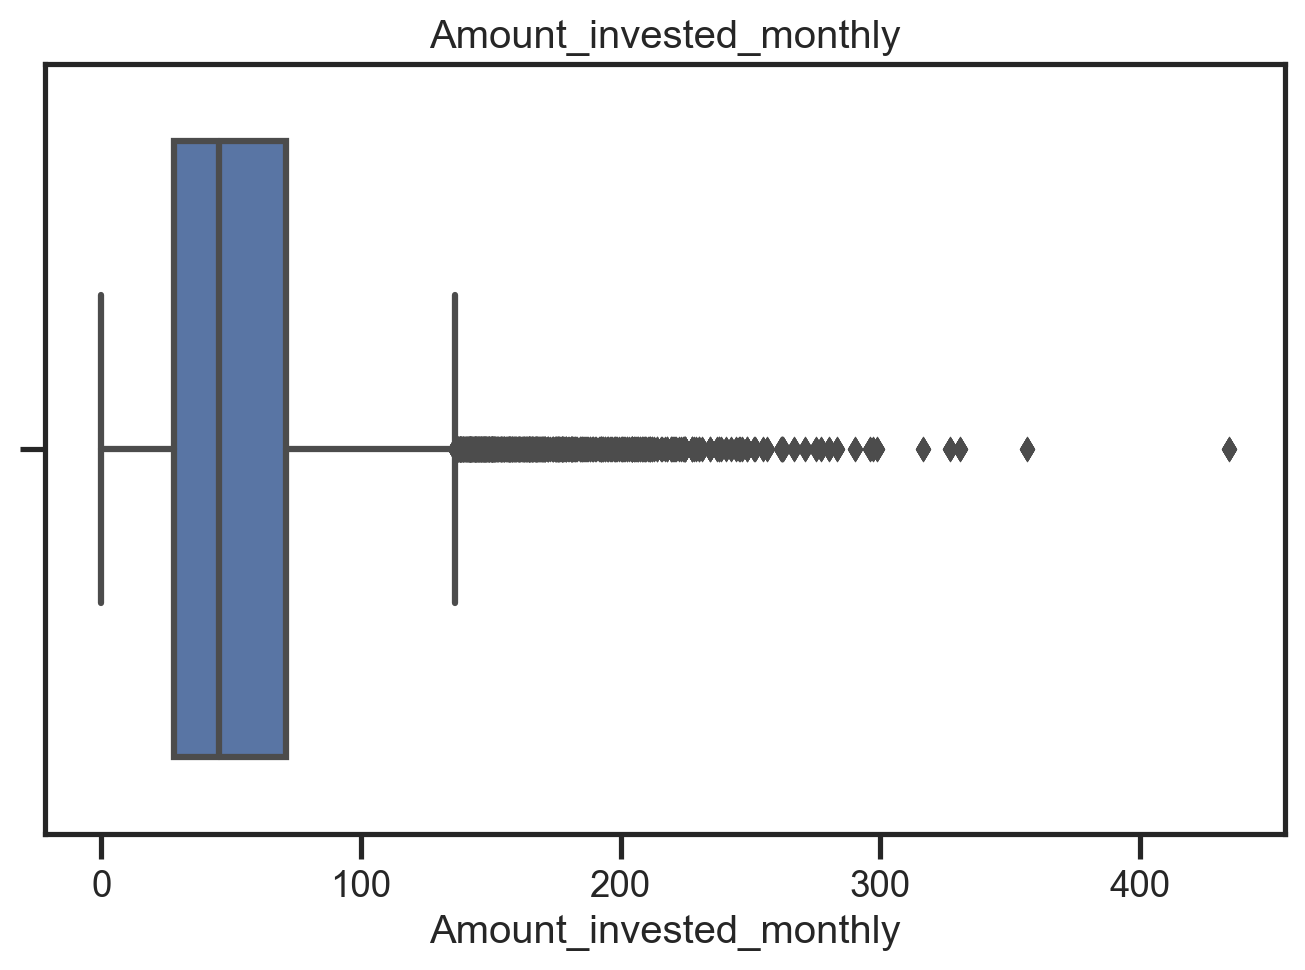

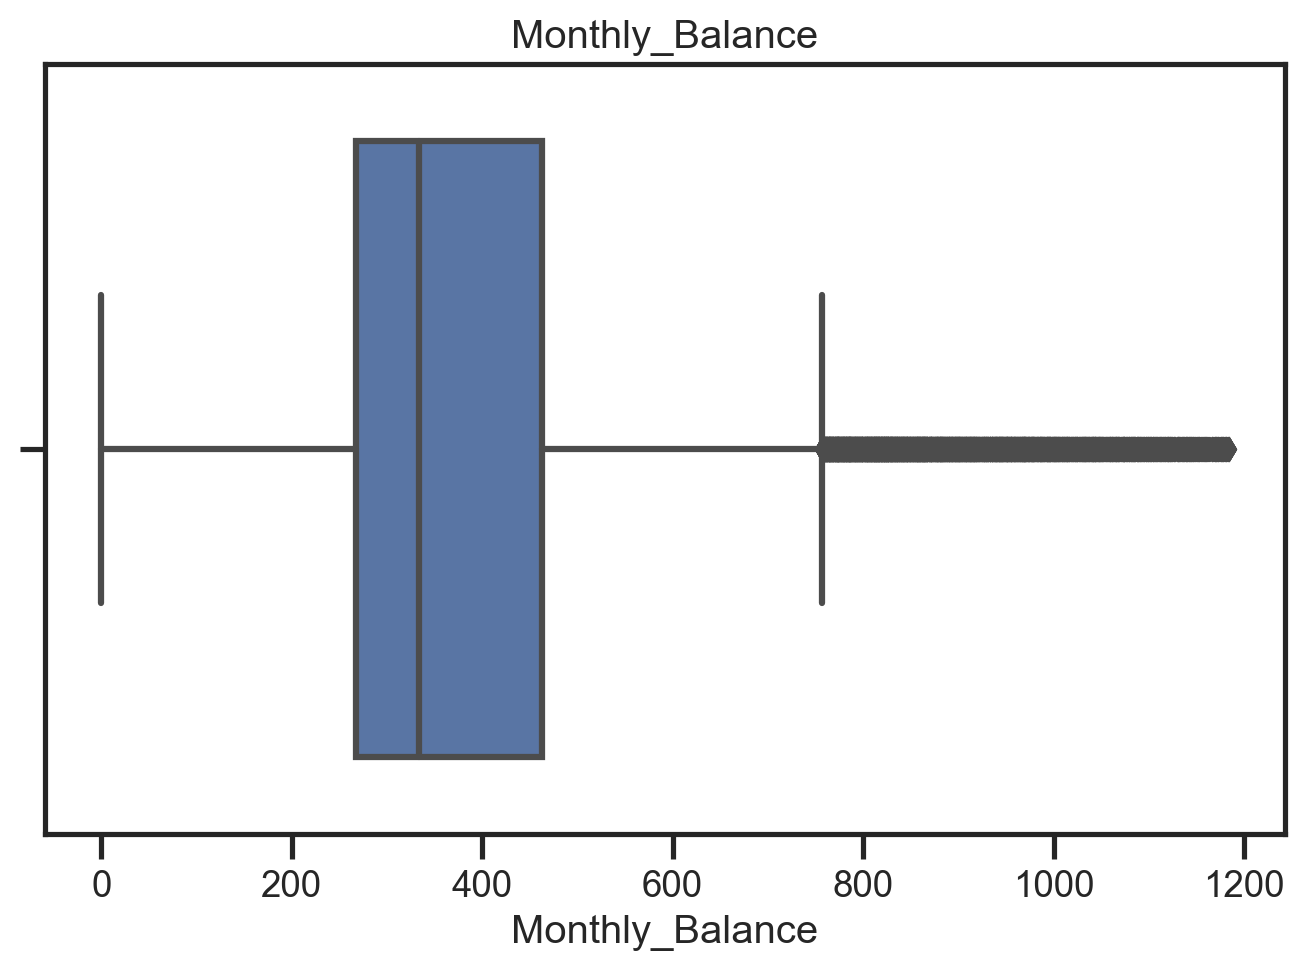

In [105]:
# Month
plot_boxplots(num_feat)

Some features have outliers in them while others don't. However, the last 5/6 features are categorical features with 1 for True and 0 for False

We will only treat the features with outliers that seems to have some effect on credit score

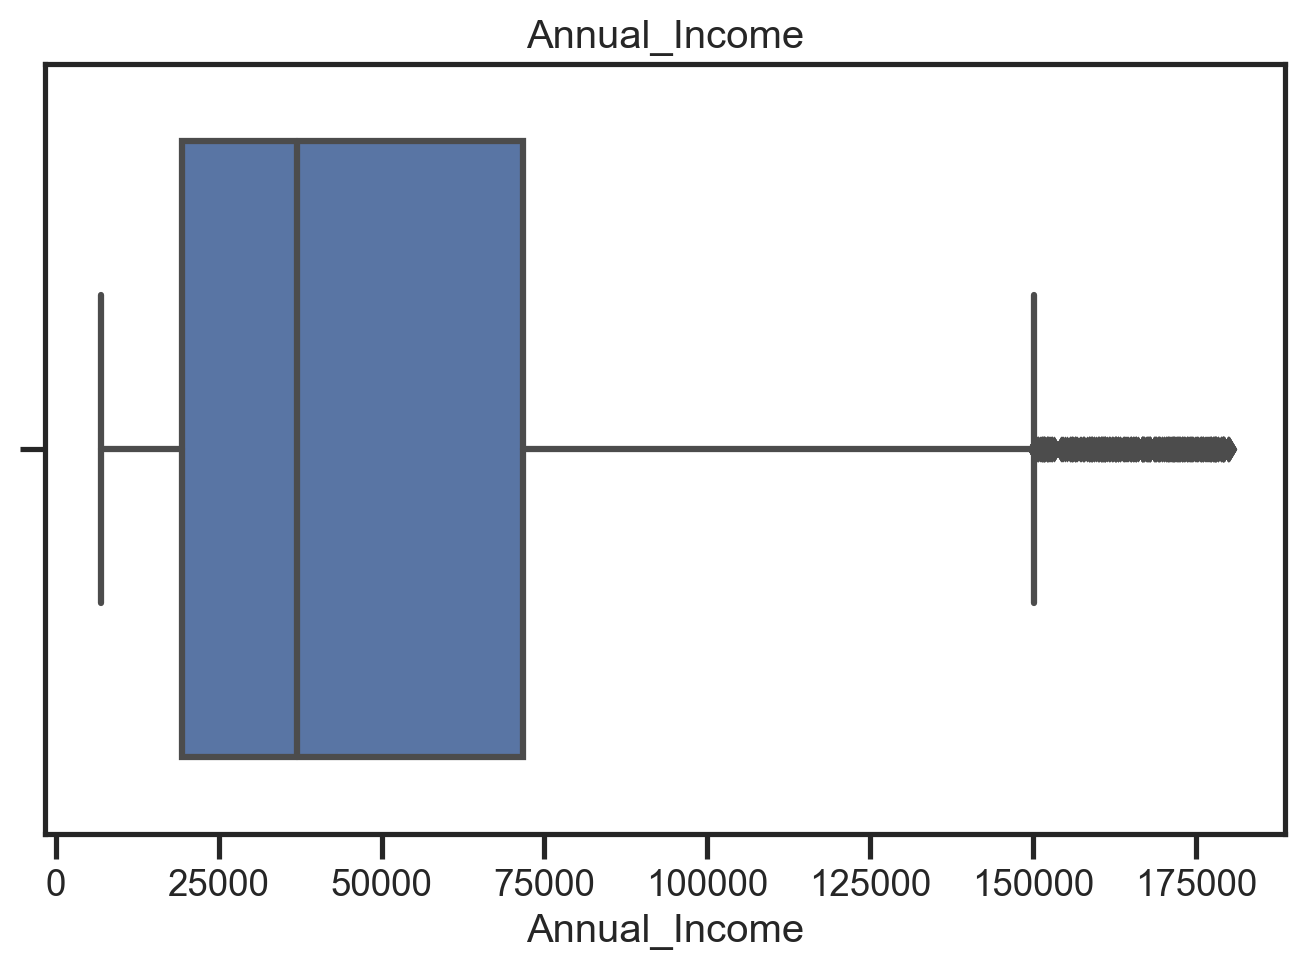

In [106]:
# Annual Income
plot_boxplot("Annual_Income")

In [107]:
q1 = np.percentile(df['Annual_Income'],25)
q3 = np.percentile(df['Annual_Income'], 75)

iqr = q3 - q1 
iqr

52340.4975

In [108]:
lwr = q1 - (iqr * 1.5)
upr = q3 + (iqr * 1.5)
lwr, upr

(-59167.77374999999, 150194.21625)

In [109]:
len(df['Annual_Income'])

100000

In [110]:
df = df[df['Annual_Income'].between(lwr, upr)]
df.shape

(98000, 30)

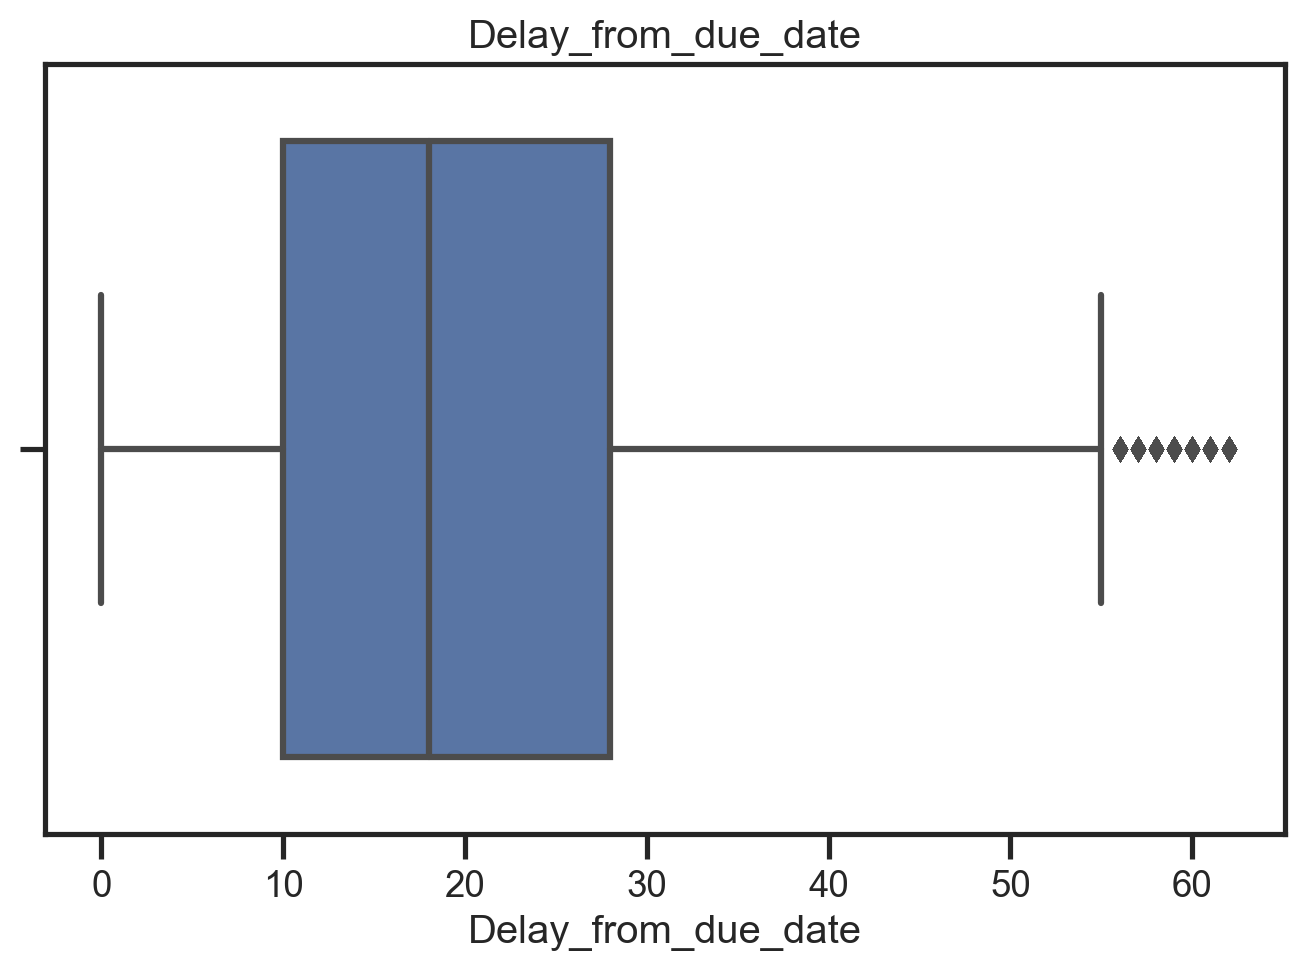

In [111]:
# DElay from due date
plot_boxplot("Delay_from_due_date")

In [112]:
def check_lwr_upr(col):
    q1 = np.percentile(df[col],25)
    q3 = np.percentile(df[col], 75)

    iqr = q3 - q1 

    lwr = q1 - (iqr * 1.5)
    upr = q3 + (iqr * 1.5)
    return lwr, upr

In [113]:
lwr,upr = check_lwr_upr("Delay_from_due_date")
print(df.shape)
df = df[df['Delay_from_due_date'].between(lwr,upr)]
print(df.shape)

(98000, 30)
(93998, 30)


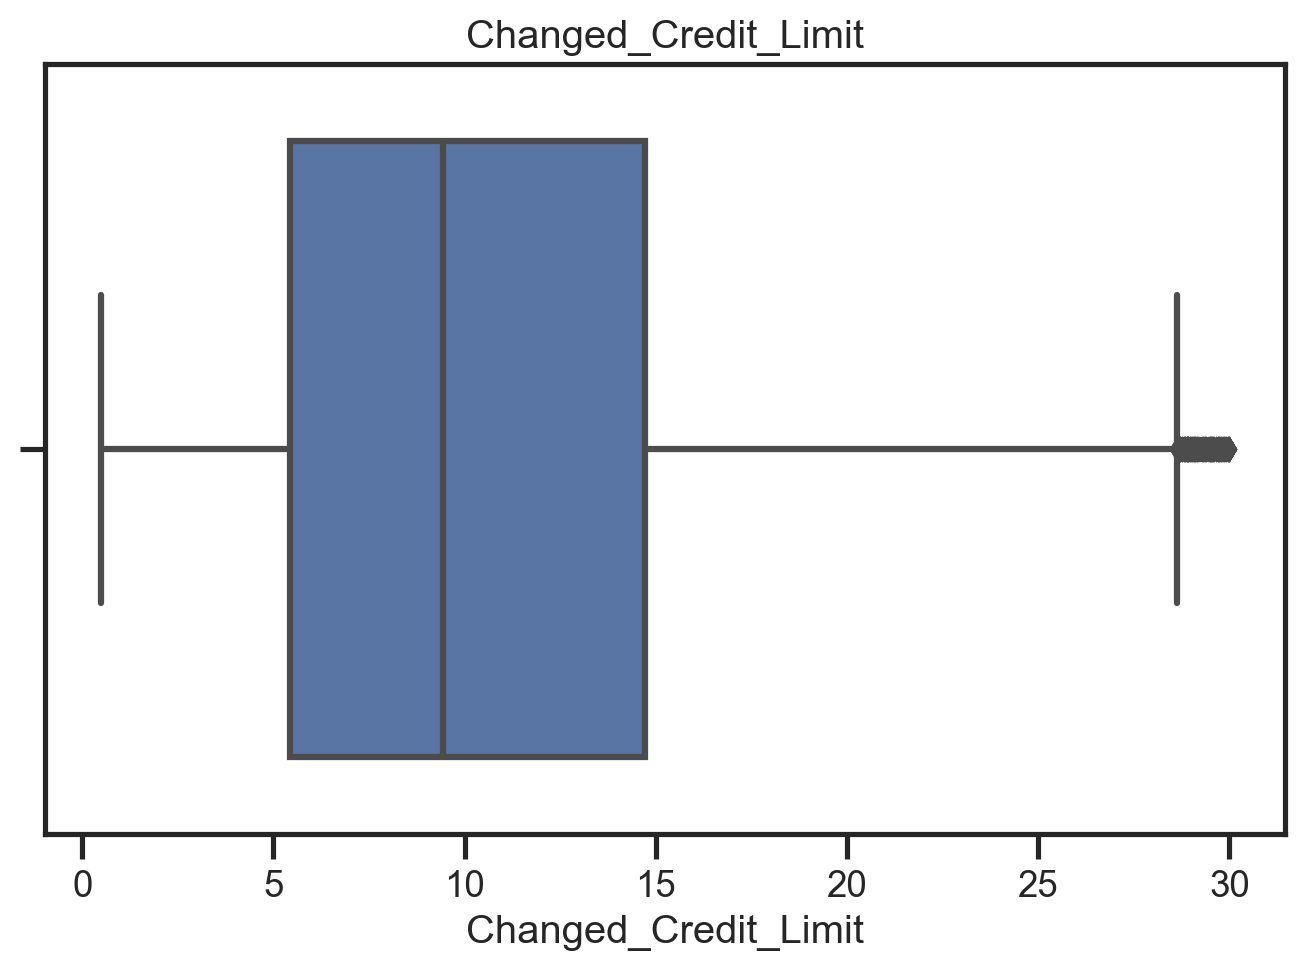

In [114]:
# changed credit limt
plot_boxplot("Changed_Credit_Limit")

In [115]:
lwr, upr = check_lwr_upr("Changed_Credit_Limit")
print(df.shape)
df = df[df['Changed_Credit_Limit'].between(lwr,upr)]
print(df.shape)

(93998, 30)
(93137, 30)


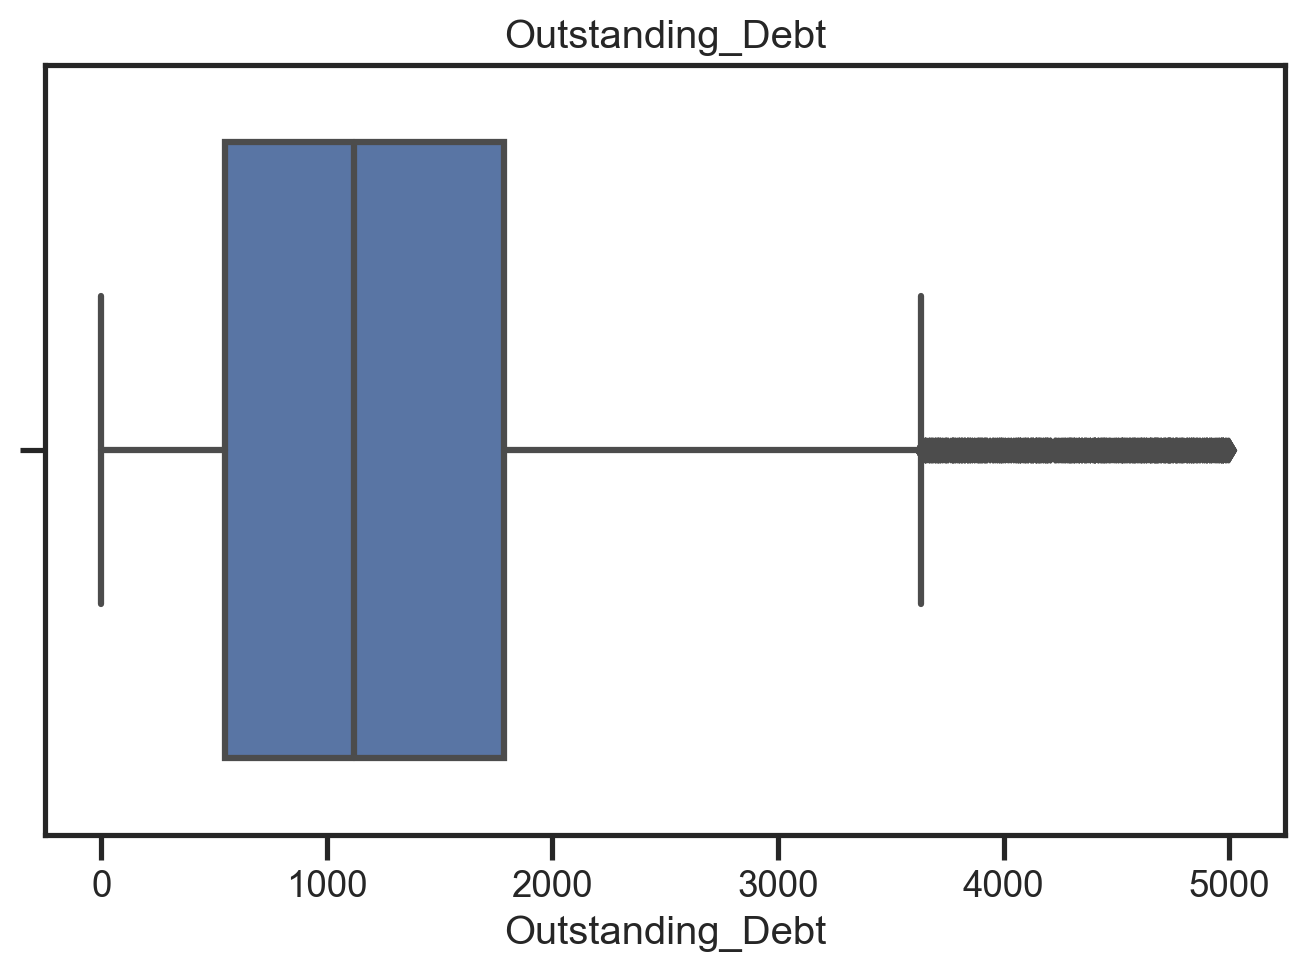

In [116]:
# Outstanding debts
plot_boxplot('Outstanding_Debt')

In [117]:
lwr,upr = check_lwr_upr('Outstanding_Debt')
lwr,upr

(-1304.06, 3639.7799999999997)

In [118]:
print(df.shape)
df = df[df['Outstanding_Debt'].between(lwr,upr)]
print(df.shape)

(93137, 30)
(87296, 30)


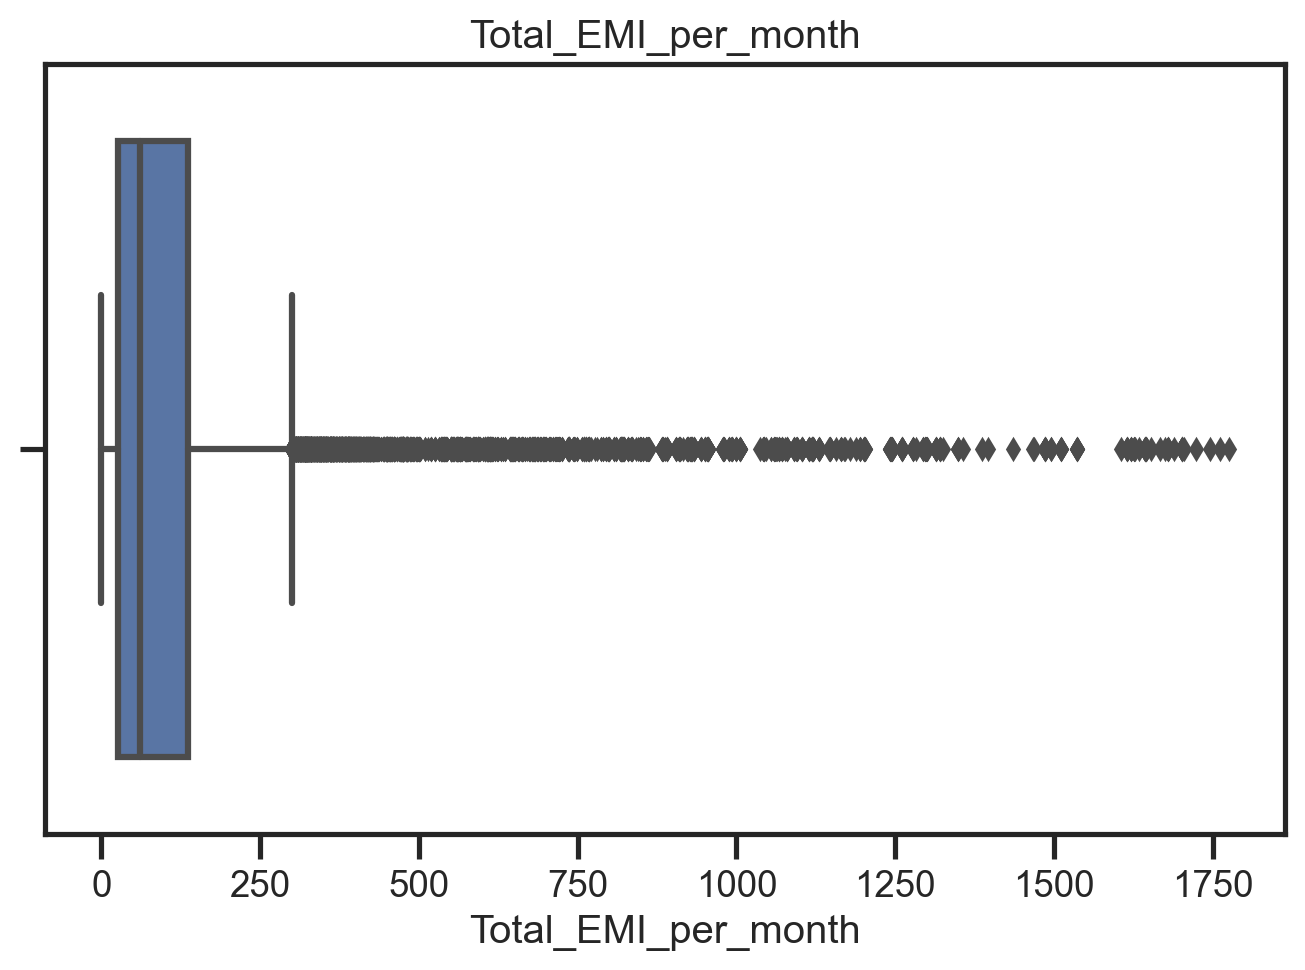

In [119]:
# Total EMI per month
plot_boxplot('Total_EMI_per_month')

In [129]:
df.query("Total_EMI_per_month>1000")[['Age','Occupation','Type_of_Loan','Annual_Income','Num_Bank_Accounts','Total_EMI_per_month']].sort_values(by='Total_EMI_per_month',ascending=False)[:20]

Age Occupation                                       Type_of_Loan  \
ID                                                                           
132505  37.0   Musician                                      Not Specified   
71316   15.0  Scientist  Payday Loan, Personal Loan, Mortgage Loan,  Au...   
112629  19.0  Scientist  Credit-Builder Loan, Debt Consolidation Loan, ...   
149072  20.0     Writer                                      Mortgage Loan   
35790   27.0  Architect                                      Not Specified   
132983  41.0     Lawyer  Home Equity Loan, Debt Consolidation Loan, Pay...   
73664   41.0  Architect                        Not Specified,  Payday Loan   
73668   41.0  Architect                        Not Specified,  Payday Loan   
73667   41.0  Architect                        Not Specified,  Payday Loan   
73666   41.0  Architect                        Not Specified,  Payday Loan   
73665   41.0  Architect                        Not Specified,  Payday Loan   
73663   41.0  Architect                        Not Specified,  Payday Loan   
73669   42.0  Architect                        Not Specified,  Payday Loan   
137869  31.0   Mechanic  Auto Loan, Debt Consolidation Loan, Credit-Bui...   
24935   35.0  Scientist                                      Not Specified   
24936   35.0  Scientist                                      Not Specified   
24934   35.0  Scientist                                      Not Specified   
24937   35.0  Scientist                                      Not Specified   
24933   35.0  Scientist                                      Not Specified   
102707  33.0  Architect                                      Not Specified   

        Annual_Income  Num_Bank_Accounts  Total_EMI_per_month  
ID                                                             
132505     109655.250                1.0          1775.000000  
71316       61707.720               10.0          1762.000000  
112629       7423.970                5.0          1745.000000  
149072      16994.670                4.0          1724.000000  
35790       42796.520                4.0          1705.000000  
132983       8089.415                6.0          1702.000000  
73664      142001.120                7.0          1701.955013  
73668      142001.120                7.0          1701.955013  
73667      142001.120                7.0          1701.955013  
73666      142001.120                7.0          1701.955013  
73665      142001.120                7.0          1701.955013  
73663      142001.120                7.0          1701.955013  
73669      142001.120                7.0          1701.955013  
137869      10277.190                4.0          1689.000000  
24935      134737.590                1.0          1679.017067  
24936      134737.590                1.0          1679.017067  
24934      134737.590                1.0          1679.017067  
24937      134737.590                1.0          1679.017067  
24933      134737.590                1.0          1679.017067  
102707      43995.490                4.0          1675.000000

Outliers in `Total_EMI_per_month` wont' be removed because it doesn't really affect ones credit score

**NOTE** Insight was gotten from the EDA notebook

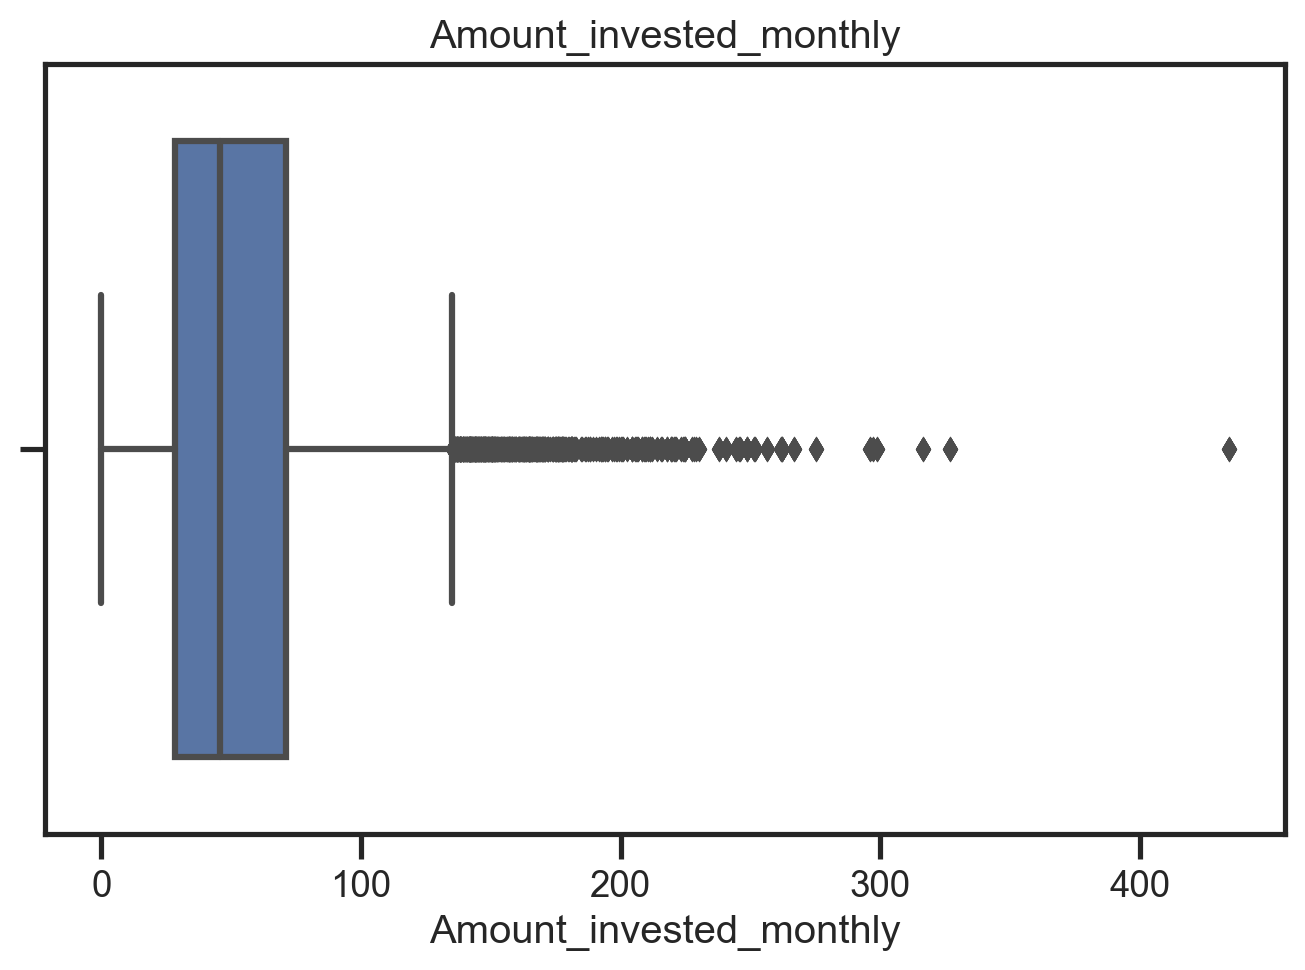

In [130]:
# Amount invested monthly
plot_boxplot('Amount_invested_monthly')

Amount invested monthly doesn't also seem to affect credit score that much. however, let's check the exception of that point above 400

In [131]:
df.query("Amount_invested_monthly>350")[['Annual_Income','Amount_invested_monthly']]

Annual_Income  Amount_invested_monthly
ID                                           
30738       136386.2               434.191089
30739       136386.2               434.191089
30740       136386.2               434.191089
30741       136386.2               434.191089
30742       136386.2               434.191089
30743       136386.2               434.191089
30744       136386.2               434.191089
30745       136386.2               434.191089

In [132]:
df = df.query('Amount_invested_monthly<350')
df.shape

(87288, 30)

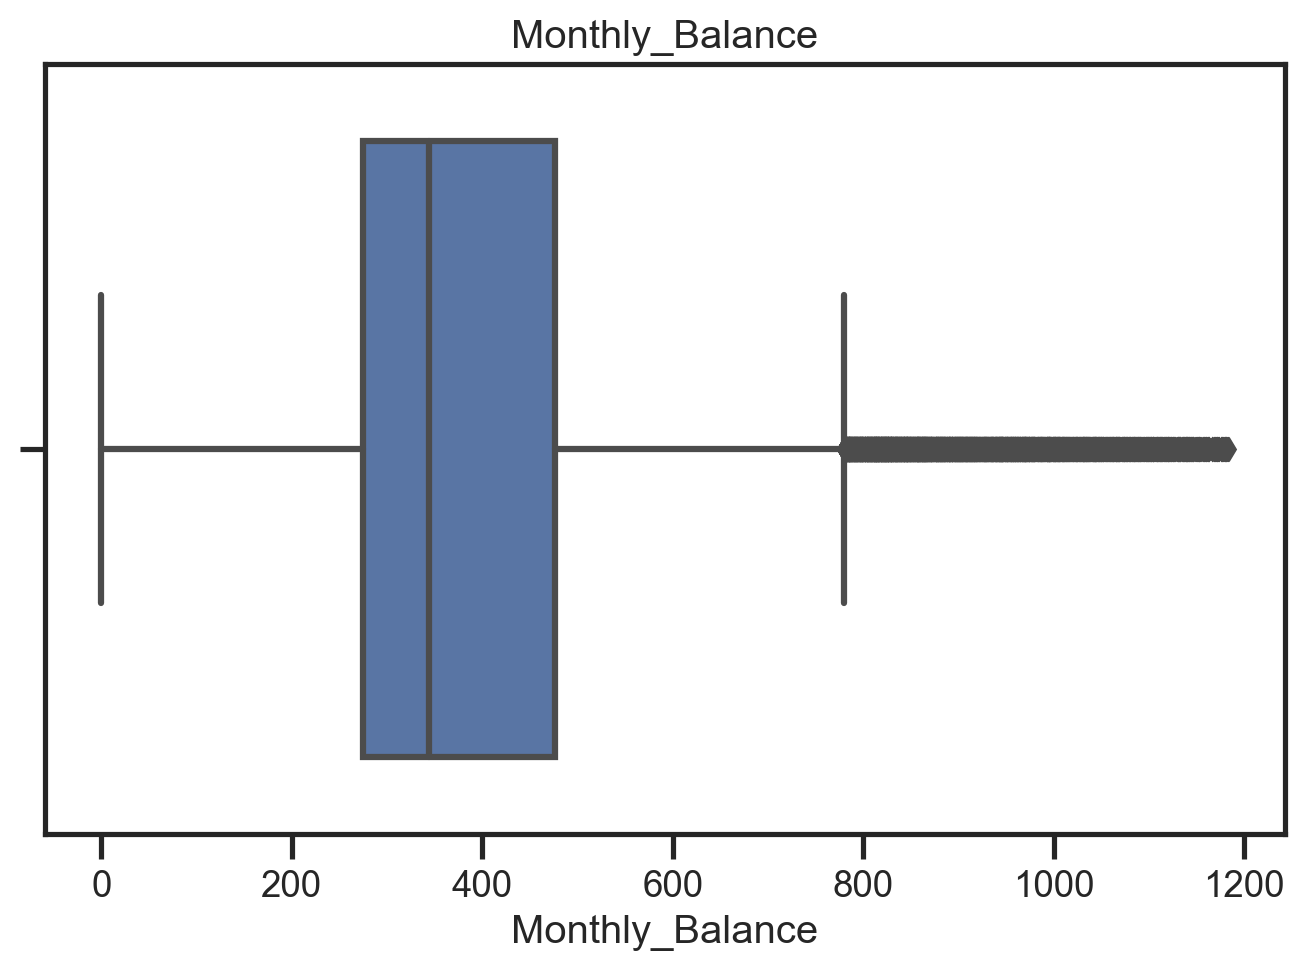

In [133]:
# monthly balance
plot_boxplot('Monthly_Balance')

In [134]:
df.columns

Index(['Month', 'Age', 'Occupation', 'Annual_Income', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score', 'CreditBuilder', 'Personal', 'DebtConsolidation',
       'Student', 'Payday', 'Mortgage', 'Auto', 'HomeEquity'],
      dtype='object')

In [135]:
(df.query('Monthly_Balance>770')
    [['Annual_Income','Amount_invested_monthly','Total_EMI_per_month','Credit_Mix','Monthly_Balance']]
    .sort_values(by='Monthly_Balance', ascending=False)
    ['Credit_Mix'].value_counts()
)

Good        3572
Standard    2526
Name: Credit_Mix, dtype: int64

Having a high monthly balance in your account at the end of the month have a positive effect on your credit score.

### Outliers have been handles to the best of our knowledge and insights gotten from the data exploration

In [136]:
df.shape

(87288, 30)

In [137]:
df_sample = df.sample(frac=0.1, random_state=seed)
df_sample.shape

(8729, 30)

In [138]:
# using the whole dataset
X, y = df_sample.drop(columns=['Credit_Score', 'Type_of_Loan']),df_sample['Credit_Score']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=seed)

In [139]:
X_train.head()

Month   Age  Occupation  Annual_Income  Num_Bank_Accounts  \
ID                                                                  
79458       1  21.0   Architect       25433.40                4.0   
56982       1  18.0  Accountant      134809.28                2.0   
149374      5  47.0   Scientist      108255.72                2.0   
76476       7  48.0     Manager      116396.67                0.0   
11718       1  41.0      Writer       48144.78                7.0   

        Num_Credit_Card  Interest_Rate  Delay_from_due_date  \
ID                                                            
79458               4.0           16.0                 19.0   
56982               3.0            6.0                 14.0   
149374              2.0            3.0                  6.0   
76476               4.0            7.0                  4.0   
11718               6.0           28.0                 25.0   

        Num_of_Delayed_Payment  Changed_Credit_Limit  ...  \
ID                                                    ...   
79458                     11.0                  1.47  ...   
56982                      5.0                  7.34  ...   
149374                     0.0                  3.43  ...   
76476                      3.0                  5.65  ...   
11718                     20.0                  4.59  ...   

                       Payment_Behaviour Monthly_Balance  CreditBuilder  \
ID                                                                        
79458   High_spent_Medium_value_payments      415.989888              0   
56982    High_spent_Large_value_payments     1097.063933              0   
149374   High_spent_Large_value_payments      937.703675              0   
76476     Low_spent_Large_value_payments      584.219449              0   
11718   High_spent_Medium_value_payments      283.879421              0   

        Personal  DebtConsolidation Student  Payday  Mortgage Auto  HomeEquity  
ID                                                                              
79458          0                  0       0       0         0    0           0  
56982          0                  0       0       0         0    1           0  
149374         0                  0       0       0         0    1           0  
76476          1                  0       0       0         0    0           0  
11718          1                  0       0       0         0    0           0  

[5 rows x 28 columns]

In [140]:
preprocessor = preprocessor_pipe2() 
X_train_preprocessed3 = preprocessor.fit_transform(X_train)
X_test_preprocessed3 = preprocessor.transform(X_test)

Run the entire dataset (`X_train_preprocessed3`) on different models

In [141]:
result_whole3 = model_selection(X_train_preprocessed3, X_test_preprocessed3, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27830
[LightGBM] [Info] Number of data points in the train set: 6546, number of used features: 163
[LightGBM] [Info] Start training from score -1.684933
[LightGBM] [Info] Start training from score -1.329000
[LightGBM] [Info] Start training from score -0.598198


In [142]:
result_whole3.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc       acc  precision  \
1        random_forest     1.000000      0.720408  0.748511   0.747687   
4            extratree     1.000000      0.721320  0.745305   0.745474   
5                  xgb     1.000000      0.706093  0.742556   0.740631   
6                 lgbm     0.984723      0.699367  0.733394   0.731659   
2             catboost     0.968225      0.699245  0.732936   0.731158   
0  logistic_regression     0.704858      0.648434  0.683463   0.683262   
3          decisontree     1.000000      0.600543  0.643152   0.640628   

   time_taken  
1    8.705269  
4    1.731162  
5    4.875205  
6    2.096643  
2   61.410941  
0    1.125626  
3    0.936481

### Still retaining 66 features as the value for k in SelectKbest

In [143]:
selector = SelectKBest(f_classif, k=66).fit(X_train_preprocessed3, y_train)
X_sel = selector.transform(X_train_preprocessed3)
auto_select = pd.DataFrame(X_sel, columns=selector.get_feature_names_out()).columns

In [144]:
auto_select = auto_select.tolist()

In [145]:
result_selectkbest3 = model_selection(X_train_preprocessed3[auto_select], X_test_preprocessed3[auto_select], y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12952
[LightGBM] [Info] Number of data points in the train set: 6546, number of used features: 66
[LightGBM] [Info] Start training from score -1.684933
[LightGBM] [Info] Start training from score -1.329000
[LightGBM] [Info] Start training from score -0.598198


In [146]:
result_selectkbest3.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc       acc  precision  \
4            extratree     1.000000      0.724340  0.749427   0.749653   
1        random_forest     1.000000      0.713477  0.746221   0.744790   
2             catboost     0.948365      0.700050  0.736601   0.734977   
6                 lgbm     0.963947      0.696511  0.732936   0.731001   
5                  xgb     0.998931      0.681868  0.723775   0.721204   
0  logistic_regression     0.698595      0.678988  0.708200   0.709672   
3          decisontree     1.000000      0.607233  0.642235   0.642664   

   time_taken  
4    1.501631  
1    5.869259  
2   24.760411  
6    1.189183  
5    2.184381  
0    0.562671  
3    0.822803

In [147]:
def model_pipe(est):
    """ """
    pipe = Pipeline(
        steps=[
            ("pp", preprocessor_pipe2()),
            ("featsel", SelectKBest(f_classif, k=66)),
            ("classif", est)
        ]
    ).set_output(transform="pandas")

    return pipe
def evaluate(model):
    scores = []
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test) 
    train_score = model.score(X_train, y_train)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    scores.append({
        'model': model['classif'],
        'train_score':train_score,
        'balanced_acc':balanced_acc,
        'acc':acc,
        'precision':precision})

    return pd.DataFrame(scores,columns=['model','train_score','balanced_acc','acc','precision'])

# GridSearch

In [148]:
# (n_estimators: Int = 100, *, criterion: Literal['gini', 'entropy', 'log_loss'] = "gini", 
#  max_depth: Int | None = None, 
#  min_samples_split: float | int = 2, 
#  min_samples_leaf: float | int = 1, 
#  min_weight_fraction_leaf: Float = 0, 
#  max_features: float | int | Literal['sqrt', 'log2'] = "sqrt", 
#  max_leaf_nodes: Int | None = None, min_impurity_decrease: Float = 0, bootstrap: bool = False, 
#  oob_score: bool = False, n_jobs: Int | None = None, random_state: Int | RandomState | None = None, 
#  verbose: Int = 0, warm_start: bool = False, 
#  class_weight: Mapping | Sequence[Mapping] | Literal['balanced', 'balanced_subsample'] | None = None, ccp_alpha: float = 0, max_samples: float | int | None = None) -> None

In [149]:
# Instantiate model
extra = model_pipe(ExtraTreesClassifier())

In [151]:
# Define the parameter grid
param_grid = {
    'classif__n_estimators': [100,150,200],
    'classif__max_depth': [5,10,15],
    'classif__min_samples_split': [2,4,6],
    'classif__min_samples_leaf': [1,3,5]
}
kf = KFold(n_splits=5, random_state=seed, shuffle=True)
grid_extra = GridSearchCV(extra, param_grid,scoring='balanced_accuracy',cv=kf, return_train_score=True)
grid_extra.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('poly_int',
                                                                                          PolynomialFeatures(include_bias=False,
                                                                                                             interaction_only=True)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Annual_Income',
                                                                          'Num_Bank_Accounts',
                                                                          'Num_Credit_Card',
                                                                          'Interest...
                                                          verbose_feature_names_out=False)),
                                       ('featsel', SelectKBest(k=66)),
                                       ('classif',
                                        ExtraTreesClassifier(max_depth=10,
                                                             min_samples_leaf=5,
                                                             min_samples_split=4))]),
             param_grid={'classif__max_depth': [5, 10, 15],
                         'classif__min_samples_leaf': [1, 3, 5],
                         'classif__min_samples_split': [2, 4, 6],
                         'classif__n_estimators': [100, 150, 200]},
             return_train_score=True, scoring='balanced_accuracy')

In [152]:
print("Best hyperparameters: ", grid_extra.best_params_)
print("Best score: ", grid_extra.best_score_)

Best hyperparameters:  {'classif__max_depth': 10, 'classif__min_samples_leaf': 3, 'classif__min_samples_split': 4, 'classif__n_estimators': 200}
Best score:  0.7169596001672595


In [155]:
pd.DataFrame(grid_extra.cv_results_,columns=['mean_test_score','mean_train_score','params',\
                                                  'rank_test_score']).sort_values(by='rank_test_score').iloc[41]['params']

{'classif__max_depth': 15,
 'classif__min_samples_leaf': 3,
 'classif__min_samples_split': 6,
 'classif__n_estimators': 100}

In [158]:
# Extra trees model
extra = model_pipe(ExtraTreesClassifier(n_estimators=100, min_samples_leaf=3, min_samples_split=6, max_depth=15))
evaluate(extra)

model  train_score  \
0  (ExtraTreeClassifier(max_depth=15, min_samples...     0.897953   

   balanced_acc       acc  precision  
0      0.719424  0.741182   0.743032

### Random Forest Regression Model

In [159]:
# Instantiate model
rfc = model_pipe(RandomForestClassifier())

In [160]:
# Define the parameter grid
param_grid = {
    'classif__n_estimators':[100,150,200],
    'classif__min_samples_leaf':[1,3,5],
    'classif__min_samples_split':[2,4,6],
    'classif__max_depth': [5,10,15],
}
kf = KFold(n_splits=5, random_state=seed, shuffle=True)
grid_rfc = GridSearchCV(rfc, param_grid,scoring='balanced_accuracy',cv=kf, return_train_score=True)
grid_rfc.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('poly_int',
                                                                                          PolynomialFeatures(include_bias=False,
                                                                                                             interaction_only=True)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Annual_Income',
                                                                          'Num_Bank_Accounts',
                                                                          'Num_Credit_Card',
                                                                          'Interest...
                                                                          'Payment_of_Min_Amount',
                                                                          'Payment_Behaviour'])],
                                                          verbose_feature_names_out=False)),
                                       ('featsel', SelectKBest(k=66)),
                                       ('classif', RandomForestClassifier())]),
             param_grid={'classif__max_depth': [5, 10, 15],
                         'classif__min_samples_leaf': [1, 3, 5],
                         'classif__min_samples_split': [2, 4, 6],
                         'classif__n_estimators': [100, 150, 200]},
             return_train_score=True, scoring='balanced_accuracy')

In [ ]:
print("Best hyperparameters: ", grid_rfc.best_params_)
print("Best score: ", grid_rfc.best_score_)

Best hyperparameters:  {'classif__max_depth': 10, 'classif__min_samples_leaf': 1, 'classif__min_samples_split': 2, 'classif__n_estimators': 200}
Best score:  0.7084154969075696


In [ ]:
pd.DataFrame(grid_rfc.cv_results_,columns=['mean_test_score','mean_train_score','params',\
                                                  'rank_test_score']).sort_values(by='rank_test_score')

mean_test_score  mean_train_score  \
29         0.708415          0.856403   
37         0.706089          0.839549   
80         0.705436          0.865804   
39         0.705350          0.837849   
35         0.705322          0.846704   
..              ...               ...   
22         0.670035          0.705747   
17         0.668646          0.705028   
5          0.668341          0.706210   
21         0.667225          0.700810   
7          0.666993          0.707804   

                                               params  rank_test_score  
29  {'classif__max_depth': 10, 'classif__min_sampl...                1  
37  {'classif__max_depth': 10, 'classif__min_sampl...                2  
80  {'classif__max_depth': 15, 'classif__min_sampl...                3  
39  {'classif__max_depth': 10, 'classif__min_sampl...                4  
35  {'classif__max_depth': 10, 'classif__min_sampl...                5  
..                                                ...              ...  
22  {'classif__max_depth': 5, 'classif__min_sample...               77  
17  {'classif__max_depth': 5, 'classif__min_sample...               78  
5   {'classif__max_depth': 5, 'classif__min_sample...               79  
21  {'classif__max_depth': 5, 'classif__min_sample...               80  
7   {'classif__max_depth': 5, 'classif__min_sample...               81  

[81 rows x 4 columns]

In [ ]:
pd.DataFrame(grid_rfc.cv_results_,columns=['mean_test_score','mean_train_score','params',\
                                                  'rank_test_score']).sort_values(by='rank_test_score').iloc[29]['params']

{'classif__max_depth': 15,
 'classif__min_samples_leaf': 5,
 'classif__min_samples_split': 4,
 'classif__n_estimators': 100}

In [ ]:
# Random forest model
rfc = model_pipe(RandomForestClassifier(n_estimators=100, min_samples_leaf=5, min_samples_split=4, max_depth=15))
evaluate(rfc)

model  train_score  \
0  (DecisionTreeClassifier(max_depth=15, max_feat...     0.882371   

   balanced_acc       acc  precision  
0      0.714723  0.740266   0.741456

In [ ]:
ensembled = [extra, rfc]

In [ ]:
# fit all models
for est in ensembled:
    est.fit(X_train, y_train)

In [ ]:
ensemble = VotingClassifier([("extra",extra), ("rfc", rfc)])

In [ ]:
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('extra',
                              Pipeline(steps=[('pp',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('num',
                                                                                Pipeline(steps=[('poly_int',
                                                                                                 PolynomialFeatures(include_bias=False,
                                                                                                                    interaction_only=True)),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['Age',
                                                                                 'Annual_Income',
                                                                                 'Num_Bank_Accounts',
                                                                                 'Num_Credit_Card',
                                                                                 'Interest_Rate',
                                                                                 'Delay_from_due_date',
                                                                                 'Num_of_...
                                                                                Pipeline(steps=[('ohe',
                                                                                                 OneHotEncoder(drop='if_binary',
                                                                                                               handle_unknown='infrequent_if_exist',
                                                                                                               sparse_output=False))]),
                                                                                ['Month',
                                                                                 'Occupation',
                                                                                 'Credit_Mix',
                                                                                 'Payment_of_Min_Amount',
                                                                                 'Payment_Behaviour'])],
                                                                 verbose_feature_names_out=False)),
                                              ('featsel', SelectKBest(k=66)),
                                              ('classif',
                                               RandomForestClassifier(max_depth=15,
                                                                      min_samples_leaf=5,
                                                                      min_samples_split=4))]))])

In [ ]:
all_regr = ensembled + [ ensemble ]
all_regr

[Pipeline(steps=[('pp',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num',
                                                   Pipeline(steps=[('poly_int',
                                                                    PolynomialFeatures(include_bias=False,
                                                                                       interaction_only=True)),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['Age', 'Annual_Income',
                                                    'Num_Bank_Accounts',
                                                    'Num_Credit_Card',
                                                    'Interest_Rate',
                                                    'Delay_from_due_date',
                           

In [ ]:
for est in all_regr:
    kf = KFold(n_splits=5, random_state=seed, shuffle=True)
    scores = cross_val_score(est, X_train, y_train, cv=kf, scoring='balanced_accuracy')
    print(scores.mean(), scores.std())

0.7133808264696897 0.012295878251649515
0.7001145480462804 0.013532749864724894
0.7236955934104028 0.013577319200678546


Voting Ensembled model happens to be the best performing model

### Voting Classifier

In [ ]:
predictions = ensemble.predict(X_test)
print(f"accuracy_score {accuracy_score(y_test, predictions)}")
print(f"balanced accuracy_score {balanced_accuracy_score(y_test, predictions)}")
print(f"precision_score {precision_score(y_test, predictions, average='macro')}")

accuracy_score 0.7425561154374714
balanced accuracy_score 0.7391668666954708
precision_score 0.7205739649965119


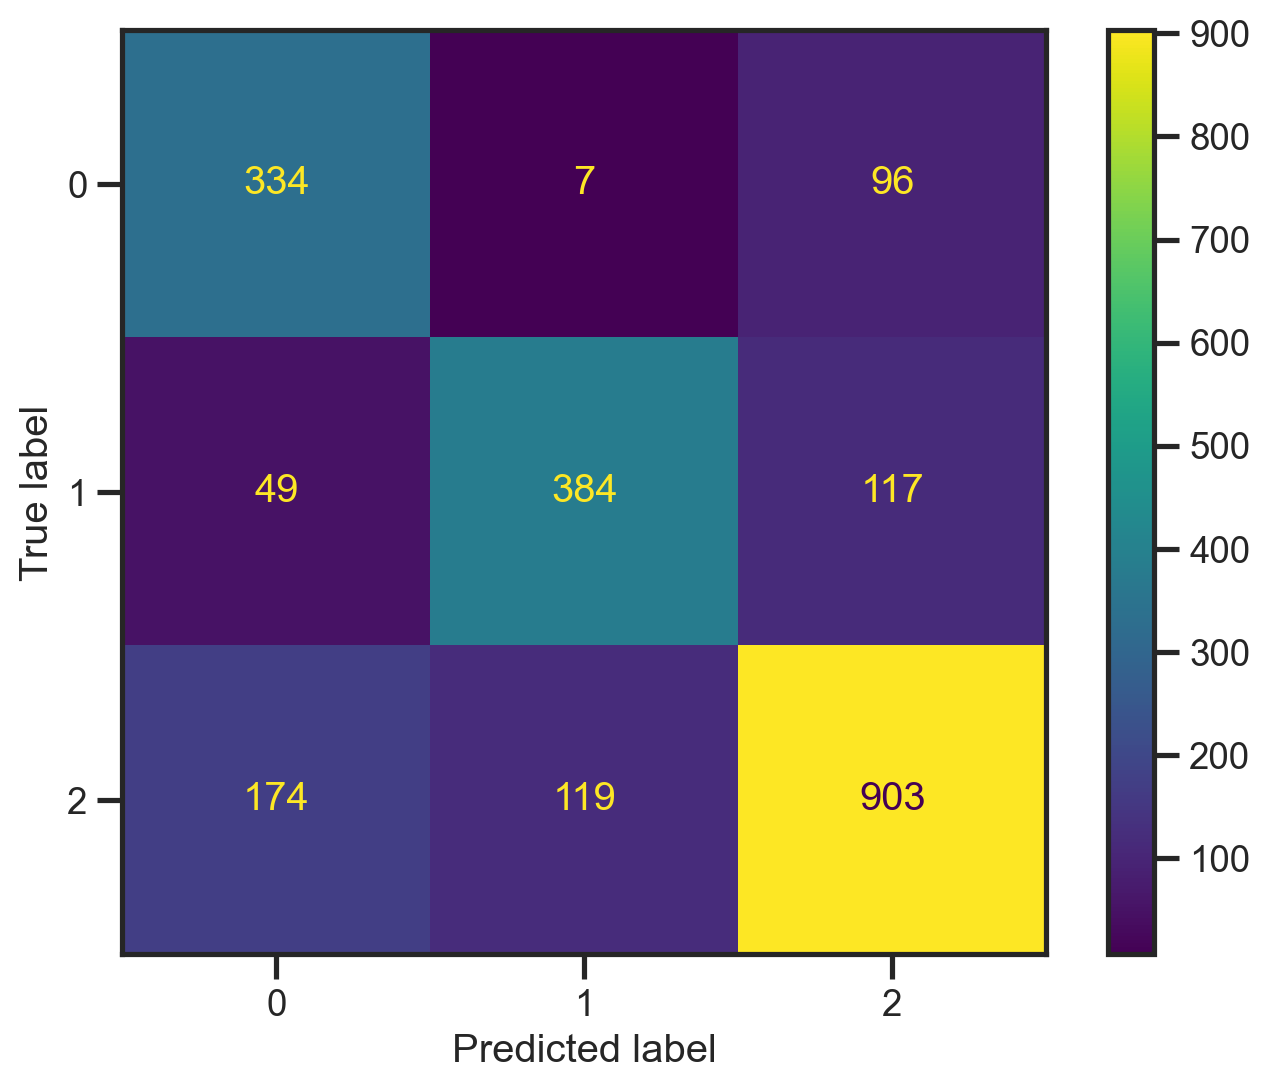

In [ ]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.76      0.67       437
           1       0.75      0.70      0.72       550
           2       0.81      0.76      0.78      1196

    accuracy                           0.74      2183
   macro avg       0.72      0.74      0.73      2183
weighted avg       0.75      0.74      0.75      2183



### ExtraTree Classifier

In [ ]:
predictions = extra.predict(X_test)
print(f"accuracy_score {accuracy_score(y_test, predictions)}")
print(f"balanced accuracy_score {balanced_accuracy_score(y_test, predictions)}")
print(f"precision_score {precision_score(y_test, predictions, average='macro')}")

accuracy_score 0.7366010077874484
balanced accuracy_score 0.7293935660068384
precision_score 0.7159634868316789


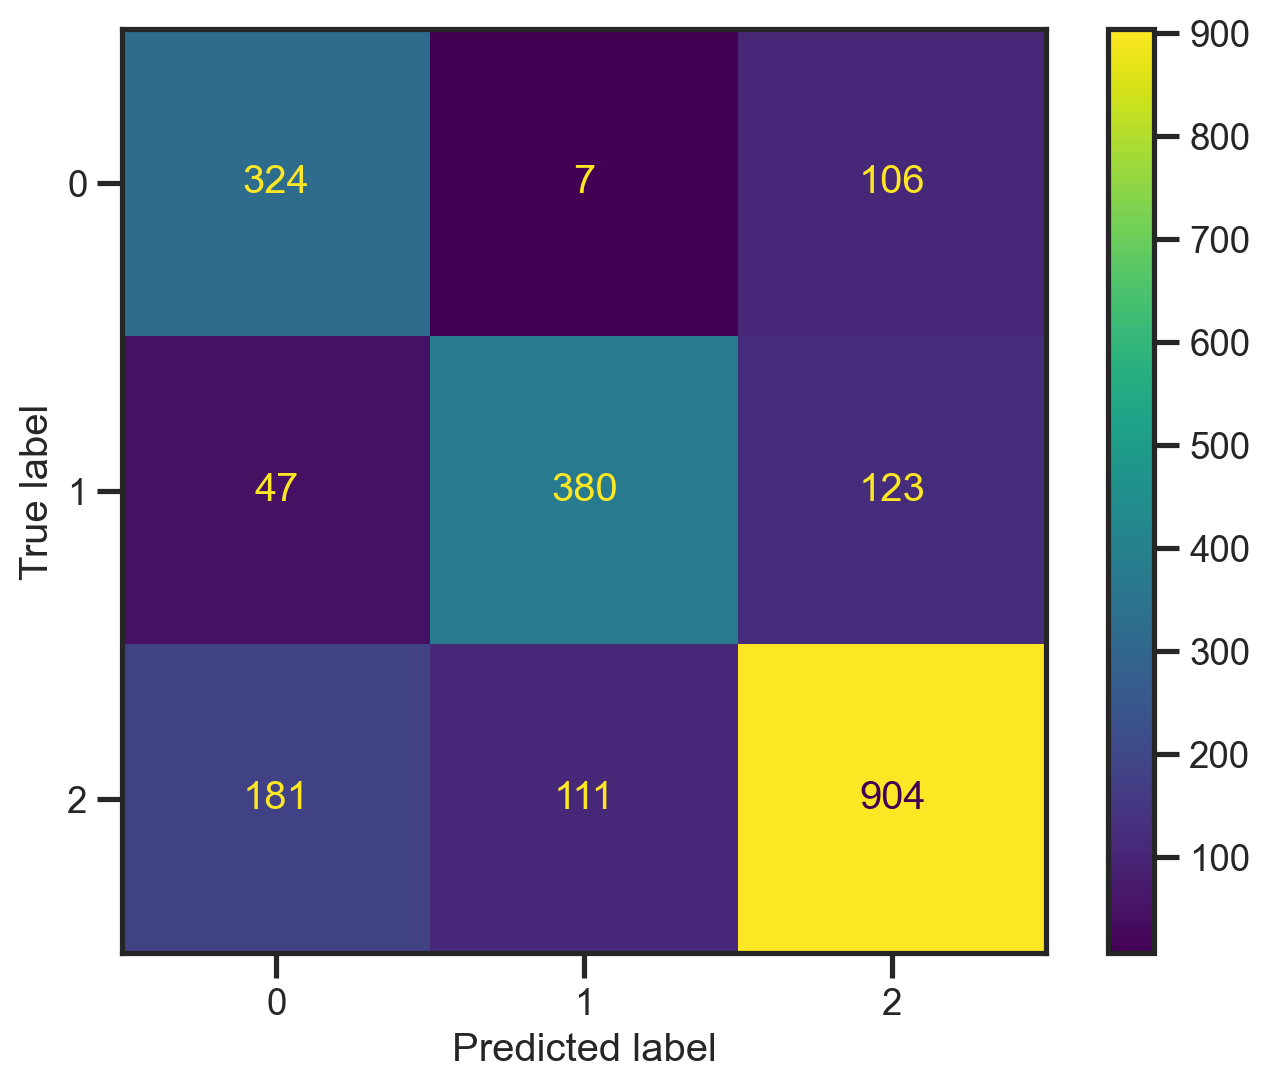

In [ ]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.59      0.74      0.66       437
           1       0.76      0.69      0.73       550
           2       0.80      0.76      0.78      1196

    accuracy                           0.74      2183
   macro avg       0.72      0.73      0.72      2183
weighted avg       0.75      0.74      0.74      2183



### Random Forest Classifier

In [ ]:
predictions = rfc.predict(X_test)
print(f"accuracy_score {accuracy_score(y_test, predictions)}")
print(f"balanced accuracy_score {balanced_accuracy_score(y_test, predictions)}")
print(f"precision_score {precision_score(y_test, predictions, average='macro')}")

accuracy_score 0.7388914338066881
balanced accuracy_score 0.7104561723554857
precision_score 0.7191815957322815


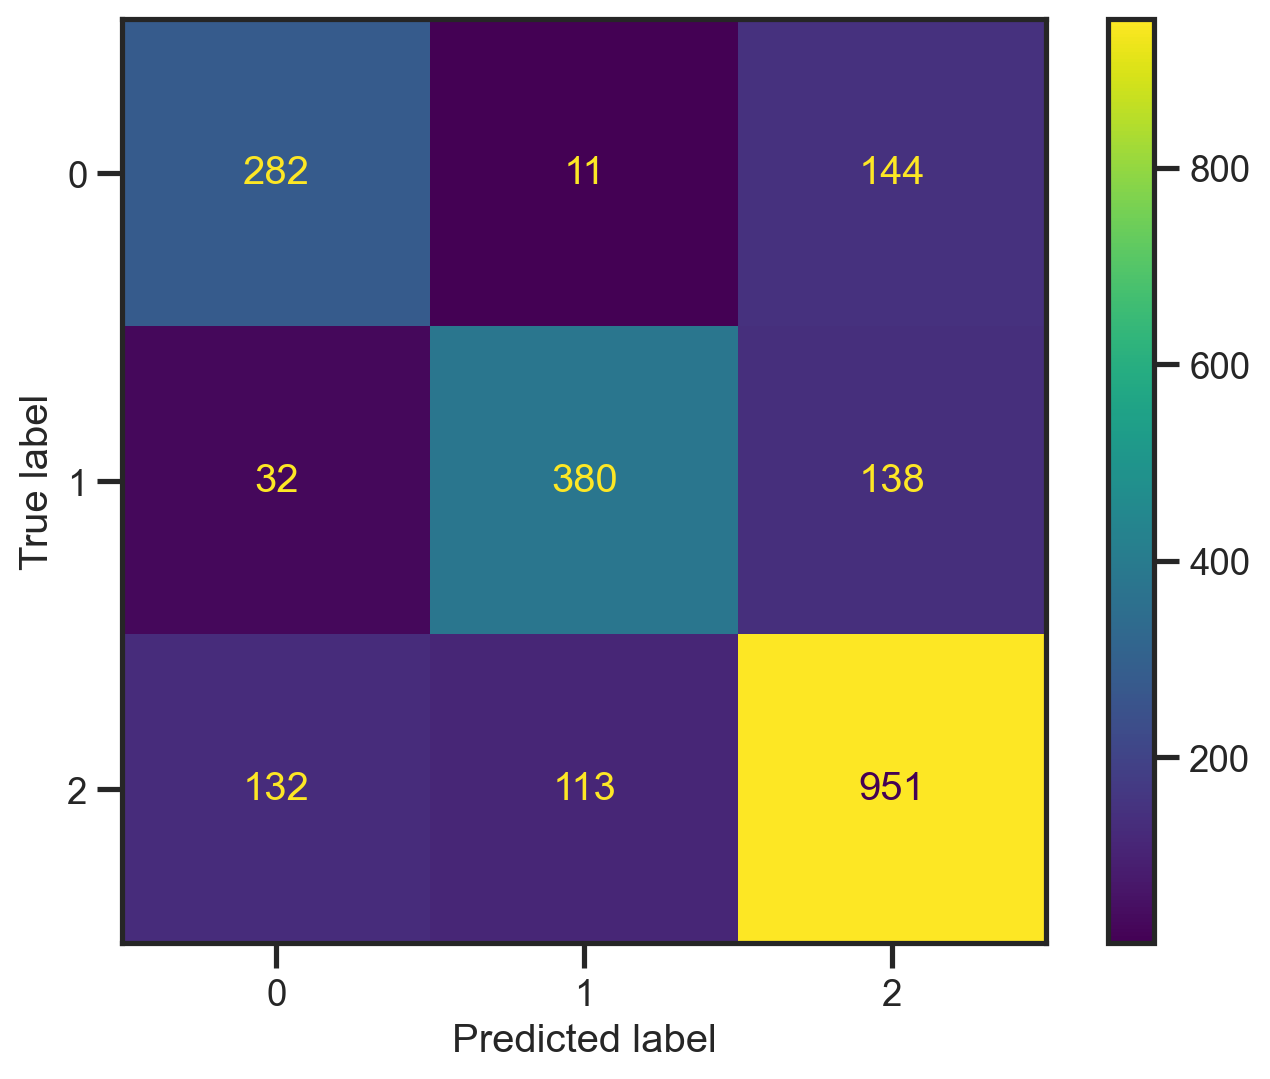

In [ ]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       437
           1       0.75      0.69      0.72       550
           2       0.77      0.80      0.78      1196

    accuracy                           0.74      2183
   macro avg       0.72      0.71      0.71      2183
weighted avg       0.74      0.74      0.74      2183



# create a new dataframe 
 selecting index that are not in `df_Ssample` dataframe from the main data frame


In [ ]:
indexes = [i for i in df.index if i not in df_sample.index]

In [ ]:
test_data = df.loc[indexes,:]

In [ ]:
test_data = test_data.drop(columns='Type_of_Loan')

In [ ]:
test_data.head()

Month   Age Occupation  Annual_Income  Num_Bank_Accounts  \
ID                                                               
5635      2  23.0  Scientist       19114.12                3.0   
5636      3  23.0  Scientist       19114.12                3.0   
5637      4  23.0  Scientist       19114.12                3.0   
5638      5  23.0  Scientist       19114.12                3.0   
5639      6  23.0  Scientist       19114.12                3.0   

      Num_Credit_Card  Interest_Rate  Delay_from_due_date  \
ID                                                          
5635              4.0            3.0                  3.0   
5636              4.0            3.0                  3.0   
5637              4.0            3.0                  5.0   
5638              4.0            3.0                  6.0   
5639              4.0            3.0                  8.0   

      Num_of_Delayed_Payment  Changed_Credit_Limit  ...  Monthly_Balance  \
ID                                                  ...                    
5635                     4.0                 11.27  ...       284.629162   
5636                     7.0                 11.27  ...       331.209863   
5637                     4.0                  6.27  ...       223.451310   
5638                     4.0                 11.27  ...       341.489231   
5639                     4.0                  9.27  ...       340.479212   

     Credit_Score  CreditBuilder  Personal  DebtConsolidation Student  Payday  \
ID                                                                              
5635            0              0         0                  0       0       0   
5636            0              0         0                  0       0       0   
5637            0              0         0                  0       0       0   
5638            0              0         0                  0       0       0   
5639            0              0         0                  0       0       0   

      Mortgage Auto  HomeEquity  
ID                               
5635         0    1           0  
5636         0    1           0  
5637         0    1           0  
5638         0    1           0  
5639         0    1           0  

[5 rows x 29 columns]

In [ ]:
predictions = ensemble.predict(test_data)

In [ ]:
test_data['predicted Credit_Score']=predictions

In [ ]:
print(f"accuracy_score {accuracy_score(test_data['Credit_Score'], test_data['predicted Credit_Score'])}")
print(f"balanced accuracy_score {balanced_accuracy_score(test_data['Credit_Score'], test_data['predicted Credit_Score'])}")
print(f"precision_score {precision_score(test_data['Credit_Score'], test_data['predicted Credit_Score'], average='macro')}")

accuracy_score 0.7230361893608626
balanced accuracy_score 0.7231495245401168
precision_score 0.6991896203887583


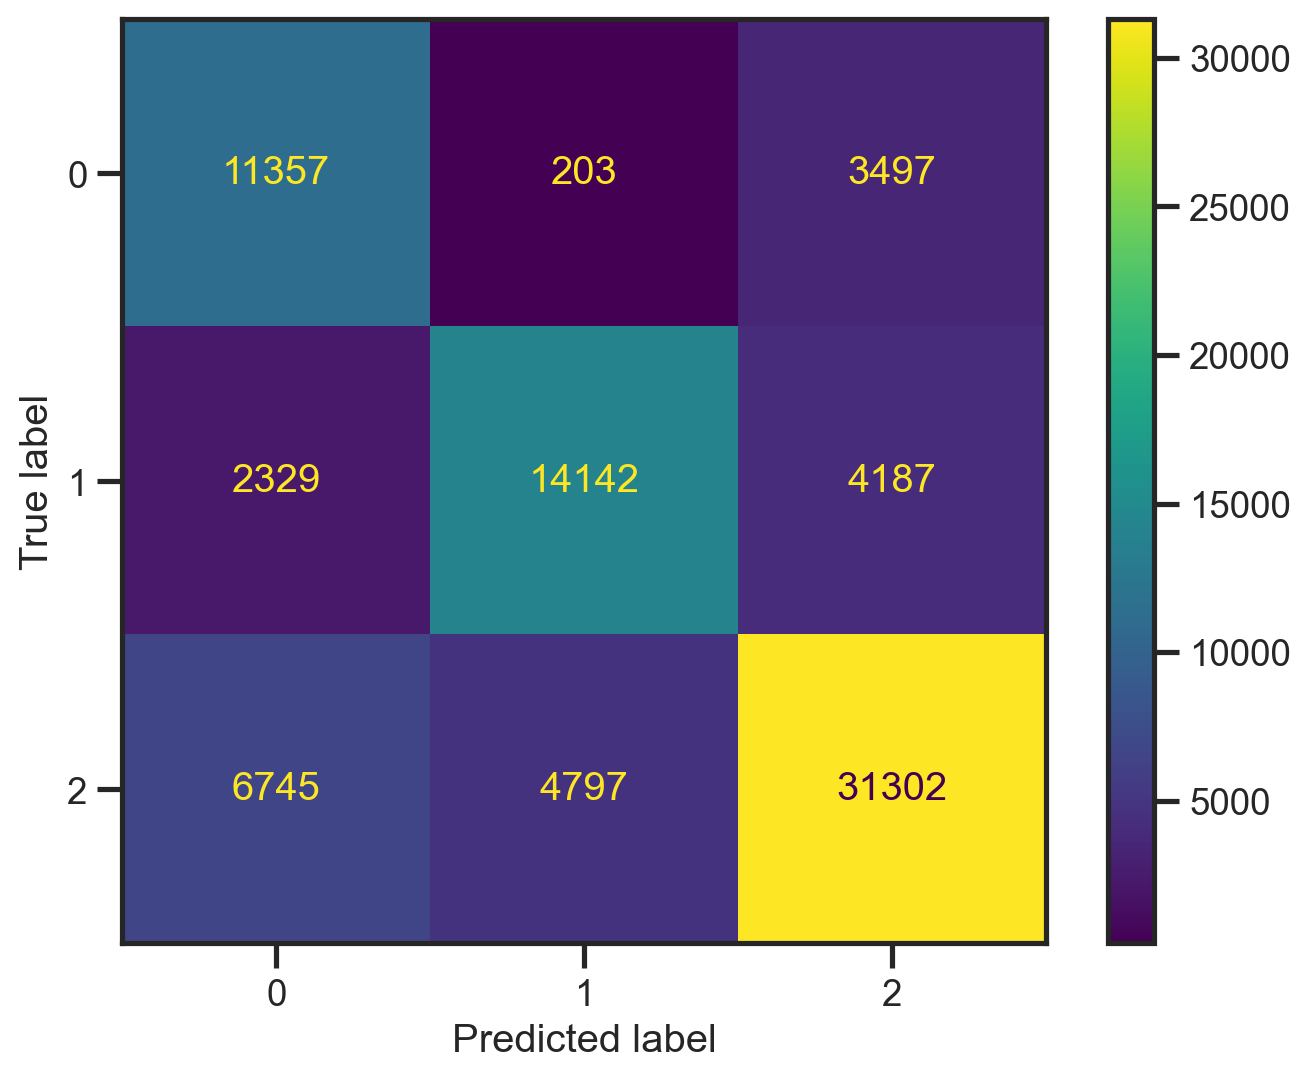

In [ ]:
cm = confusion_matrix(test_data['Credit_Score'], test_data['predicted Credit_Score'])
ConfusionMatrixDisplay(cm).plot()

In [ ]:
# using the whole dataset
X, y = df.drop(columns=['Credit_Score', 'Type_of_Loan']),df['Credit_Score']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=seed)

In [ ]:
X_train.head()

Month   Age    Occupation  Annual_Income  Num_Bank_Accounts  \
ID                                                                    
78721       8  47.0      Musician       30564.65                4.0   
153309      4  44.0       Manager       34476.68                6.0   
50073       4  39.0  Entrepreneur       22457.51                0.0   
117851      6  22.0      Mechanic      120368.32                1.0   
52833       4  53.0        Writer       18579.36                0.0   

        Num_Credit_Card  Interest_Rate  Delay_from_due_date  \
ID                                                            
78721               4.0            2.0                 15.0   
153309              7.0           24.0                 38.0   
50073               3.0           11.0                 21.0   
117851              7.0           12.0                  1.0   
52833               4.0            2.0                  4.0   

        Num_of_Delayed_Payment  Changed_Credit_Limit  ...  \
ID                                                    ...   
78721                     10.0                 11.79  ...   
153309                    17.0                  4.48  ...   
50073                      4.0                  2.68  ...   
117851                     9.0                  8.87  ...   
52833                     10.0                 10.14  ...   

                       Payment_Behaviour Monthly_Balance  CreditBuilder  \
ID                                                                        
78721    High_spent_Large_value_payments      460.779131              0   
153309    Low_spent_Large_value_payments      279.686128              0   
50073     Low_spent_Large_value_payments      339.155026              0   
117851  High_spent_Medium_value_payments      639.225593              0   
52833     Low_spent_Small_value_payments      270.592722              0   

        Personal  DebtConsolidation Student  Payday  Mortgage Auto  HomeEquity  
ID                                                                              
78721          0                  0       0       0         0    1           0  
153309         1                  0       0       0         0    0           0  
50073          0                  0       0       0         0    0           0  
117851         0                  0       0       0         1    0           0  
52833          0                  0       0       0         0    0           1  

[5 rows x 28 columns]

# GridSearch

In [ ]:
# (n_estimators: Int = 100, *, criterion: Literal['gini', 'entropy', 'log_loss'] = "gini", 
#  max_depth: Int | None = None, 
#  min_samples_split: float | int = 2, 
#  min_samples_leaf: float | int = 1, 
#  min_weight_fraction_leaf: Float = 0, 
#  max_features: float | int | Literal['sqrt', 'log2'] = "sqrt", 
#  max_leaf_nodes: Int | None = None, min_impurity_decrease: Float = 0, bootstrap: bool = False, 
#  oob_score: bool = False, n_jobs: Int | None = None, random_state: Int | RandomState | None = None, 
#  verbose: Int = 0, warm_start: bool = False, 
#  class_weight: Mapping | Sequence[Mapping] | Literal['balanced', 'balanced_subsample'] | None = None, ccp_alpha: float = 0, max_samples: float | int | None = None) -> None

In [ ]:
# Instantiate model
extra = model_pipe(ExtraTreesClassifier())

In [ ]:
# Define the parameter grid
param_grid = {
    'classif__n_estimators': [100,150,200],
    'classif__max_depth': [5,10,15],
    'classif__min_samples_split': [2,4,6],
    'classif__min_samples_leaf': [1,3,5]
}
kf = KFold(n_splits=5, random_state=seed, shuffle=True)
grid_extra = GridSearchCV(extra, param_grid,scoring='balanced_accuracy',cv=kf, return_train_score=True)
grid_extra.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('poly_int',
                                                                                          PolynomialFeatures(include_bias=False,
                                                                                                             interaction_only=True)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Annual_Income',
                                                                          'Num_Bank_Accounts',
                                                                          'Num_Credit_Card',
                                                                          'Interest...
                                                                          'Payment_of_Min_Amount',
                                                                          'Payment_Behaviour'])],
                                                          verbose_feature_names_out=False)),
                                       ('featsel', SelectKBest(k=66)),
                                       ('classif', ExtraTreesClassifier())]),
             param_grid={'classif__max_depth': [5, 10, 15],
                         'classif__min_samples_leaf': [1, 3, 5],
                         'classif__min_samples_split': [2, 4, 6],
                         'classif__n_estimators': [100, 150, 200]},
             return_train_score=True, scoring='balanced_accuracy')

In [ ]:
print("Best hyperparameters: ", grid_extra.best_params_)
print("Best score: ", grid_extra.best_score_)

Best hyperparameters:  {'classif__max_depth': 15, 'classif__min_samples_leaf': 1, 'classif__min_samples_split': 2, 'classif__n_estimators': 150}
Best score:  0.7615828665958391


In [ ]:
pd.DataFrame(grid_extra.cv_results_,columns=['mean_test_score','mean_train_score','params',\
                                                  'rank_test_score']).sort_values(by='rank_test_score').head(1)['params'].values

array([{'classif__max_depth': 15, 'classif__min_samples_leaf': 1, 'classif__min_samples_split': 2, 'classif__n_estimators': 150}],
      dtype=object)

In [ ]:
# Extra trees model
extra = model_pipe(ExtraTreesClassifier(n_estimators=150, min_samples_leaf=1, min_samples_split=2, max_depth=15))
evaluate(extra)

model  train_score  \
0  (ExtraTreeClassifier(max_depth=15, random_stat...     0.841857   

   balanced_acc       acc  precision  
0      0.767866  0.771836   0.778485

### Random Forest Regression Model

In [ ]:
# Instantiate model
rfc = model_pipe(RandomForestClassifier())

In [ ]:
# Define the parameter grid
param_grid = {
    'classif__n_estimators':[100,150,200],
    'classif__min_samples_leaf':[1,3,5],
    'classif__min_samples_split':[2,4,6],
    'classif__max_depth': [5,10,15],
}
kf = KFold(n_splits=5, random_state=seed, shuffle=True)
grid_rfc = GridSearchCV(rfc, param_grid,scoring='balanced_accuracy',cv=kf, return_train_score=True)
grid_rfc.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('poly_int',
                                                                                          PolynomialFeatures(include_bias=False,
                                                                                                             interaction_only=True)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Annual_Income',
                                                                          'Num_Bank_Accounts',
                                                                          'Num_Credit_Card',
                                                                          'Interest...
                                                                          'Payment_of_Min_Amount',
                                                                          'Payment_Behaviour'])],
                                                          verbose_feature_names_out=False)),
                                       ('featsel', SelectKBest(k=66)),
                                       ('classif', RandomForestClassifier())]),
             param_grid={'classif__max_depth': [5, 10, 15],
                         'classif__min_samples_leaf': [1, 3, 5],
                         'classif__min_samples_split': [2, 4, 6],
                         'classif__n_estimators': [100, 150, 200]},
             return_train_score=True, scoring='balanced_accuracy')

In [ ]:
print("Best hyperparameters: ", grid_rfc.best_params_)
print("Best score: ", grid_rfc.best_score_)

Best hyperparameters:  {'classif__max_depth': 15, 'classif__min_samples_leaf': 1, 'classif__min_samples_split': 4, 'classif__n_estimators': 200}
Best score:  0.7712703873877691


In [ ]:
pd.DataFrame(grid_rfc.cv_results_,columns=['mean_test_score','mean_train_score','params',\
                                                  'rank_test_score']).sort_values(by='rank_test_score').head(1)['params'].values

array([{'classif__max_depth': 15, 'classif__min_samples_leaf': 1, 'classif__min_samples_split': 4, 'classif__n_estimators': 200}],
      dtype=object)

In [ ]:
# Random forest model
rfc = model_pipe(RandomForestClassifier(n_estimators=200, min_samples_leaf=1, min_samples_split=4, max_depth=15))
evaluate(rfc)

model  train_score  \
0  (DecisionTreeClassifier(max_depth=15, max_feat...     0.858323   

   balanced_acc     acc  precision  
0      0.779662  0.7876   0.790193

In [ ]:
ensembled = [extra, rfc]

In [ ]:
# fit all models
for est in ensembled:
    est.fit(X_train, y_train)

In [ ]:
ensemble = VotingClassifier([("extra",extra), ("rfc", rfc)])

In [ ]:
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('extra',
                              Pipeline(steps=[('pp',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('num',
                                                                                Pipeline(steps=[('poly_int',
                                                                                                 PolynomialFeatures(include_bias=False,
                                                                                                                    interaction_only=True)),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['Age',
                                                                                 'Annual_Income',
                                                                                 'Num_Bank_Accounts',
                                                                                 'Num_Credit_Card',
                                                                                 'Interest_Rate',
                                                                                 'Delay_from_due_date',
                                                                                 'Num_of_...
                                                                                Pipeline(steps=[('ohe',
                                                                                                 OneHotEncoder(drop='if_binary',
                                                                                                               handle_unknown='infrequent_if_exist',
                                                                                                               sparse_output=False))]),
                                                                                ['Month',
                                                                                 'Occupation',
                                                                                 'Credit_Mix',
                                                                                 'Payment_of_Min_Amount',
                                                                                 'Payment_Behaviour'])],
                                                                 verbose_feature_names_out=False)),
                                              ('featsel', SelectKBest(k=66)),
                                              ('classif',
                                               RandomForestClassifier(max_depth=15,
                                                                      min_samples_split=4,
                                                                      n_estimators=200))]))])

In [ ]:
all_regr = ensembled + [ ensemble ]
all_regr

[Pipeline(steps=[('pp',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num',
                                                   Pipeline(steps=[('poly_int',
                                                                    PolynomialFeatures(include_bias=False,
                                                                                       interaction_only=True)),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['Age', 'Annual_Income',
                                                    'Num_Bank_Accounts',
                                                    'Num_Credit_Card',
                                                    'Interest_Rate',
                                                    'Delay_from_due_date',
                           

In [ ]:
for est in all_regr:
    kf = KFold(n_splits=5, random_state=seed, shuffle=True)
    scores = cross_val_score(est, X_train, y_train, cv=kf, scoring='balanced_accuracy')
    print(scores.mean(), scores.std())
    +

0.761083102810623 0.0045426308126186345
0.7708127374318859 0.0047709237886064786
0.7705618505725041 0.0057839857727345415


Voting Ensembled model happens to be the best performing model

### Voting Classifier

In [ ]:
predictions = ensemble.predict(X_test)
print(f"accuracy_score {accuracy_score(y_test, predictions)}")
print(f"balanced accuracy_score {balanced_accuracy_score(y_test, predictions)}")
print(f"precision_score {precision_score(y_test, predictions, average='macro')}")

accuracy_score 0.7775181009989919
balanced accuracy_score 0.7790456564082119
precision_score 0.7532195699064963


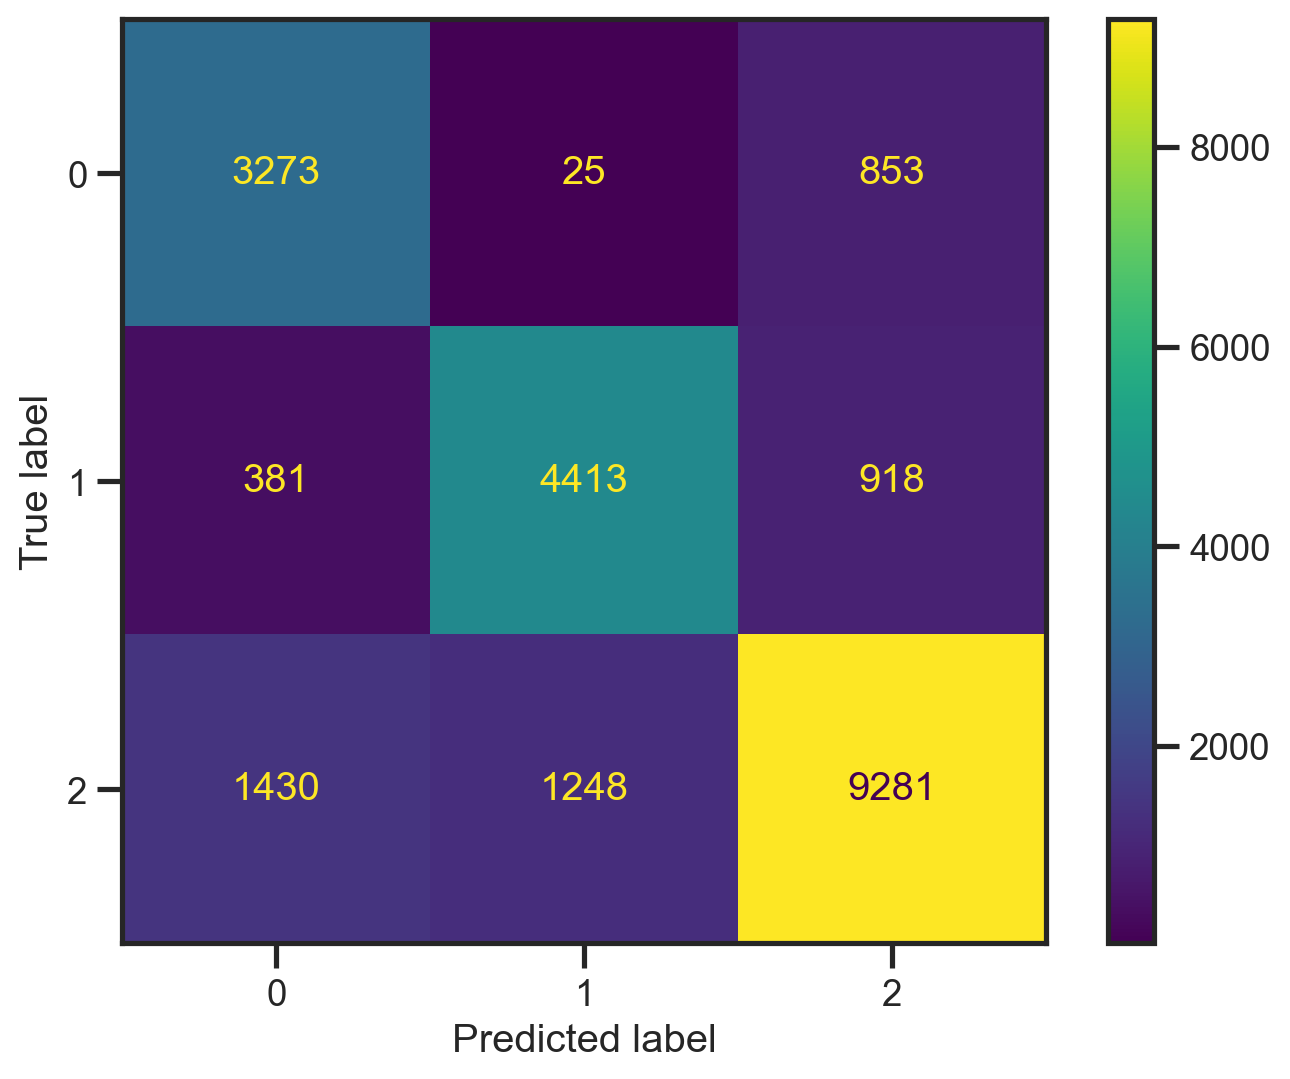

In [ ]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.79      0.71      4151
           1       0.78      0.77      0.77      5712
           2       0.84      0.78      0.81     11959

    accuracy                           0.78     21822
   macro avg       0.75      0.78      0.76     21822
weighted avg       0.79      0.78      0.78     21822



### ExtraTree Classifier

In [ ]:
predictions = extra.predict(X_test)
print(f"accuracy_score {accuracy_score(y_test, predictions)}")
print(f"balanced accuracy_score {balanced_accuracy_score(y_test, predictions)}")
print(f"precision_score {precision_score(y_test, predictions, average='macro')}")

accuracy_score 0.772156539272294
balanced accuracy_score 0.7681612753329459
precision_score 0.74990315869623


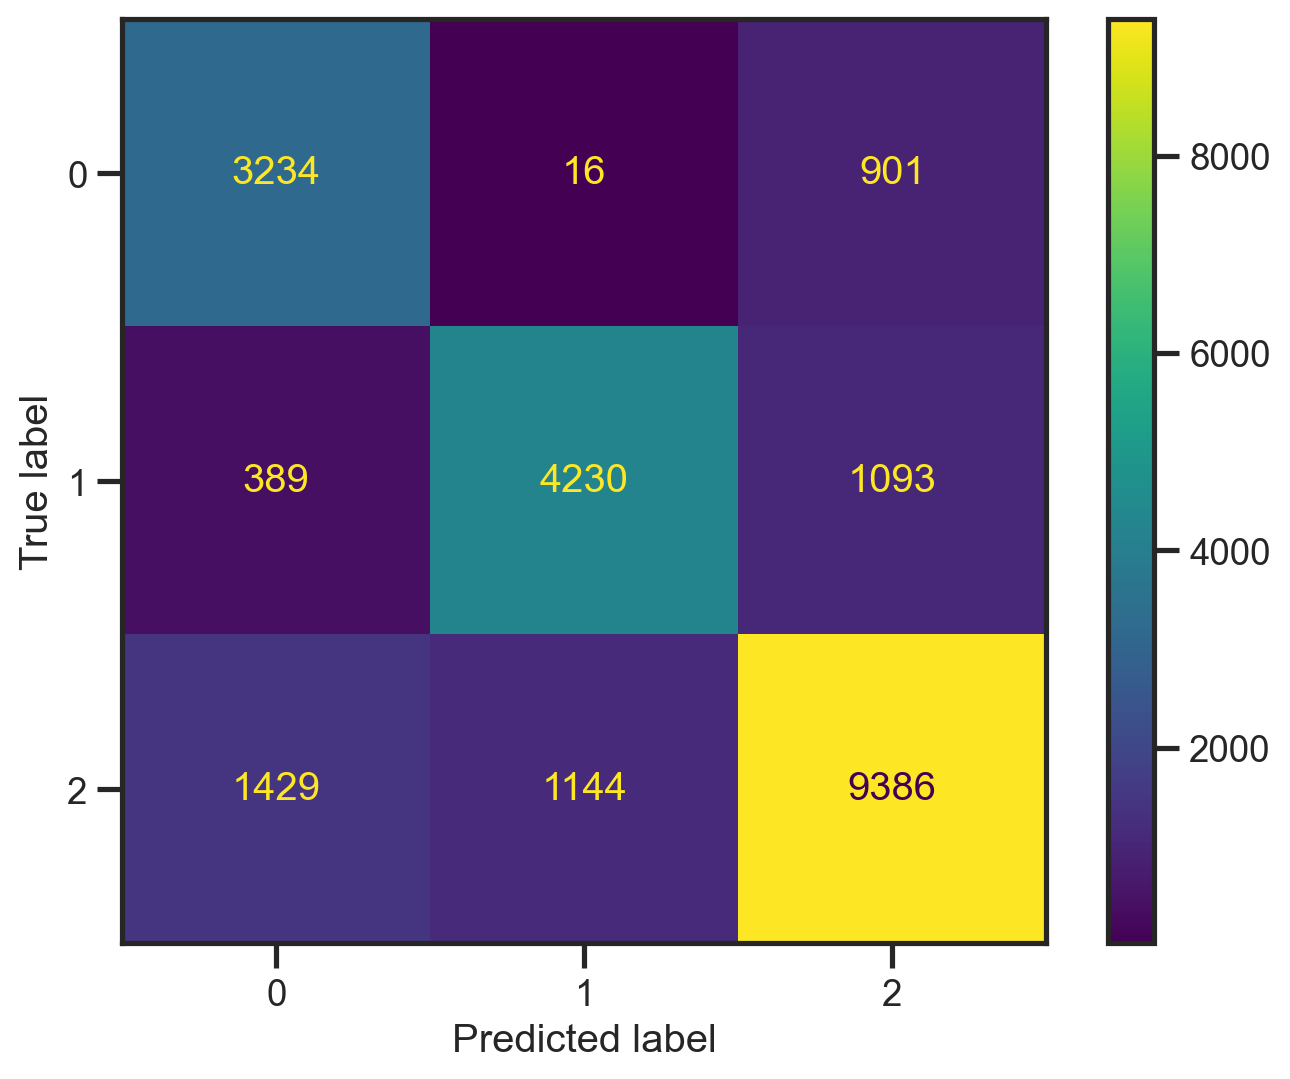

In [ ]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.78      0.70      4151
           1       0.78      0.74      0.76      5712
           2       0.82      0.78      0.80     11959

    accuracy                           0.77     21822
   macro avg       0.75      0.77      0.76     21822
weighted avg       0.78      0.77      0.77     21822



### Random Forest Classifier

In [ ]:
predictions = rfc.predict(X_test)
print(f"accuracy_score {accuracy_score(y_test, predictions)}")
print(f"balanced accuracy_score {balanced_accuracy_score(y_test, predictions)}")
print(f"precision_score {precision_score(y_test, predictions, average='macro')}")

accuracy_score 0.7878287966272569
balanced accuracy_score 0.779347526286283
precision_score 0.7673349240913673


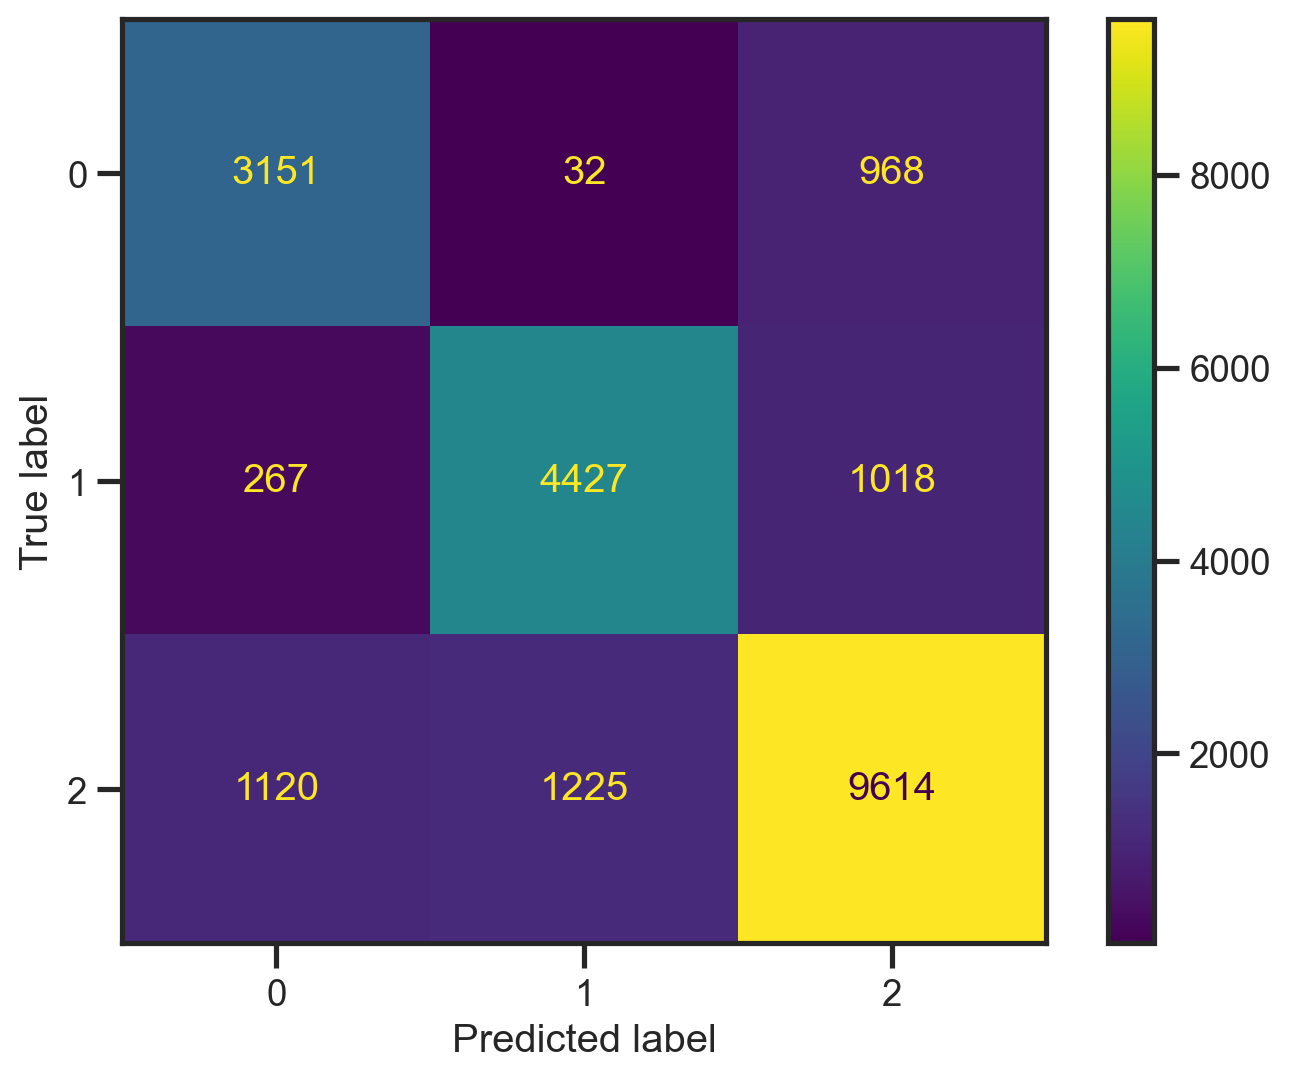

In [ ]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.69      0.76      0.73      4151
           1       0.78      0.78      0.78      5712
           2       0.83      0.80      0.82     11959

    accuracy                           0.79     21822
   macro avg       0.77      0.78      0.77     21822
weighted avg       0.79      0.79      0.79     21822

